# Imports

In [274]:
# Data
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Stats
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import optuna
# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
# Misc
from tqdm import tqdm
from typing import Optional, List, Union # type tips
import warnings
from itertools import combinations


# Data

## Load Data

In [100]:
# df is the non-normalized passive data with features and target 
# df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_passive_fe.csv')
df = pd.read_csv('../../../3_3_2_processed_data/modeling/all_data/all_features.csv')
# Rename css column to task_css
df = df.rename(columns={'css': 'task_css'})


# mlm_gap_df is the results of the MLM on the gap data
mlm_gap_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
mlm_affect_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_affect_results_df.csv')

In [101]:
df_raw = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/1744315639.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')


**Visualize raw vs detrended data**

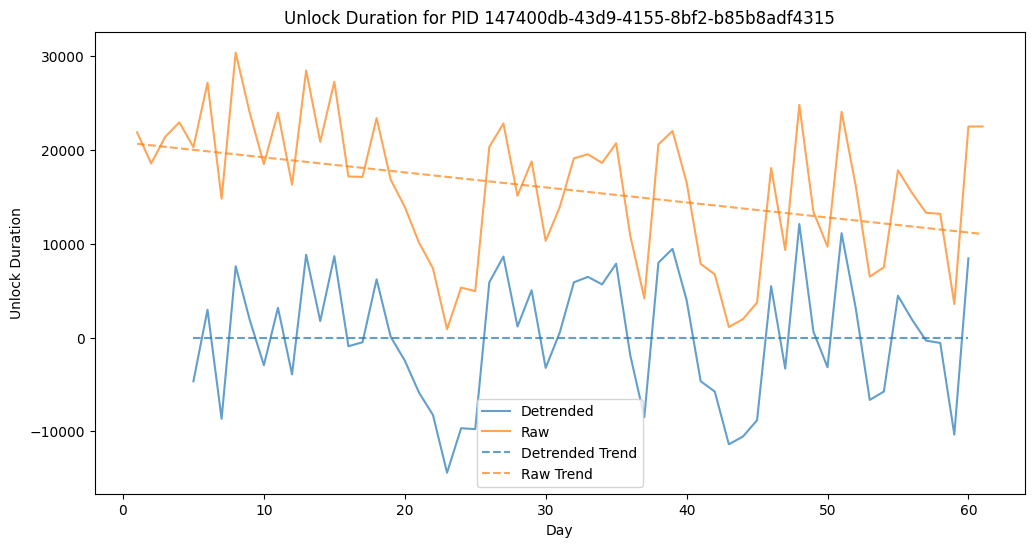

Plotted data for PID: 147400db-43d9-4155-8bf2-b85b8adf4315
Number of detrended data points: 56
Number of raw data points: 61


In [102]:
# Pick a random PID that exists in both dataframes
common_pids = list(set(df.PID).intersection(set(df_raw.PID)))
random_pid = np.random.choice(common_pids)

# Create figure
plt.figure(figsize=(12, 6))

# Get data for selected PID
detrended_data = df[df.PID == random_pid]
raw_data = df_raw[df_raw.PID == random_pid]

# Remove any NaN values before plotting and fitting
detrended_data = detrended_data.dropna(subset=['day', 'passive_sk_device_total_unlock_duration'])
raw_data = raw_data.dropna(subset=['day', 'passive_sk_device_total_unlock_duration'])

# Define colors
detrended_color = '#1f77b4'  # Default matplotlib blue
raw_color = '#ff7f0e'  # Default matplotlib orange

# Plot both lines on same axes
plt.plot(detrended_data['day'], 
         detrended_data['passive_sk_device_total_unlock_duration'],
         label='Detrended',
         alpha=0.7,
         color=detrended_color)
plt.plot(raw_data['day'],
         raw_data['passive_sk_device_total_unlock_duration'], 
         label='Raw',
         alpha=0.7,
         color=raw_color)

# Add regression lines if we have enough valid data points
if len(detrended_data) > 1:
    # For detrended data
    z_detrended = np.polyfit(detrended_data['day'], 
                            detrended_data['passive_sk_device_total_unlock_duration'], 
                            1)
    p_detrended = np.poly1d(z_detrended)
    
    # Create x values for smooth line
    x_detrended = np.linspace(detrended_data['day'].min(), 
                             detrended_data['day'].max(), 
                             100)
    plt.plot(x_detrended, 
             p_detrended(x_detrended), 
             '--',  # Just use dashed line style
             alpha=0.7,
             color=detrended_color,
             label='Detrended Trend')

if len(raw_data) > 1:
    # For raw data
    z_raw = np.polyfit(raw_data['day'], 
                       raw_data['passive_sk_device_total_unlock_duration'], 
                       1)
    p_raw = np.poly1d(z_raw)
    
    # Create x values for smooth line
    x_raw = np.linspace(raw_data['day'].min(), 
                        raw_data['day'].max(), 
                        100)
    plt.plot(x_raw, 
             p_raw(x_raw), 
             '--',  # Just use dashed line style
             alpha=0.7,
             color=raw_color,
             label='Raw Trend')

plt.title(f'Unlock Duration for PID {random_pid}')
plt.xlabel('Day')
plt.ylabel('Unlock Duration')
plt.legend()
plt.show()

# Print the PID used and data points available
print(f"Plotted data for PID: {random_pid}")
print(f"Number of detrended data points: {len(detrended_data)}")
print(f"Number of raw data points: {len(raw_data)}")

**Add Cendri Hutcherson's calculated drift rate**
- Used ddm models to break down task performance by day and then averaged across tasks.

In [103]:
drift_df = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/DailyCogDDMMeasure.csv')
# Rename columns
drift_df = drift_df.rename(columns={
    'subj': 'PID',
    'date': 'trial_date',
    'allCogDTNormDDM2': 'task_drift'
})

drift_df = drift_df[['PID', 'trial_date', 'task_drift']]

# join drift_df to df
df = pd.merge(df, drift_df, on=['PID', 'trial_date'], how='left')

## Clean Data

In [104]:
# remove t_current
df = df.drop(columns=['t_current'])

# remove subject with wonky data
df = df[df['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']

# remove any columns containing 'sr_gap_heuristic'
df = df.drop(columns=[col for col in df.columns if 'sr_gap_heuristic' in col])

## Data Subsets

### ID Features

In [315]:
# ID cols
id_cols = [
    'PID',
    #'trial_date',
    'day',
   # 'cohort',
    'weekend',
    'day_of_week_0',
    'day_of_week_1',
    'day_of_week_2',
    'day_of_week_3',
    'day_of_week_4',
    'day_of_week_5',
    'day_of_week_6',
    ]

### Passive Features

In [370]:
# Passive features
passive_cols = [col for col in df.columns if 'passive' in col]

# Additional cols
additional_passive_cols = [
    'task_duration',
    'task_start_time',
    'task_end_time',
    'survey_complete',
    'tasks_complete',
    'watch_wearing'
]

# Create df_passive
passive_cols = passive_cols + additional_passive_cols

In [371]:
len(passive_cols)

670

### Affect Features


In [107]:
# Affect features
affect_cols = [col for col in df.columns if 'affect_' in col]
affect_pm_cols = [col for col in df.columns if 'affect_' in col and not col.endswith('_am')]

### Self Report Features

In [394]:
# create list of self report features
sr_cols = [col for col in df.columns if 'sr_' in col]

# remove affect self report features
sr_cols = [col for col in sr_cols if 'affect' not in col]

# remove social support features
sr_cols = [col for col in sr_cols if 'ss_' not in col]

# remove goal related features
sr_cols = [col for col in sr_cols if '_goal' not in col]

# List of self report features directly related to gap
gap_related_sr = [
    'sr_DAILY_past24_procrastination',
    'sr_DAILY_past24_productivity',
    'sr_DAILY_past24_punctuality',
    'sr_DAILY_past24_satisfaction',
    'sr_DAILY_past24_values',
    'sr_DAILY_past24_gapCause_internal',
    'sr_DAILY_past24_gapCause_external',
    'sr_DAILY_past24_gap',
    'sr_DAILY_past24_ideal',
    'sr_DAILY_past24_change',
    'sr_gap_heuristic',
    'sr_gap_heuristic_intercept',
    'sr_gap_heuristic_slope',
    'sr_DAILY_past48to24_gap',
    'sr_DAILY_past48to24_gapCause_internal',
    'sr_DAILY_past48to24_gapCause_external'
]

# remove self report that seem directly related to gap
sr_cols = [col for col in sr_cols if not any(gap_term in col for gap_term in gap_related_sr)]

# remove occupation features
sr_cols = [col for col in sr_cols if 'occupation' not in col]

In [395]:
sr_cols

['sr_DAILY_next24_drinks',
 'sr_DAILY_next24_exercise',
 'sr_DAILY_next24_leisureNonSolo',
 'sr_DAILY_next24_leisureSolo',
 'sr_DAILY_next24_sleep',
 'sr_DAILY_next24_socialMedia',
 'sr_DAILY_past24_diet',
 'sr_DAILY_past24_drinks',
 'sr_DAILY_past24_exercise',
 'sr_DAILY_past24_fatigue',
 'sr_DAILY_past24_illness',
 'sr_DAILY_past24_leisureNonSolo',
 'sr_DAILY_past24_leisureNonSoloMental',
 'sr_DAILY_past24_leisureNonSoloPhysical',
 'sr_DAILY_past24_leisureSolo',
 'sr_DAILY_past24_leisureSoloMental',
 'sr_DAILY_past24_leisureSoloPhysical',
 'sr_DAILY_past24_mentalEffort',
 'sr_DAILY_past24_physicalEffort',
 'sr_DAILY_past24_sleep',
 'sr_DAILY_past24_socialMedia',
 'sr_DAILY_past24_unusualEvents',
 'sr_DAILY_gap_diet',
 'sr_DAILY_gap_sleep',
 'sr_DAILY_gap_leisureSolo',
 'sr_DAILY_gap_leisureNonSolo',
 'sr_DAILY_gap_exercise',
 'sr_DAILY_gap_socialMedia',
 'sr_DAILY_gap_drinks',
 'fe_lag_1_sr_DAILY_next24_drinks',
 'fe_lag_2_sr_DAILY_next24_drinks',
 'fe_lag_3_sr_DAILY_next24_drinks',


### Task Data

In [109]:
task_cols = [col for col in df.columns if 'task_' in col]

# Remove columns containing '_model_' as these do not change by day
task_cols = [col for col in task_cols if '_model_' not in col]

## Targets

### Well-being Weighted Target

Based on `Gap_Weighting.ipynb`, using the MLM model with correlation of .484 with `sr_affect_net_avg`

| measure                  | weights   |
|--------------------------|----------:|
| values_adherence         | 0.530248  |
| overall_goal_completion  | 0.249118  |
| goal1_completion         | 0.146432  |
| goal2_completion         | 0.074202  |

In [110]:
# load undetrended data
df_undetrended = pd.read_csv('../../../3_3_2_processed_data/modeling/df_cleaned_no_outliers.csv')

In [111]:
# Filter df_undetrended to match days in df
df_undetrended = df_undetrended[df_undetrended['day'].isin(df['day'])]

# Print first and last day in df_undetrended
print("First day:", df_undetrended['day'].min())
print("Last day:", df_undetrended['day'].max())

First day: 5
Last day: 81


In [112]:
# Flip goal accomplishment to be report gap
df_undetrended['values_gap'] = 100 - df_undetrended['sr_DAILY_past24_values']
df_undetrended['goal1_gap'] = 100 - df_undetrended['sr_DAILY_goal1_report']
df_undetrended['goal2_gap'] = 100 - df_undetrended['sr_DAILY_goal2_report']

In [113]:
# Create weighted well-being gap target
def calculate_wbw_gap(row):
    # Define features and their weights
    feature_weights = {
        'values_gap': 0.530248,
        'sr_DAILY_past24_gap': 0.249118, 
        'goal1_gap': 0.146432,
        'goal2_gap': 0.074202
    }
    
    # Get available features (not NaN)
    available_features = {k:v for k,v in feature_weights.items() 
                        if not pd.isna(row[k])}
    
    # If no features available, return NaN
    if len(available_features) == 0:
        return np.nan
        
    # Renormalize weights of available features
    weight_sum = sum(available_features.values())
    normalized_weights = {k:v/weight_sum for k,v in available_features.items()}
    
    # Calculate weighted sum
    weighted_sum = sum(row[k] * v for k,v in normalized_weights.items())
    
    return weighted_sum

# Apply calculation to create new feature
df_undetrended['target_wbw_gap'] = df_undetrended.apply(calculate_wbw_gap, axis=1)

### Detrend Targets

In [114]:
# Create detrended version of target_wbw_gap
df_undetrended['target_wbw_gap_detrended'] = df_undetrended.groupby('PID')['target_wbw_gap'].transform(detrend_column)
# Drop 'target_wbw_gap'
df_undetrended = df_undetrended.drop(columns=['target_wbw_gap'])

### Join Targets

In [115]:
# Get all target columns from df_undetrended
target_cols = [col for col in df_undetrended.columns if col.startswith('target_')]

# Join target columns from df_undetrended to df
df = df.merge(
    df_undetrended[['PID', 'day'] + target_cols],
    on=['PID', 'day'],
    how='left'
)

In [116]:
df.head()

,PID,day,task_hanoi_solved,task_emoStroop_trying,task_gng_trying,task_nback_mode_hard,survey_complete,tasks_complete,watch_wearing,weekend,...,fe_rollingSD_7_passive_sk_messages_inOut_ratio,fe_rollingSD_7_task_start_time,fe_rollingSD_7_task_end_time,fe_rollingSD_7_task_duration,fe_rollingSD_7_task_food_ht_avgRT,fe_rollingSD_7_task_food_ut_avgRT,fe_rollingSD_7_task_food_ht_avgRating,fe_rollingSD_7_task_food_ut_avgRating,task_drift,target_wbw_gap_detrended
0,0151d9f1-1644-4437-805e-02f5e244a690,5,True,1.0,1.0,0.0,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.645728,25.683075
1,0151d9f1-1644-4437-805e-02f5e244a690,6,True,1.0,1.0,1.0,1,1,1,1,...,NaN,65.810072,61.356446,4.453626,540.880677,506.212073,0.461392,0.510455,0.414383,7.857328
2,0151d9f1-1644-4437-805e-02f5e244a690,7,True,1.0,1.0,0.0,1,1,1,1,...,NaN,61.893461,58.439536,3.558232,411.004520,541.143049,0.408402,0.819477,-0.784166,5.119437
3,0151d9f1-1644-4437-805e-02f5e244a690,8,True,1.0,1.0,0.0,1,1,1,0,...,0.749962,72.603710,71.442976,3.086996,356.407667,468.625427,0.793279,0.705202,-0.324704,13.995453
4,0151d9f1-1644-4437-805e-02f5e244a690,9,True,1.0,1.0,1.0,1,1,1,0,...,0.530949,63.415960,62.493312,2.727695,434.411834,462.889872,0.731280,0.747240,0.147973,6.560990


# Functions

In [282]:
def create_train_test_split(data: pd.DataFrame, target: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Creates train/test splits for time series data on a per-participant basis.
    
    For each participant (PID):
    1. Finds their last day of data collection based on target variable
    2. Removes any data after their last valid day
    3. Creates an 80/20 chronological train/test split
    
    Args:
        data: DataFrame containing participant data with columns:
            - PID: Participant ID
            - day: Day number of study
            - target: Target variable to determine last valid day
        target: Name of target variable column
            
    Returns:
        tuple containing:
            - train_data: DataFrame with first 80% of each participant's data
            - test_data: DataFrame with last 20% of each participant's data
    """
    # Get last day of data collection for each PID based on target variable
    last_days = data.groupby('PID').agg({
        'day': lambda x: x[data[target].notna()].max()
    }).reset_index()

    # Remove any data after each PID's last day
    tt_filtered = pd.merge(
        data,
        last_days,
        on='PID',
        suffixes=('', '_last')
    )
    tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]
    
    # Create train/test splits for each PID
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for pid in tt_filtered['PID'].unique():
        pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
        
        # Sort by day to ensure chronological split
        pid_data = pid_data.sort_values('day')
        
        # Calculate split point at 80%
        split_idx = int(len(pid_data) * 0.8)
        
        # Split the data
        train_pid = pid_data.iloc[:split_idx]
        test_pid = pid_data.iloc[split_idx:]
        
        # Append to main dataframes
        train_data = pd.concat([train_data, train_pid])
        test_data = pd.concat([test_data, test_pid])
        
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [123]:
def expanding_window_cv_nested(df: pd.DataFrame, validation_days: int = 15) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Performs expanding window cross-validation accounting for nested observations within subjects.
    Creates 5 splits, each moving forward by 3 days and using 3 days for validation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Training data containing 'PID' and 'day' columns
    validation_days : int
        Number of days to use for validation windows
        
    Returns:
    --------
    list of tuples
        Each tuple contains (train_idx, val_idx) for one fold, 
        where indices from all subjects are combined
    """
    # Dictionary to store splits by window position
    window_splits = {}  # {window_position: [(train_idx, val_idx), ...]}
    
    # Process each subject separately
    for pid in df['PID'].unique():
        # Get data for this subject
        subject_data = df[df['PID'] == pid].copy()
        
        # Get sorted unique days for this subject
        subject_days = sorted(subject_data['day'].unique())
        n_days = len(subject_days)
        
        # Skip subjects with too few observations
        if n_days < 25:  # means min of 10 days in initial training
            continue
            
        # Determine window days for this subject
        window_start_idx = max(0, n_days - validation_days)
        window_days = subject_days[window_start_idx:]
        
        # Create 5 splits, moving forward by 3 days each time
        for window_pos in range(0, 5):  # 5 splits
            val_start_idx = window_start_idx + (window_pos * 3)  # Move forward by 3 days each time
            
            # Skip if we don't have enough days left
            if val_start_idx + 3 > len(subject_days):
                continue
                
            # Get 3 validation days
            val_days = subject_days[val_start_idx:val_start_idx + 3]
            
            # Get training days (all days up to validation period)
            train_days = subject_days[:val_start_idx]
            
            # Get indices for this split
            train_mask = (df['PID'] == pid) & (df['day'].isin(train_days))
            val_mask = (df['PID'] == pid) & (df['day'].isin(val_days))
            
            # Convert to indices
            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]
            
            # Only add split if we have both training and validation data
            if len(train_idx) > 0 and len(val_idx) > 0:
                # Add to window_splits dictionary
                if window_pos not in window_splits:
                    window_splits[window_pos] = []
                window_splits[window_pos].append((train_idx, val_idx))
    
    # Combine splits for each window position
    combined_splits = []
    for window_pos in sorted(window_splits.keys()):
        # Combine all train indices and all val indices for this window position
        all_train_idx = np.concatenate([split[0] for split in window_splits[window_pos]])
        all_val_idx = np.concatenate([split[1] for split in window_splits[window_pos]])
        combined_splits.append((all_train_idx, all_val_idx))
    
    return combined_splits

In [124]:
# Function to detrend a single column
def detrend_column(group):
    """Detrend a single column while preserving its mean level.
    
    Args:
        group: pandas Series containing the data to detrend
        
    Returns:
        pandas Series with trend removed but original mean preserved
    """
    X = np.arange(len(group))
    X_poly = np.column_stack((X, X**2, X**3))
    
    # Remove NaN and infinite values
    mask = ~np.isnan(group) & ~np.isinf(group)
    X_clean = X_poly[mask]
    y_clean = group[mask]
    
    if len(y_clean) > 0:
        # Store original mean
        original_mean = y_clean.mean()
        
        # Fit trend
        model = LinearRegression().fit(X_clean, y_clean)
        trend = np.full(len(group), np.nan)
        trend[mask] = model.predict(X_clean)
        
        # Remove trend and add back original mean
        detrended = group - trend
        detrended[mask] = detrended[mask] + original_mean
        
        return detrended
    else:
        return group  # Return original if all values are NaN or infinite

In [324]:
def create_aggregated_features(train_data: pd.DataFrame, 
                             test_data: pd.DataFrame, 
                             features: list,
                             target: str = None,
                             agg_funcs: list = ['median', 'std']) -> tuple[pd.DataFrame, pd.DataFrame, list]:
    """
    Creates aggregated features (e.g. median, std) per participant and adds them to the data.
    
    Args:
        train_data: Training DataFrame containing participant data
        test_data: Test DataFrame containing participant data  
        features: List of feature names to aggregate
        target: Optional target variable name to include in aggregation
        agg_funcs: List of aggregation functions to apply. Defaults to ['median', 'std']
    
    Returns:
        tuple containing:
            - Modified training data with aggregated features
            - Modified test data with aggregated features 
            - Updated list of features including new aggregated feature names
    """
    # Create copy of input data
    train_data = train_data.copy()
    test_data = test_data.copy()
    features = features.copy()
    
    # Filter features to exclude ID columns and non-numeric columns
    numeric_features = train_data[features].select_dtypes(include=['int64', 'float64']).columns
    agg_features = [f for f in numeric_features if 'fe' not in f]
    agg_features = [f for f in agg_features if 'weekend' not in f and 'day_of_week' not in f]
    
    # Add target if specified and is numeric
    if target is not None and pd.api.types.is_numeric_dtype(train_data[target]):
        agg_features.append(target)
    
    # Calculate aggregated stats for each PID
    pid_stats = train_data.groupby('PID')[agg_features].agg(agg_funcs).reset_index()
    
    # Flatten multi-level column names with 'agg_' prefix
    pid_stats.columns = ['PID'] + [f'agg_{col[0]}_{col[1]}' for col in pid_stats.columns[1:]]
    
    # Merge stats back to train and test data
    train_data = train_data.merge(pid_stats, on='PID', how='left')
    test_data = test_data.merge(pid_stats, on='PID', how='left')
    
    # Add new feature names to features list
    for f in agg_features:
        for func in agg_funcs:
            features.append(f'agg_{f}_{func}')
    
    return train_data, test_data, features

In [135]:
def calculate_median_within_subject_correlations(df, feature_cols, target_col, min_obs=30, min_subjects=30):
    """
    Calculate median within-subject correlations between features and target.
    
    Args:
        df: DataFrame containing the data
        feature_cols: List of feature column names
        target_col: Name of target column
        min_obs: Minimum observations required per subject
        min_subjects: Minimum subjects required for a feature
        
    Returns:
        DataFrame with median correlations and related statistics
    """
    # Initialize storage for correlations
    feature_correlations = {}
    
    # For each feature
    for feature in feature_cols:
        subject_correlations = []
        valid_subjects = 0
        total_observations = 0
        
        # Calculate correlation for each subject
        for pid in df['PID'].unique():
            # Get subject data
            subject_mask = df['PID'] == pid
            subject_data = df[subject_mask][[feature, target_col]].dropna()
            
            # Check if enough observations and variation in both feature and target
            if (len(subject_data) >= min_obs and 
                subject_data[feature].nunique() > 1 and 
                subject_data[target_col].nunique() > 1):
                
                # Calculate standard deviation to check for constant arrays
                feature_std = subject_data[feature].std()
                target_std = subject_data[target_col].std()
                
                # Only calculate correlation if both arrays have variation
                if feature_std > 0 and target_std > 0:
                    try:
                        # Suppress warnings for this calculation
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            corr = pearsonr(subject_data[feature], subject_data[target_col])[0]
                            
                        if not np.isnan(corr):
                            subject_correlations.append(corr)
                            valid_subjects += 1
                            total_observations += len(subject_data)
                    except Exception as e:
                        print(f"Error calculating correlation for {feature}, subject {pid}: {str(e)}")
        
        # Store results if enough valid subjects
        if valid_subjects >= min_subjects:
            feature_correlations[feature] = {
                'median_correlation': np.median(subject_correlations),  # Changed from mean to median
                'std_correlation': np.std(subject_correlations),
                'mean_correlation': np.mean(subject_correlations),  # Keep mean as additional info
                'num_subjects': valid_subjects,
                'total_observations': total_observations
            }
        else:
            print(f"Skipping {feature}: Only {valid_subjects} valid subjects (minimum {min_subjects} required)")
    
    # Convert to DataFrame
    results_df = pd.DataFrame.from_dict(feature_correlations, orient='index')
    # Sort by absolute median correlation instead of mean
    results_df = results_df.sort_values('median_correlation', key=abs, ascending=False)
    
    return results_df

In [ ]:
def fit_and_predict_mlm(train_data: pd.DataFrame, 
                       test_data: pd.DataFrame, 
                       predictors: Union[str, List[str]], 
                       target: str,
                       random_intercepts: bool = True):
    """
    Fits a mixed linear model on training data and makes predictions on test data.
    Model has random slopes and optional random intercepts.
    
    Parameters
    ----------
    train_data : pandas.DataFrame
        Training dataset containing predictors, target, and grouping variable ('PID')
    test_data : pandas.DataFrame
        Test dataset containing same columns as train_data
    predictors : str or list
        Predictor variable name(s)
    target : str
        Name of the target variable
    random_intercepts : bool, default=True
        Whether to include random intercepts in the model
    
    Returns
    -------
    model : statsmodels.regression.mixed_linear_model.MixedLMResults
        Fitted model object
    predictions : numpy.array
        Array of predictions for test data
    test_actual : pandas.Series
        Actual target values from test data
    """
    # Convert single predictor to list if needed
    if isinstance(predictors, str):
        predictors = [predictors]
        
    # Prepare training data
    train_data_clean = train_data[predictors + [target, 'PID']].dropna()
    
    # Normalize each feature column within each participant
    for predictor in predictors:
        train_data_clean[predictor] = train_data_clean.groupby('PID')[predictor].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-8)  # Add small constant to avoid division by zero
        )
    
    # Remove any NaN values that were introduced by normalization
    train_data_clean = train_data_clean.dropna()
    
    # Create formula string with all predictors
    predictor_formula = ' + '.join(predictors)
    
    # Try different optimizers and settings in order of preference
    optimizers = [
        ('lbfgs', {'maxiter': 2000}),
        ('nm', {'maxiter': 1000}),
        ('cg', {'maxiter': 2000}),
        ('powell', {'maxiter': 2000})
    ]
    
    model = None
    for optimizer, settings in optimizers:
        try:
            # Fit model based on random_intercepts parameter
            if random_intercepts:
                md = smf.mixedlm(
                    f"{target} ~ 1 + {predictor_formula}",
                    train_data_clean,
                    groups=train_data_clean["PID"],
                    re_formula=f"1 + {predictor_formula}"
                )
            else:
                md = smf.mixedlm(
                    f"{target} ~ 1 + {predictor_formula}",
                    train_data_clean,
                    groups=train_data_clean["PID"],
                    re_formula=f"0 + {predictor_formula}"
                )
            
            # Try fitting with current optimizer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = md.fit(method=optimizer, **settings)
                
            # Check convergence
            if hasattr(model, 'converged') and model.converged:
                print(f"Model converged using {optimizer} optimizer")
                break
            else:
                print(f"Model did not converge with {optimizer} optimizer, trying next...")
                model = None
                
        except Exception as e:
            print(f"Error with {optimizer} optimizer: {str(e)}")
            continue
    
    if model is None:
        raise RuntimeError("Failed to fit model with any optimizer")
    
    
    # Prepare test data
    test_data_clean = test_data[predictors + [target, 'PID', 'day']].dropna()
    
    # Normalize test data using training data statistics
    for predictor in predictors:
        # Calculate mean and std from training data per PID
        train_stats = train_data.groupby('PID')[predictor].agg(['mean', 'std'])
        
        # Apply normalization to test data using training statistics
        for pid in test_data_clean['PID'].unique():
            mask = test_data_clean['PID'] == pid
            if pid in train_stats.index:
                mean = train_stats.loc[pid, 'mean']
                std = train_stats.loc[pid, 'std']
                # Add small epsilon to avoid division by zero
                test_data_clean.loc[mask, predictor] = (test_data_clean.loc[mask, predictor] - mean) / (std + 1e-8)

    # Remove any NaN values that were introduced by normalization
    test_data_clean = test_data_clean.dropna()
    
    # Predictions start at zero
    predictions = np.zeros(len(test_data_clean))
    
    # Get random effects for all subjects
    random_effects = model.random_effects
    
    # For each subject in test data
    for pid in test_data_clean['PID'].unique():
        mask = test_data_clean['PID'] == pid
        subject_data = test_data_clean[mask]
        
        if pid in random_effects:
            # Get subject's random effects if available
            re_slopes = {pred: random_effects[pid].get(pred, 0) for pred in predictors}
            # For random intercepts, we need to get the 'Group' effect
            re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
        else:
            # Default to 0 if subject not in random effects
            re_slopes = {pred: 0 for pred in predictors}
            re_intercept = 0
        
        # Calculate prediction using fixed effects + random effects
        if random_intercepts:
            # Include the fixed intercept when using random intercepts
            fixed_intercept = model.params.get('Intercept', 0)
            pred_values = fixed_intercept + re_intercept
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            predictions[mask] = pred_values
        else:
            pred_values = np.zeros(len(subject_data))
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            predictions[mask] = pred_values
            
    test_actual = test_data_clean[target]
    
    print(model.summary())
    
    return model, predictions, test_actual, test_data_clean

In [449]:
def calculate_metrics(model: MixedLM, 
                     predicted_vals: np.ndarray, 
                     actual_vals: pd.Series, 
                     test_data_clean: pd.DataFrame, 
                     train_data: pd.DataFrame, 
                     target: str,
                     results: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    """
    Calculate various performance metrics for a mixed effects model.
    
    Args:
        model (MixedLM): The fitted mixed effects model
        predicted_vals (np.ndarray): Array of model predictions
        actual_vals (pd.Series): Array of actual test values
        test_data_clean (pd.DataFrame): DataFrame containing cleaned test data
        train_data (pd.DataFrame): DataFrame containing training data
        target (str): Name of the target variable
        results (Optional[pd.DataFrame]): Optional DataFrame to append results to. If None, creates new DataFrame.
            
    Returns:
        DataFrame: DataFrame containing metrics for this model and any previous models if results was passed
    """
    ######################
    # CONTINUOUS METRICS #
    ######################
    
    mae = np.mean(np.abs(actual_vals - predicted_vals))
    r2 = 1 - (np.sum((actual_vals - predicted_vals)**2) / np.sum((actual_vals - actual_vals.mean())**2))
    rmse = np.sqrt(np.mean((actual_vals - predicted_vals)**2))
    
    #####################################
    # Calculate AIC and BIC for test data
    #####################################
    
    n = len(actual_vals)  # number of observations
    k = len(model.params)  # number of parameters
    mse = np.mean((actual_vals - predicted_vals)**2)
    ll = -n/2 * (np.log(2*np.pi) + np.log(mse) + 1)  # log likelihood
    aic = 2*k - 2*ll  # AIC
    bic = k*np.log(n) - 2*ll  # BIC
    
    #######################
    # CATEGORICAL METRICS #
    #######################
    
    ##############################################################
    # Calculate median target value per subject from training data
    ##############################################################
    
    train_medians = train_data.groupby('PID')[target].median()
    
    # Get subject-specific medians for test data subjects 
    test_subject_medians = pd.Series(index=test_data_clean['PID'],
                                   data=[train_medians[pid] if pid in train_medians.index else np.nan 
                                        for pid in test_data_clean['PID']])
    
    # Calculate binary classifications (above/below median)
    # Reset indices and convert to numpy arrays to avoid Series alignment issues
    actual_above_median = actual_vals.reset_index(drop=True).to_numpy() > test_subject_medians.reset_index(drop=True).to_numpy()
    predicted_above_median = predicted_vals > test_subject_medians.reset_index(drop=True).to_numpy()
    
    # Calculate accuracy of above/below median predictions
    median_accuracy = np.mean(actual_above_median == predicted_above_median)
    
    # Bootstrap 95% confidence interval for median accuracy
    n_bootstrap = 1000
    bootstrap_accuracies = []
    
    # Get indices for all samples
    indices = np.arange(len(actual_above_median))
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = actual_above_median[bootstrap_indices]
        bootstrap_predicted = predicted_above_median[bootstrap_indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval
    ci_lower, ci_upper = np.percentile(bootstrap_accuracies, [2.5, 97.5])
    
    # Calculate tercile boundaries per subject from training data
    train_terciles = train_data.groupby('PID')[target].quantile([0.333, 0.667]).unstack()
    
    # Get subject-specific tercile boundaries for test data subjects
    test_subject_upper_tercile = pd.Series(
        index=test_data_clean['PID'],
        data=[train_terciles.loc[pid, 0.667] if pid in train_terciles.index else np.nan 
              for pid in test_data_clean['PID']]
    )
    
    ### TRAINING DATA ###
    
    # Get predictions for training data
    train_predictions = model.predict(train_data)
    
    # Initialize arrays for training data classifications
    train_actual_above_median = []
    train_pred_above_median = []
    
    # Calculate binary classifications for training data (subject-specific)
    for pid in train_data['PID'].unique():
        pid_mask = train_data['PID'] == pid
        if pid in train_medians:
            subject_median = train_medians[pid]
            
            # Get actual and predicted values for this subject
            subject_actual = train_data.loc[pid_mask, target]
            subject_pred = train_predictions[pid_mask]
            
            # Classify as above/below median
            train_actual_above_median.extend(subject_actual > subject_median)
            train_pred_above_median.extend(subject_pred > subject_median)
    
    # Convert to numpy arrays
    train_actual_above_median = np.array(train_actual_above_median)
    train_pred_above_median = np.array(train_pred_above_median)
    
    # Calculate accuracy on training data
    median_accuracy_trainData = np.mean(train_actual_above_median == train_pred_above_median)
    
    # Bootstrap 95% confidence interval for training accuracy
    n_bootstrap = 1000
    bootstrap_accuracies_train = []
    indices = np.arange(len(train_actual_above_median))
    
    for _ in range(n_bootstrap):
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = train_actual_above_median[bootstrap_indices]
        bootstrap_predicted = train_pred_above_median[bootstrap_indices]
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_accuracies_train.append(bootstrap_acc)
    
    # Calculate 95% confidence interval for training accuracy
    ci_lower_train, ci_upper_train = np.percentile(bootstrap_accuracies_train, [2.5, 97.5])
    
    ##################################################
    # Calculate high gap classifications (top tercile)
    ##################################################
    
    # Reset indices and convert to numpy arrays to avoid Series alignment issues
    actual_high_gap = actual_vals.reset_index(drop=True).to_numpy() > test_subject_upper_tercile.reset_index(drop=True).to_numpy()
    predicted_high_gap = predicted_vals > test_subject_upper_tercile.reset_index(drop=True).to_numpy()
    
    # Calculate accuracy of high gap predictions
    high_gap_accuracy = np.mean(actual_high_gap == predicted_high_gap)
    
    # Calculate precision and recall for high gap predictions
    high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
    high_gap_recall = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(actual_high_gap == True)
    high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)
    
    # Bootstrap 95% confidence interval for high gap metrics
    n_bootstrap = 1000
    bootstrap_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    # Get indices for all samples
    indices = np.arange(len(actual_high_gap))
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = actual_high_gap[bootstrap_indices]
        bootstrap_predicted = predicted_high_gap[bootstrap_indices]
        
        # Calculate metrics for this bootstrap sample
        bootstrap_metrics['accuracy'].append(np.mean(bootstrap_actual == bootstrap_predicted))
        
        # Calculate precision (handling division by zero)
        if np.sum(bootstrap_predicted == True) > 0:
            prec = np.sum((bootstrap_actual == True) & (bootstrap_predicted == True)) / np.sum(bootstrap_predicted == True)
        else:
            prec = 0
        bootstrap_metrics['precision'].append(prec)
        
        # Calculate recall (handling division by zero)
        if np.sum(bootstrap_actual == True) > 0:
            rec = np.sum((bootstrap_actual == True) & (bootstrap_predicted == True)) / np.sum(bootstrap_actual == True)
        else:
            rec = 0
        bootstrap_metrics['recall'].append(rec)
        
        # Calculate F1 (handling division by zero)
        if prec + rec > 0:
            f1 = 2 * (prec * rec) / (prec + rec)
        else:
            f1 = 0
        bootstrap_metrics['f1'].append(f1)
    
    # Calculate 95% confidence intervals for all metrics
    high_gap_cis = {
        metric: np.percentile(scores, [2.5, 97.5]) 
        for metric, scores in bootstrap_metrics.items()
    }
    
    ##################################################
    # Calculate accuracy of high predictions vs median
    ##################################################
    
    # Initialize lists to store accuracies per subject
    subject_accuracies = []
    
    # Process each subject separately
    for pid in test_data_clean['PID'].unique():
        pid_mask = test_data_clean['PID'] == pid
        
        if pid in train_medians and pid in train_terciles.index:
            # Get subject's median and upper tercile threshold
            subject_median = train_medians[pid]
            subject_upper_tercile = train_terciles.loc[pid, 0.667]
            
            # Get predicted values for this subject
            subject_preds = predicted_vals[pid_mask]
            
            # Identify predictions in top tercile
            high_preds_mask = subject_preds >= subject_upper_tercile
            
            # If there are any high predictions, calculate accuracy
            if np.sum(high_preds_mask) > 0:
                # Calculate how many high predictions are above median
                high_preds_above_median = np.mean(subject_preds[high_preds_mask] > subject_median)
                subject_accuracies.append(high_preds_above_median)
    
    # Calculate mean accuracy across subjects
    high_pred_median_accuracy = np.mean(subject_accuracies) if subject_accuracies else 0
    
    # Bootstrap 95% confidence interval
    n_bootstrap = 1000
    bootstrap_high_pred_accuracies = []
    
    for _ in range(n_bootstrap):
        # Sample subjects with replacement
        bootstrap_accuracies = np.random.choice(subject_accuracies, 
                                              size=len(subject_accuracies), 
                                              replace=True)
        bootstrap_high_pred_accuracies.append(np.mean(bootstrap_accuracies))
    
    # Calculate confidence intervals
    high_pred_ci_lower, high_pred_ci_upper = np.percentile(bootstrap_high_pred_accuracies, [2.5, 97.5])
    
    #################################
    # Try to predict transition days
    # Where the previous day was low gap and the current day is high gap (terciles)
    #################################
    
    # Sort test data by PID and day
    test_data_sorted = test_data_clean.sort_values(['PID', 'day'])

    # Get tercile thresholds per PID from training data
    tercile_thresholds = train_data.groupby('PID')[target].quantile(2/3).to_dict()

    # Create arrays to store actual and predicted states
    actual_states = []
    predicted_states = []
    actual_transitions = []
    predicted_transitions = []

    # Process each subject separately
    for pid in test_data_sorted['PID'].unique():
        subject_data = test_data_sorted[test_data_sorted['PID'] == pid].copy()
        subject_data = subject_data.reset_index(drop=True)
        
        if pid in tercile_thresholds:
            threshold = tercile_thresholds[pid]
            
            # Get days that have both actual and predicted values
            valid_days = subject_data.day.values
            
            # For each valid day (except first), check if previous day exists
            for i in range(1, len(valid_days)):
                current_day = valid_days[i]
                prev_day = valid_days[i-1]
                
                # Only calculate transitions if days are consecutive
                if current_day - prev_day == 1:
                    # Get actual values using integer indices
                    current_actual = actual_vals.iloc[subject_data.index[i]]
                    prev_actual = actual_vals.iloc[subject_data.index[i-1]]
                    
                    # Get predicted values
                    current_pred = predicted_vals[subject_data.index[i]]
                    prev_pred = predicted_vals[subject_data.index[i-1]]
                    
                    # Determine states (high gap or not)
                    current_actual_state = current_actual >= threshold
                    prev_actual_state = prev_actual >= threshold
                    current_pred_state = current_pred >= threshold
                    prev_pred_state = prev_pred >= threshold
                    
                    # Store states
                    actual_states.append(current_actual_state)
                    predicted_states.append(current_pred_state)
                    
                    # Check for transitions (low to high)
                    actual_transition = current_actual_state and not prev_actual_state
                    predicted_transition = current_pred_state and not prev_pred_state
                    
                    actual_transitions.append(actual_transition)
                    predicted_transitions.append(predicted_transition)

    # Convert to numpy arrays
    actual_transitions = np.array(actual_transitions)
    predicted_transitions = np.array(predicted_transitions)

    # Calculate transition metrics
    n_actual_transitions = np.sum(actual_transitions)
    n_predicted_transitions = np.sum(predicted_transitions)

    if n_actual_transitions > 0:
        transition_precision = np.sum((actual_transitions == True) & (predicted_transitions == True)) / n_predicted_transitions if n_predicted_transitions > 0 else 0
        transition_recall = np.sum((actual_transitions == True) & (predicted_transitions == True)) / n_actual_transitions
        transition_f1 = 2 * (transition_precision * transition_recall) / (transition_precision + transition_recall) if (transition_precision + transition_recall) > 0 else 0
    else:
        transition_precision = 0
        transition_recall = 0
        transition_f1 = 0

    # Bootstrap confidence intervals for transition metrics
    n_bootstrap = 1000
    bootstrap_transition_metrics = {
        'precision': [],
        'recall': [],
        'f1': []
    }

    indices = np.arange(len(actual_transitions))

    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = actual_transitions[bootstrap_indices]
        bootstrap_predicted = predicted_transitions[bootstrap_indices]
        
        # Calculate metrics for this bootstrap sample
        n_actual = np.sum(bootstrap_actual)
        n_predicted = np.sum(bootstrap_predicted)
        
        if n_actual > 0:
            prec = np.sum((bootstrap_actual == True) & (bootstrap_predicted == True)) / n_predicted if n_predicted > 0 else 0
            rec = np.sum((bootstrap_actual == True) & (bootstrap_predicted == True)) / n_actual
            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        else:
            prec = rec = f1 = 0
            
        bootstrap_transition_metrics['precision'].append(prec)
        bootstrap_transition_metrics['recall'].append(rec)
        bootstrap_transition_metrics['f1'].append(f1)

    # Calculate confidence intervals
    transition_cis = {
        metric: np.percentile(scores, [2.5, 97.5])
        for metric, scores in bootstrap_transition_metrics.items()
    }
    
    ##########################################################
    # Calculate day-to-day change direction (up/down)
    # Account for gaps in data
    ##########################################################
    
    test_data_sorted = test_data_clean.sort_values(['PID', 'day'])

    # Initialize arrays to store valid changes
    actual_changes = []
    predicted_changes = []

    # Process each subject separately
    for pid in test_data_sorted['PID'].unique():
        subject_data = test_data_sorted[test_data_sorted['PID'] == pid].copy()
        subject_data = subject_data.reset_index(drop=True)  # Reset index for each subject
        
        # Get days that have both actual and predicted values
        valid_days = subject_data.day.values
        
        # For each valid day (except first), check if previous day exists
        for i in range(1, len(valid_days)):
            current_day = valid_days[i]
            prev_day = valid_days[i-1]
            
            # Only calculate change if days are consecutive
            if current_day - prev_day == 1:
                # Get the actual values directly using integer indices
                current_actual = actual_vals.iloc[subject_data.index[i]]
                prev_actual = actual_vals.iloc[subject_data.index[i-1]]
                
                current_pred = predicted_vals[subject_data.index[i]]
                prev_pred = predicted_vals[subject_data.index[i-1]]
                
                # Calculate changes
                actual_change = current_actual - prev_actual
                predicted_change = current_pred - prev_pred
                
                actual_changes.append(actual_change)
                predicted_changes.append(predicted_change)
    
    # Convert to numpy arrays
    actual_changes = np.array(actual_changes)
    predicted_changes = np.array(predicted_changes)
    
    # Calculate if changes have same sign
    actual_direction = np.sign(actual_changes)
    predicted_direction = np.sign(predicted_changes)
    
    # Calculate base direction accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)
    
    # Bootstrap to get confidence interval
    n_bootstrap = 1000
    bootstrap_direction_accuracies = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        indices = np.random.randint(0, len(actual_direction), size=len(actual_direction))
        bootstrap_actual = actual_direction[indices]
        bootstrap_predicted = predicted_direction[indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_direction_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval
    direction_ci_lower, direction_ci_upper = np.percentile(bootstrap_direction_accuracies, [2.5, 97.5])
    
    # Print metrics
    print(f"Model Performance Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"\nCategorical Metrics:")
    print(f"Above/Below Median, Accuracy: {median_accuracy*100:.2f}%")
    print(f"Above/Below Median, 95% CI: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
    print(f"Above/Below Training Data Median, Accuracy: {median_accuracy_trainData*100:.2f}%")
    print(f"Above/Below Training Data Median, 95% CI: [{ci_lower_train*100:.2f}%, {ci_upper_train*100:.2f}%]")
    print(f"\nHigh Gap Classification Metrics (Top Tercile):")
    print(f"Accuracy: {high_gap_accuracy*100:.2f}% [95% CI: {high_gap_cis['accuracy'][0]*100:.2f}%, {high_gap_cis['accuracy'][1]*100:.2f}%]")
    print(f"Precision: {high_gap_precision*100:.2f}% [95% CI: {high_gap_cis['precision'][0]*100:.2f}%, {high_gap_cis['precision'][1]*100:.2f}%]")
    print(f"Recall: {high_gap_recall*100:.2f}% [95% CI: {high_gap_cis['recall'][0]*100:.2f}%, {high_gap_cis['recall'][1]*100:.2f}%]")
    print(f"F1 Score: {high_gap_f1*100:.2f}% [95% CI: {high_gap_cis['f1'][0]*100:.2f}%, {high_gap_cis['f1'][1]*100:.2f}%]")
    print(f"\nDay-to-Day Change Direction Accuracy: {direction_accuracy*100:.2f}%")
    print(f"Day-to-Day Change Direction, 95% CI: [{direction_ci_lower*100:.2f}%, {direction_ci_upper*100:.2f}%]")
    print(f"\nTransition Prediction Metrics:")
    print(f"Number of actual transitions: {n_actual_transitions}")
    print(f"Number of predicted transitions: {n_predicted_transitions}")
    print(f"Precision: {transition_precision*100:.2f}% [95% CI: {transition_cis['precision'][0]*100:.2f}%, {transition_cis['precision'][1]*100:.2f}%]")
    print(f"Recall: {transition_recall*100:.2f}% [95% CI: {transition_cis['recall'][0]*100:.2f}%, {transition_cis['recall'][1]*100:.2f}%]")
    print(f"F1 Score: {transition_f1*100:.2f}% [95% CI: {transition_cis['f1'][0]*100:.2f}%, {transition_cis['f1'][1]*100:.2f}%]")

    # Calculate per-PID RMSE
    pid_rmse = {}
    for pid in test_data_clean['PID'].unique():
        pid_mask = test_data_clean['PID'] == pid
        pid_actual = actual_vals[pid_mask]
        pid_pred = predicted_vals[pid_mask]
        pid_rmse[pid] = np.sqrt(mean_squared_error(pid_actual, pid_pred))
    
    # Rank PIDs by RMSE
    pid_rmse_ranking = {pid: rank for rank, (pid, _) in 
                       enumerate(sorted(pid_rmse.items(), key=lambda x: x[1]))}
    
    # Calculate per-PID variances
    pid_actual_var = {}
    pid_pred_var = {}
    for pid in test_data_clean['PID'].unique():
        pid_mask = test_data_clean['PID'] == pid
        pid_actual = actual_vals[pid_mask]
        pid_pred = predicted_vals[pid_mask]
        pid_actual_var[pid] = np.var(pid_actual)
        pid_pred_var[pid] = np.var(pid_pred)
    
    # Calculate average variances across PIDs
    avg_actual_var = np.mean(list(pid_actual_var.values()))
    avg_pred_var = np.mean(list(pid_pred_var.values()))
    
    print(f"\nVariance Analysis:")
    print(f"Average actual variance across PIDs: {avg_actual_var:.4f}")
    print(f"Average variance of predictions across PIDs: {avg_pred_var:.4f}")
    
    # Create new row of results
    new_results = pd.DataFrame({
        'n_predictors': [len(model.model.exog_names) - 1], # Subtract 1 for intercept
        'predictors': [model.model.exog_names[1:]], # Skip intercept term
        'mae': [mae],
        'r2': [r2],
        'rmse': [rmse],
        'pid_rmse_ranking': [pid_rmse_ranking],
        'log_likelihood': [ll],
        'aic': [aic], 
        'bic': [bic],
        'avg_actual_var': [avg_actual_var],
        'avg_pred_var': [avg_pred_var],
        'median_accuracy': [median_accuracy],
        'median_ci_lower': [ci_lower],
        'median_ci_upper': [ci_upper],
        'median_accuracy_trainData': [median_accuracy_trainData],
        'median_ci_lower_trainData': [ci_lower_train],
        'median_ci_upper_trainData': [ci_upper_train],
        'high_gap_accuracy': [high_gap_accuracy],
        'high_gap_precision': [high_gap_precision],
        'high_gap_recall': [high_gap_recall],
        'high_gap_f1': [high_gap_f1],
        'high_gap_ci_accuracy_lower': [high_gap_cis['accuracy'][0]],
        'high_gap_ci_accuracy_upper': [high_gap_cis['accuracy'][1]],
        'high_gap_ci_precision_lower': [high_gap_cis['precision'][0]],
        'high_gap_ci_precision_upper': [high_gap_cis['precision'][1]], 
        'high_gap_ci_recall_lower': [high_gap_cis['recall'][0]],
        'high_gap_ci_recall_upper': [high_gap_cis['recall'][1]],
        'high_gap_ci_f1_lower': [high_gap_cis['f1'][0]],
        'high_gap_ci_f1_upper': [high_gap_cis['f1'][1]],
        'high_pred_median_accuracy': high_pred_median_accuracy,
        'high_pred_median_ci_lower': high_pred_ci_lower,
        'high_pred_median_ci_upper': high_pred_ci_upper,
        'direction_accuracy': [direction_accuracy],
        'direction_ci_lower': [direction_ci_lower],
        'direction_ci_upper': [direction_ci_upper],
        'transition_precision': [transition_precision],
        'transition_recall': [transition_recall],
        'transition_f1': [transition_f1],
        'transition_ci_precision_lower': [transition_cis['precision'][0]],
        'transition_ci_precision_upper': [transition_cis['precision'][1]],
        'transition_ci_recall_lower': [transition_cis['recall'][0]],
        'transition_ci_recall_upper': [transition_cis['recall'][1]],
        'transition_ci_f1_lower': [transition_cis['f1'][0]],
        'transition_ci_f1_upper': [transition_cis['f1'][1]]
    })
    
    # If results DataFrame exists, append new results
    if results is not None:
        results = pd.concat([results, new_results], ignore_index=True)
    else:
        results = new_results
        
    return results

In [ ]:
def plot_model_diagnostics(actual_vals: np.ndarray, predicted_vals: np.ndarray, test_data_clean: pd.DataFrame) -> None:
    """
    Create diagnostic plots for model evaluation.
    
    Parameters
    ----------
    actual_vals : array-like
        The actual target values from the test set
    predicted_vals : array-like 
        The model's predictions for the test set
    test_data_clean : pd.DataFrame
        The cleaned test dataset containing PID column for coloring points
        
    Returns
    -------
    None
        Displays two plots:
        1. Distribution of prediction errors
        2. Actual vs predicted values scatter plot colored by participant
    """
    # Create visualization plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    # Plot 1: Error distribution
    errors = actual_vals - predicted_vals
    sns.histplot(data=errors, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Actual vs Predicted
    sns.scatterplot(x=actual_vals, y=predicted_vals, ax=ax2, alpha=0.5, 
                    hue=test_data_clean['PID'], palette='viridis', legend=False)
    ax2.plot([actual_vals.min(), actual_vals.max()],
                [actual_vals.min(), actual_vals.max()],
                'r--')
    ax2.set_title('Actual vs Predicted Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_combinations(n_items, r):
    """
    Calculate number of possible combinations of n items taken r at a time.
    
    Args:
        n_items (int): Total number of items to choose from
        r (int): Number of items being chosen
        
    Returns:
        int: Number of possible combinations
    """
    from math import factorial
    
    return factorial(n_items) // (factorial(r) * factorial(n_items - r))

In [338]:
def objective(trial, X, y, cv_folds, raw_features):
    """
    Objective function for hyperparameter optimization.
    """
    # Define hyperparameter search space
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0, log=True),
        'random_state': 42,
        'early_stopping_rounds': 50
    }
    
    fold_scores = []
    
    # Perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
        try:
            # Get fold data
            X_fold_train = X.iloc[train_idx].copy()
            X_fold_val = X.iloc[val_idx].copy()
            y_fold_train = y.iloc[train_idx]
            y_fold_val = y.iloc[val_idx]
            
            # # Create aggregated features
            # X_fold_train, X_fold_val, features = create_aggregated_features(
            #     train_data=X_fold_train,
            #     test_data=X_fold_val,
            #     features=raw_features
            # )
            
            # Drop non-numeric columns and ID columns
            numeric_cols = X_fold_train.select_dtypes(include=['int64', 'float64']).columns
            feature_cols = [col for col in numeric_cols if col not in ['PID', 'day']]
            
            X_fold_train = X_fold_train[feature_cols]
            X_fold_val = X_fold_val[feature_cols]
            
            # Train model
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_fold_train,
                y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                verbose=False
            )
            
            # Evaluate
            val_preds = model.predict(X_fold_val)
            fold_score = np.sqrt(mean_squared_error(y_fold_val, val_preds))
            fold_scores.append(fold_score)
                
        except Exception as e:
            print(f"Error in fold {fold_idx}: {str(e)}")
            continue
    
    return np.mean(fold_scores) if fold_scores else float('inf')

# Data Preprocessing

## Train-Test Split

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

In [398]:
# Create splits for both dataframes
train_data, test_data = create_train_test_split(df, target='target_wbw_gap_detrended')

## Feature Selection

Maybe this is unnecessary for ML models but for MLM we want to be able to reduce the search space for the best possible model when itterating through all possible combinations of `x` features.

### Average within Subject Correlation

In [136]:
# Calculate correlations
feature_cols = sr_cols + passive_cols + task_cols
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    correlations_df = calculate_median_within_subject_correlations(
        df=df,
        feature_cols=feature_cols,
        target_col='target_wbw_gap_detrended',
        min_obs=30,
        min_subjects=30
    )

# Print results by feature type
print("\nTop 10 Passive Feature Correlations:")
passive_correlations = correlations_df[correlations_df.index.str.contains('passive')].head(10)
print(passive_correlations[['mean_correlation', 'std_correlation', 'num_subjects']].round(3))

print("\nTop 10 Self-Report Feature Correlations:")
sr_correlations = correlations_df[correlations_df.index.str.startswith('sr_')].head(10)
print(sr_correlations[['mean_correlation', 'std_correlation', 'num_subjects']].round(3))

print("\nTop 10 Task Feature Correlations:")
task_correlations = correlations_df[correlations_df.index.str.startswith('task_')].head(10)
print(task_correlations[['mean_correlation', 'std_correlation', 'num_subjects']].round(3))

Skipping sr_DAILY_next24_drinks: Only 3 valid subjects (minimum 30 required)
Skipping sr_DAILY_next24_exercise: Only 19 valid subjects (minimum 30 required)
Skipping sr_DAILY_next24_leisureNonSolo: Only 12 valid subjects (minimum 30 required)
Skipping sr_DAILY_next24_leisureSolo: Only 11 valid subjects (minimum 30 required)
Skipping sr_DAILY_next24_socialMedia: Only 8 valid subjects (minimum 30 required)
Skipping sr_DAILY_past24_diet: Only 14 valid subjects (minimum 30 required)
Skipping sr_DAILY_gap_diet: Only 14 valid subjects (minimum 30 required)
Skipping sr_DAILY_gap_leisureSolo: Only 11 valid subjects (minimum 30 required)
Skipping sr_DAILY_gap_leisureNonSolo: Only 11 valid subjects (minimum 30 required)
Skipping sr_DAILY_gap_exercise: Only 20 valid subjects (minimum 30 required)
Skipping sr_DAILY_gap_socialMedia: Only 9 valid subjects (minimum 30 required)
Skipping sr_DAILY_gap_drinks: Only 3 valid subjects (minimum 30 required)
Skipping fe_lag_1_sr_DAILY_next24_drinks: Only 3 v

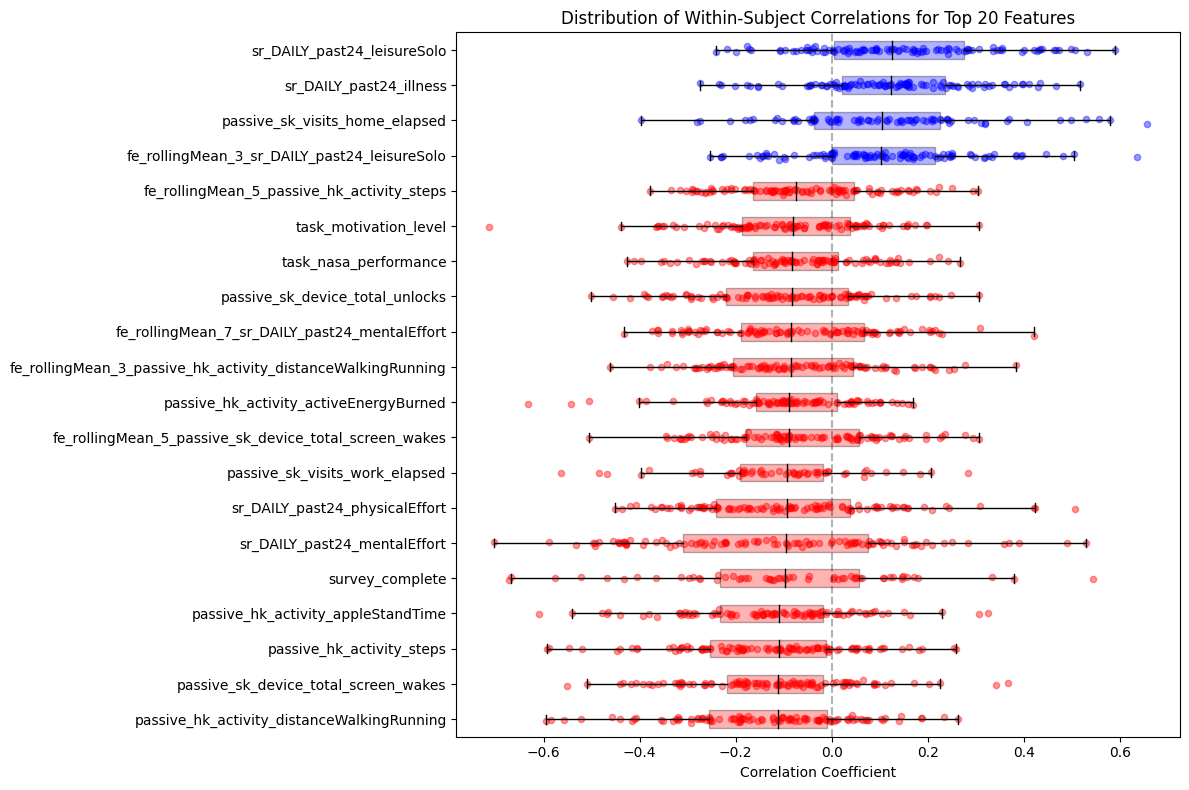

In [ ]:
# Visualize distribution of correlations for top features
plt.figure(figsize=(12, 8)) 

# Sort features by absolute mean correlation and get top 20
top_features = correlations_df.sort_values('median_correlation', key=abs, ascending=False)[:20].index.tolist()

# Create box plot data and calculate medians
box_data = []
labels = []
medians = []
for feature in top_features:
    subject_correlations = []
    for pid in df['PID'].unique():
        subject_mask = df['PID'] == pid
        subject_data = df[subject_mask][[feature, 'target_wbw_gap_detrended']].dropna()
        
        # Only calculate correlation if enough observations and variation
        if (len(subject_data) >= 30 and 
            subject_data[feature].nunique() > 1 and 
            subject_data['target_wbw_gap_detrended'].nunique() > 1 and
            subject_data[feature].std() > 0 and 
            subject_data['target_wbw_gap_detrended'].std() > 0):
            
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    corr = pearsonr(subject_data[feature], subject_data['target_wbw_gap_detrended'])[0]
                    if not np.isnan(corr):
                        subject_correlations.append(corr)
            except:
                continue
                
    box_data.append(subject_correlations)
    # Use full feature name instead of shortened version
    labels.append(feature)
    medians.append(np.median(subject_correlations))

# Sort everything by median correlation
sorted_indices = np.argsort(medians)
box_data = [box_data[i] for i in sorted_indices]
labels = [labels[i] for i in sorted_indices]
medians = [medians[i] for i in sorted_indices]

# Create color map based on median values
colors = ['red' if m < 0 else 'blue' for m in medians]

# Create the box plot
bp = plt.boxplot(box_data, 
                 labels=labels, 
                 vert=False,
                 patch_artist=True,  # Required for filling boxplot
                 medianprops=dict(color="black"),  # Make median lines black
                 flierprops=dict(marker='none'))  # Hide outlier points (we'll plot all points)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)

# Add individual points
for i, data in enumerate(box_data):
    # Spread out y-coordinates for better visibility
    y_spread = np.random.normal(i + 1, 0.04, size=len(data))
    plt.scatter(data, y_spread, alpha=0.4, color=colors[i], s=20)

plt.title('Distribution of Within-Subject Correlations for Top 20 Features')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)  # Add zero line
plt.tight_layout()
plt.show()

In [151]:
correlations_df.set_index('index', inplace=True)
correlations_df.reset_index(inplace=True, names=['feature'])

In [152]:
correlations_df = correlations_df.sort_values('median_correlation', key=abs, ascending=False).reset_index(drop=True)

correlations_df.loc[correlations_df['feature'].str.contains('task_drift|task_css')]

,feature,median_correlation,std_correlation,mean_correlation,num_subjects,total_observations
779,task_css,-0.011444,0.140002,-0.028939,104,7229
849,task_drift,-0.009881,0.148837,-0.044808,104,7106


### Sanity Checks

In [399]:
sr_cols

['sr_DAILY_next24_drinks',
 'sr_DAILY_next24_exercise',
 'sr_DAILY_next24_leisureNonSolo',
 'sr_DAILY_next24_leisureSolo',
 'sr_DAILY_next24_sleep',
 'sr_DAILY_next24_socialMedia',
 'sr_DAILY_past24_diet',
 'sr_DAILY_past24_drinks',
 'sr_DAILY_past24_exercise',
 'sr_DAILY_past24_fatigue',
 'sr_DAILY_past24_illness',
 'sr_DAILY_past24_leisureNonSolo',
 'sr_DAILY_past24_leisureNonSoloMental',
 'sr_DAILY_past24_leisureNonSoloPhysical',
 'sr_DAILY_past24_leisureSolo',
 'sr_DAILY_past24_leisureSoloMental',
 'sr_DAILY_past24_leisureSoloPhysical',
 'sr_DAILY_past24_mentalEffort',
 'sr_DAILY_past24_physicalEffort',
 'sr_DAILY_past24_sleep',
 'sr_DAILY_past24_socialMedia',
 'sr_DAILY_past24_unusualEvents',
 'sr_DAILY_gap_diet',
 'sr_DAILY_gap_sleep',
 'sr_DAILY_gap_leisureSolo',
 'sr_DAILY_gap_leisureNonSolo',
 'sr_DAILY_gap_exercise',
 'sr_DAILY_gap_socialMedia',
 'sr_DAILY_gap_drinks',
 'fe_lag_1_sr_DAILY_next24_drinks',
 'fe_lag_2_sr_DAILY_next24_drinks',
 'fe_lag_3_sr_DAILY_next24_drinks',


In [450]:
target = 'target_wbw_gap_detrended'

# Initialize empty lists to store results
results_list = []

# Filter sr_cols to exclude feature engineered columns
base_cols = [col for col in passive_cols if not col.startswith('fe_')]

# Iterate through each predictor
for predictor in base_cols:
    try:
        # Fit model and get predictions
        model, predictions, test_actual, test_data_clean = fit_and_predict_mlm(
            train_data=train_data,
            test_data=test_data,
            predictors=[predictor],
            target=target,
            random_intercepts=True
        )
        
        # Calculate metrics
        results = calculate_metrics(
            model=model,
            predicted_vals=predictions,
            actual_vals=test_actual,
            test_data_clean=test_data_clean,
            train_data=train_data,
            target=target
        )
        
        # Extract metrics for this predictor
        results_list.append({
            'feature': predictor,
            'rmse': results['rmse'].iloc[0],
            'mae': results['mae'].iloc[0],
            'median_accuracy': results['median_accuracy'].iloc[0],
            'median_ci_lower': results['median_ci_lower'].iloc[0],
            'median_ci_upper': results['median_ci_upper'].iloc[0],
            'high_pred_median_accuracy': results['high_pred_median_accuracy'].iloc[0],
            'high_pred_median_ci_lower': results['high_pred_median_ci_lower'].iloc[0],
            'high_pred_median_ci_upper': results['high_pred_median_ci_upper'].iloc[0],
            'n_observations': len(test_actual),  # Add number of observations
            'n_groups': len(test_data_clean['PID'].unique())  # Add number of groups/subjects
        })
        
    except Exception as e:
        print(f"Error processing {predictor}: {str(e)}")
        continue

# Create DataFrame and sort by median accuracy
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('median_accuracy', ascending=False)

# Display results with formatted percentages for accuracies
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
print("\nResults sorted by Above/Below Median Accuracy:")
print(results_df.to_string(index=False))

Model converged using lbfgs optimizer
                            Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         target_wbw_gap_detrended
No. Observations:         5097            Method:                     REML                    
No. Groups:               102             Scale:                      190.4166                
Min. group size:          3               Log-Likelihood:             -20834.3264             
Max. group size:          61              Converged:                  Yes                     
Mean group size:          50.0                                                                
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:154: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)


Model Performance Metrics:
MAE: 9.5534
RMSE: 12.6163
R²: 0.5396

Categorical Metrics:
Above/Below Median, Accuracy: 54.14%
Above/Below Median, 95% CI: [51.02%, 57.25%]
Above/Below Training Data Median, Accuracy: 50.79%
Above/Below Training Data Median, 95% CI: [49.57%, 52.03%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.65% [95% CI: 65.73%, 71.37%]
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 52.66%
Day-to-Day Change Direction, 95% CI: [49.07%, 56.12%]

Transition Prediction Metrics:
Number of actual transitions: 24
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 149.6765
Average variance of predictions across PIDs: 0.1041
Model converged using lbfgs optimizer
                    Mixed Linear Model Regres

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 8.2638
RMSE: 10.8325
R²: 0.6376

Categorical Metrics:
Above/Below Median, Accuracy: 60.19%
Above/Below Median, 95% CI: [50.93%, 69.44%]
Above/Below Training Data Median, Accuracy: 52.44%
Above/Below Training Data Median, 95% CI: [51.19%, 53.70%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 74.07% [95% CI: 65.74%, 82.41%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 64.52%
Day-to-Day Change Direction, 95% CI: [53.23%, 75.81%]

Transition Prediction Metrics:
Number of actual transitions: 7
Number of predicted transitions: 2
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 55.0357
Average variance of predictions across PIDs: 0.2005
Model did not converge with lbfgs optimizer, trying next...
Model converged using nm o

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:154: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)


Model Performance Metrics:
MAE: 9.2357
RMSE: 12.6352
R²: 0.4888

Categorical Metrics:
Above/Below Median, Accuracy: 57.08%
Above/Below Median, 95% CI: [51.82%, 61.42%]
Above/Below Training Data Median, Accuracy: 50.31%
Above/Below Training Data Median, 95% CI: [49.12%, 51.53%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 67.12% [95% CI: 62.79%, 71.69%]
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 70.28%
Day-to-Day Change Direction, 95% CI: [65.33%, 74.92%]

Transition Prediction Metrics:
Number of actual transitions: 68
Number of predicted transitions: 1
Precision: 100.00% [95% CI: 0.00%, 100.00%]
Recall: 1.47% [95% CI: 0.00%, 4.84%]
F1 Score: 2.90% [95% CI: 0.00%, 9.23%]

Variance Analysis:
Average actual variance across PIDs: 156.3107
Average variance of predictions across PIDs: 0.7961
Model converged using lbfgs optimizer
                              Mixed Linea

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:154: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)


Model Performance Metrics:
MAE: 9.2761
RMSE: 12.6714
R²: 0.4867

Categorical Metrics:
Above/Below Median, Accuracy: 55.84%
Above/Below Median, 95% CI: [50.80%, 60.64%]
Above/Below Training Data Median, Accuracy: 51.64%
Above/Below Training Data Median, 95% CI: [50.34%, 52.91%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 67.28% [95% CI: 62.70%, 71.62%]
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 59.44%
Day-to-Day Change Direction, 95% CI: [54.18%, 64.71%]

Transition Prediction Metrics:
Number of actual transitions: 68
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.3220
Average variance of predictions across PIDs: 0.9579
Model converged using lbfgs optimizer
                              Mixed Linear Mo

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:154: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)


Model Performance Metrics:
MAE: 9.2474
RMSE: 12.6543
R²: 0.4873

Categorical Metrics:
Above/Below Median, Accuracy: 54.34%
Above/Below Median, 95% CI: [49.54%, 59.14%]
Above/Below Training Data Median, Accuracy: 51.58%
Above/Below Training Data Median, 95% CI: [50.31%, 52.75%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 67.35% [95% CI: 62.33%, 71.69%]
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 45.20%
Day-to-Day Change Direction, 95% CI: [39.63%, 50.46%]

Transition Prediction Metrics:
Number of actual transitions: 68
Number of predicted transitions: 1
Precision: 100.00% [95% CI: 0.00%, 100.00%]
Recall: 1.47% [95% CI: 0.00%, 4.69%]
F1 Score: 2.90% [95% CI: 0.00%, 8.96%]

Variance Analysis:
Average actual variance across PIDs: 156.3107
Average variance of predictions across PIDs: 0.5610
Model converged using lbfgs optimizer
                         Mixed Linear Mod

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:28: RuntimeWarning: invalid value encountered in scalar divide
  r2 = 1 - (np.sum((actual_vals - predicted_vals)**2) / np.sum((actual_vals - actual_vals.mean())**2))
/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:40: RuntimeWarning: divide by zero encountered in log
  bic = k*np.log(n) - 2*ll  # BIC
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/djw/Documents/pCloud_

Model Performance Metrics:
MAE: nan
RMSE: nan
R²: nan

Categorical Metrics:
Above/Below Median, Accuracy: nan%
Above/Below Median, 95% CI: [nan%, nan%]
Above/Below Training Data Median, Accuracy: 52.98%
Above/Below Training Data Median, 95% CI: [51.82%, 54.26%]

High Gap Classification Metrics (Top Tercile):
Accuracy: nan% [95% CI: nan%, nan%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: nan% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: nan%
Day-to-Day Change Direction, 95% CI: [nan%, nan%]

Transition Prediction Metrics:
Number of actual transitions: 0.0
Number of predicted transitions: 0.0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: nan
Average variance of predictions across PIDs: nan
Model converged using lbfgs optimizer
                          Mixed Linear Model Regression Results
Model:          

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling

Model Performance Metrics:
MAE: 8.8109
RMSE: 12.2727
R²: 0.4009

Categorical Metrics:
Above/Below Median, Accuracy: 58.81%
Above/Below Median, 95% CI: [53.43%, 64.18%]
Above/Below Training Data Median, Accuracy: 51.46%
Above/Below Training Data Median, 95% CI: [50.21%, 52.77%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 69.25% [95% CI: 64.47%, 74.03%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 4.62%
Day-to-Day Change Direction, 95% CI: [2.10%, 7.56%]

Transition Prediction Metrics:
Number of actual transitions: 53
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 144.3666
Average variance of predictions across PIDs: 0.0000
Model converged using lbfgs optimizer
                          Mixed Linear Model Regr

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 8.7442
RMSE: 12.1897
R²: 0.4090

Categorical Metrics:
Above/Below Median, Accuracy: 60.60%
Above/Below Median, 95% CI: [55.22%, 65.67%]
Above/Below Training Data Median, Accuracy: 51.58%
Above/Below Training Data Median, 95% CI: [50.39%, 52.85%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 69.25% [95% CI: 64.48%, 73.73%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 67.23%
Day-to-Day Change Direction, 95% CI: [61.34%, 73.11%]

Transition Prediction Metrics:
Number of actual transitions: 53
Number of predicted transitions: 14
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 144.3666
Average variance of predictions across PIDs: 1.0907
Model converged using lbfgs optimizer
                            Mixed Linear Mode

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.1151
RMSE: 12.4583
R²: 0.5031

Categorical Metrics:
Above/Below Median, Accuracy: 56.50%
Above/Below Median, 95% CI: [52.02%, 61.44%]
Above/Below Training Data Median, Accuracy: 50.88%
Above/Below Training Data Median, 95% CI: [49.60%, 52.12%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.61% [95% CI: 64.13%, 72.65%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 49.53%
Day-to-Day Change Direction, 95% CI: [44.20%, 54.87%]

Transition Prediction Metrics:
Number of actual transitions: 51
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 149.4624
Average variance of predictions across PIDs: 0.0828
Model converged using lbfgs optimizer
                      Mixed Linear Model Regre

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2118
RMSE: 12.5604
R²: 0.4932

Categorical Metrics:
Above/Below Median, Accuracy: 54.92%
Above/Below Median, 95% CI: [50.34%, 59.73%]
Above/Below Training Data Median, Accuracy: 51.77%
Above/Below Training Data Median, 95% CI: [50.61%, 53.01%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.65% [95% CI: 64.53%, 72.77%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 50.33%
Day-to-Day Change Direction, 95% CI: [44.76%, 55.88%]

Transition Prediction Metrics:
Number of actual transitions: 51
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 149.7920
Average variance of predictions across PIDs: 0.1524
Model converged using lbfgs optimizer
                         Mixed Linear Model Re

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2266
RMSE: 12.6500
R²: 0.4766

Categorical Metrics:
Above/Below Median, Accuracy: 54.32%
Above/Below Median, 95% CI: [50.00%, 59.06%]
Above/Below Training Data Median, Accuracy: 50.32%
Above/Below Training Data Median, 95% CI: [49.16%, 51.63%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.52% [95% CI: 64.61%, 72.63%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 43.84%
Day-to-Day Change Direction, 95% CI: [38.90%, 48.77%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.0410
Average variance of predictions across PIDs: 0.1778
Model converged using lbfgs optimizer
                               Mixed Linear Mo

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2167
RMSE: 12.6243
R²: 0.4806

Categorical Metrics:
Above/Below Median, Accuracy: 56.20%
Above/Below Median, 95% CI: [51.65%, 60.54%]
Above/Below Training Data Median, Accuracy: 50.74%
Above/Below Training Data Median, 95% CI: [49.58%, 52.03%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.39% [95% CI: 64.26%, 72.31%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 51.37%
Day-to-Day Change Direction, 95% CI: [46.43%, 56.33%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 157.1958
Average variance of predictions across PIDs: 0.0061
Model converged using lbfgs optimizer
                                Mixed Linear M

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2175
RMSE: 12.6207
R²: 0.4809

Categorical Metrics:
Above/Below Median, Accuracy: 55.79%
Above/Below Median, 95% CI: [51.45%, 60.33%]
Above/Below Training Data Median, Accuracy: 50.64%
Above/Below Training Data Median, 95% CI: [49.34%, 51.93%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.60% [95% CI: 64.26%, 72.73%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 3.03%
Day-to-Day Change Direction, 95% CI: [1.38%, 4.96%]

Transition Prediction Metrics:
Number of actual transitions: 59
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 157.1183
Average variance of predictions across PIDs: 0.0233
Model converged using lbfgs optimizer
                                 Mixed Linear Mod

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:154: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)


Model Performance Metrics:
MAE: 9.1585
RMSE: 12.5555
R²: 0.4841

Categorical Metrics:
Above/Below Median, Accuracy: 54.75%
Above/Below Median, 95% CI: [50.83%, 58.88%]
Above/Below Training Data Median, Accuracy: 50.71%
Above/Below Training Data Median, 95% CI: [49.47%, 51.93%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.39% [95% CI: 64.26%, 72.53%]
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 1.66%
Day-to-Day Change Direction, 95% CI: [0.55%, 3.05%]

Transition Prediction Metrics:
Number of actual transitions: 61
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 154.8427
Average variance of predictions across PIDs: 0.1689
Model converged using lbfgs optimizer
                               Mixed Linear Mode

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2387
RMSE: 12.6395
R²: 0.4777

Categorical Metrics:
Above/Below Median, Accuracy: 55.37%
Above/Below Median, 95% CI: [51.03%, 59.92%]
Above/Below Training Data Median, Accuracy: 50.55%
Above/Below Training Data Median, 95% CI: [49.24%, 51.82%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.39% [95% CI: 64.26%, 72.73%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 2.76%
Day-to-Day Change Direction, 95% CI: [1.10%, 4.70%]

Transition Prediction Metrics:
Number of actual transitions: 60
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.0257
Average variance of predictions across PIDs: 0.0114
Model converged using lbfgs optimizer
                           Mixed Linear Model Reg

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.1740
RMSE: 12.5790
R²: 0.4836

Categorical Metrics:
Above/Below Median, Accuracy: 55.99%
Above/Below Median, 95% CI: [51.44%, 60.54%]
Above/Below Training Data Median, Accuracy: 49.71%
Above/Below Training Data Median, 95% CI: [48.63%, 51.05%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.80% [95% CI: 64.88%, 72.93%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 53.87%
Day-to-Day Change Direction, 95% CI: [48.90%, 58.84%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.3714
Average variance of predictions across PIDs: 0.3085
Model converged using lbfgs optimizer
                            Mixed Linear Model

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling

Model Performance Metrics:
MAE: 9.2043
RMSE: 12.5999
R²: 0.4807

Categorical Metrics:
Above/Below Median, Accuracy: 56.38%
Above/Below Median, 95% CI: [52.06%, 60.91%]
Above/Below Training Data Median, Accuracy: 50.72%
Above/Below Training Data Median, 95% CI: [49.47%, 51.98%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.52% [95% CI: 64.60%, 72.84%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 1.64%
Day-to-Day Change Direction, 95% CI: [0.55%, 3.01%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.0410
Average variance of predictions across PIDs: 0.0000
Model converged using lbfgs optimizer
                             Mixed Linear Model R

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2881
RMSE: 12.7185
R²: 0.4681

Categorical Metrics:
Above/Below Median, Accuracy: 55.99%
Above/Below Median, 95% CI: [51.45%, 60.54%]
Above/Below Training Data Median, Accuracy: 49.71%
Above/Below Training Data Median, 95% CI: [48.41%, 50.93%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.39% [95% CI: 64.05%, 72.52%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 56.08%
Day-to-Day Change Direction, 95% CI: [51.10%, 61.05%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 157.4507
Average variance of predictions across PIDs: 1.9065
Model converged using lbfgs optimizer
                           Mixed Linear Model 

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2144
RMSE: 12.6090
R²: 0.4810

Categorical Metrics:
Above/Below Median, Accuracy: 55.26%
Above/Below Median, 95% CI: [50.92%, 59.59%]
Above/Below Training Data Median, Accuracy: 50.68%
Above/Below Training Data Median, 95% CI: [49.47%, 51.95%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.45% [95% CI: 64.12%, 72.58%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 69.42%
Day-to-Day Change Direction, 95% CI: [64.73%, 73.84%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 155.7645
Average variance of predictions across PIDs: 0.0436
Model converged using lbfgs optimizer
                            Mixed Linear Model

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.1990
RMSE: 12.5985
R²: 0.4809

Categorical Metrics:
Above/Below Median, Accuracy: 56.38%
Above/Below Median, 95% CI: [51.85%, 60.70%]
Above/Below Training Data Median, Accuracy: 50.88%
Above/Below Training Data Median, 95% CI: [49.71%, 52.12%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.52% [95% CI: 64.40%, 72.63%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 1.64%
Day-to-Day Change Direction, 95% CI: [0.55%, 3.01%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.0410
Average variance of predictions across PIDs: 0.0058
Model converged using lbfgs optimizer
                               Mixed Linear Model

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.3140
RMSE: 12.7347
R²: 0.4751

Categorical Metrics:
Above/Below Median, Accuracy: 53.78%
Above/Below Median, 95% CI: [49.15%, 57.98%]
Above/Below Training Data Median, Accuracy: 50.77%
Above/Below Training Data Median, 95% CI: [49.49%, 52.08%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.28% [95% CI: 64.29%, 72.27%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 30.66%
Day-to-Day Change Direction, 95% CI: [25.79%, 35.82%]

Transition Prediction Metrics:
Number of actual transitions: 60
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 157.3946
Average variance of predictions across PIDs: 0.1561
Model converged using lbfgs optimizer
                           Mixed Linear Model 

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2319
RMSE: 12.6417
R²: 0.4789

Categorical Metrics:
Above/Below Median, Accuracy: 55.58%
Above/Below Median, 95% CI: [51.24%, 60.12%]
Above/Below Training Data Median, Accuracy: 51.13%
Above/Below Training Data Median, 95% CI: [49.98%, 52.27%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.60% [95% CI: 64.26%, 72.73%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 1.65%
Day-to-Day Change Direction, 95% CI: [0.55%, 3.03%]

Transition Prediction Metrics:
Number of actual transitions: 64
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 155.9813
Average variance of predictions across PIDs: 0.1689
Model converged using lbfgs optimizer
                                Mixed Linear Mode

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.1715
RMSE: 12.5617
R²: 0.4849

Categorical Metrics:
Above/Below Median, Accuracy: 56.70%
Above/Below Median, 95% CI: [52.37%, 61.04%]
Above/Below Training Data Median, Accuracy: 50.72%
Above/Below Training Data Median, 95% CI: [49.55%, 51.98%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.66% [95% CI: 64.32%, 72.78%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 44.08%
Day-to-Day Change Direction, 95% CI: [38.84%, 49.04%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 155.3918
Average variance of predictions across PIDs: 0.0459
Model converged using lbfgs optimizer
                            Mixed Linear Model

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:154: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)


Model Performance Metrics:
MAE: 9.2883
RMSE: 12.7150
R²: 0.4728

Categorical Metrics:
Above/Below Median, Accuracy: 56.13%
Above/Below Median, 95% CI: [51.76%, 60.50%]
Above/Below Training Data Median, Accuracy: 51.64%
Above/Below Training Data Median, 95% CI: [50.40%, 52.80%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.40% [95% CI: 64.24%, 72.56%]
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 42.58%
Day-to-Day Change Direction, 95% CI: [37.82%, 47.34%]

Transition Prediction Metrics:
Number of actual transitions: 61
Number of predicted transitions: 5
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 155.9913
Average variance of predictions across PIDs: 0.9131
Model converged using lbfgs optimizer
                                 Mixed Linear

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2331
RMSE: 12.6173
R²: 0.4793

Categorical Metrics:
Above/Below Median, Accuracy: 56.38%
Above/Below Median, 95% CI: [52.05%, 60.70%]
Above/Below Training Data Median, Accuracy: 50.42%
Above/Below Training Data Median, 95% CI: [49.15%, 51.69%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.52% [95% CI: 64.40%, 72.43%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 1.64%
Day-to-Day Change Direction, 95% CI: [0.55%, 3.01%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.0410
Average variance of predictions across PIDs: 0.4136
Model converged using lbfgs optimizer
                           Mixed Linear Model Reg

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.1835
RMSE: 12.5613
R²: 0.4836

Categorical Metrics:
Above/Below Median, Accuracy: 55.51%
Above/Below Median, 95% CI: [50.94%, 60.08%]
Above/Below Training Data Median, Accuracy: 51.48%
Above/Below Training Data Median, 95% CI: [50.32%, 52.73%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.19% [95% CI: 64.24%, 72.14%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 68.63%
Day-to-Day Change Direction, 95% CI: [63.87%, 73.39%]

Transition Prediction Metrics:
Number of actual transitions: 62
Number of predicted transitions: 3
Precision: 33.33% [95% CI: 0.00%, 100.00%]
Recall: 1.61% [95% CI: 0.00%, 5.56%]
F1 Score: 3.08% [95% CI: 0.00%, 10.17%]

Variance Analysis:
Average actual variance across PIDs: 156.3773
Average variance of predictions across PIDs: 0.2621
Model converged using lbfgs optimizer
                             Mixed Linear 

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:154: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)


Model Performance Metrics:
MAE: 9.1954
RMSE: 12.5871
R²: 0.4829

Categorical Metrics:
Above/Below Median, Accuracy: 57.73%
Above/Below Median, 95% CI: [53.40%, 62.47%]
Above/Below Training Data Median, Accuracy: 49.81%
Above/Below Training Data Median, 95% CI: [48.73%, 50.96%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.25% [95% CI: 63.91%, 72.38%]
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 62.81%
Day-to-Day Change Direction, 95% CI: [58.13%, 67.77%]

Transition Prediction Metrics:
Number of actual transitions: 70
Number of predicted transitions: 2
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 156.5913
Average variance of predictions across PIDs: 0.2212
Model converged using lbfgs optimizer
                            Mixed Linear Mode

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_46726/2939446397.py:152: RuntimeWarning: invalid value encountered in scalar divide
  high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance Metrics:
MAE: 9.2724
RMSE: 12.6648
R²: 0.4825

Categorical Metrics:
Above/Below Median, Accuracy: 55.46%
Above/Below Median, 95% CI: [51.05%, 59.87%]
Above/Below Training Data Median, Accuracy: 50.56%
Above/Below Training Data Median, 95% CI: [49.36%, 51.79%]

High Gap Classification Metrics (Top Tercile):
Accuracy: 68.70% [95% CI: 64.70%, 72.90%]
Precision: nan% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: nan% [95% CI: 0.00%, 0.00%]

Day-to-Day Change Direction Accuracy: 57.67%
Day-to-Day Change Direction, 95% CI: [52.27%, 62.50%]

Transition Prediction Metrics:
Number of actual transitions: 50
Number of predicted transitions: 0
Precision: 0.00% [95% CI: 0.00%, 0.00%]
Recall: 0.00% [95% CI: 0.00%, 0.00%]
F1 Score: 0.00% [95% CI: 0.00%, 0.00%]

Variance Analysis:
Average actual variance across PIDs: 158.5998
Average variance of predictions across PIDs: 0.0468
Model converged using lbfgs optimizer
                       Mixed Linear Model Regr

In [451]:
results_df.loc[results_df['n_observations'] > 1000]

,feature,rmse,mae,median_accuracy,median_ci_lower,median_ci_upper,high_pred_median_accuracy,high_pred_median_ci_lower,high_pred_median_ci_upper,n_observations,n_groups
1,passive_hk_activity_appleStandTime,12.384,9.390,0.565,0.536,0.594,1.000,1.000,1.000,1039,93
2,passive_hk_activity_distanceWalkingRunning,12.573,9.332,0.554,0.527,0.580,1.000,1.000,1.000,1442,104
4,passive_hk_activity_steps,12.583,9.339,0.551,0.525,0.578,1.000,1.000,1.000,1441,104
0,passive_hk_activity_activeEnergyBurned,12.699,9.566,0.550,0.520,0.581,1.000,1.000,1.000,1136,95
6,passive_hk_hr_variability,12.616,9.553,0.541,0.510,0.573,1.000,1.000,1.000,1027,93
5,passive_hk_activity_averageWalkingSpeed,12.849,9.519,0.541,0.513,0.568,1.000,1.000,1.000,1198,102
88,watch_wearing,4676854.250,243954.654,0.540,0.511,0.566,1.000,1.000,1.000,1449,104
87,tasks_complete,2803594.553,164589.101,0.538,0.513,0.564,1.000,1.000,1.000,1449,104
84,task_start_time,12.345,9.200,0.536,0.510,0.562,1.000,1.000,1.000,1419,104
86,survey_complete,4170505.703,124693.966,0.535,0.509,0.561,1.000,1.000,1.000,1449,104


Model converged using lbfgs optimizer
                          Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       target_wbw_gap_detrended
No. Observations:         4867          Method:                   REML                    
No. Groups:               102           Scale:                    183.8775                
Min. group size:          4             Log-Likelihood:           -19825.9662             
Max. group size:          61            Converged:                Yes                     
Mean group size:          47.7                                                            
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       38.556    1.299 29.670 0.000 36

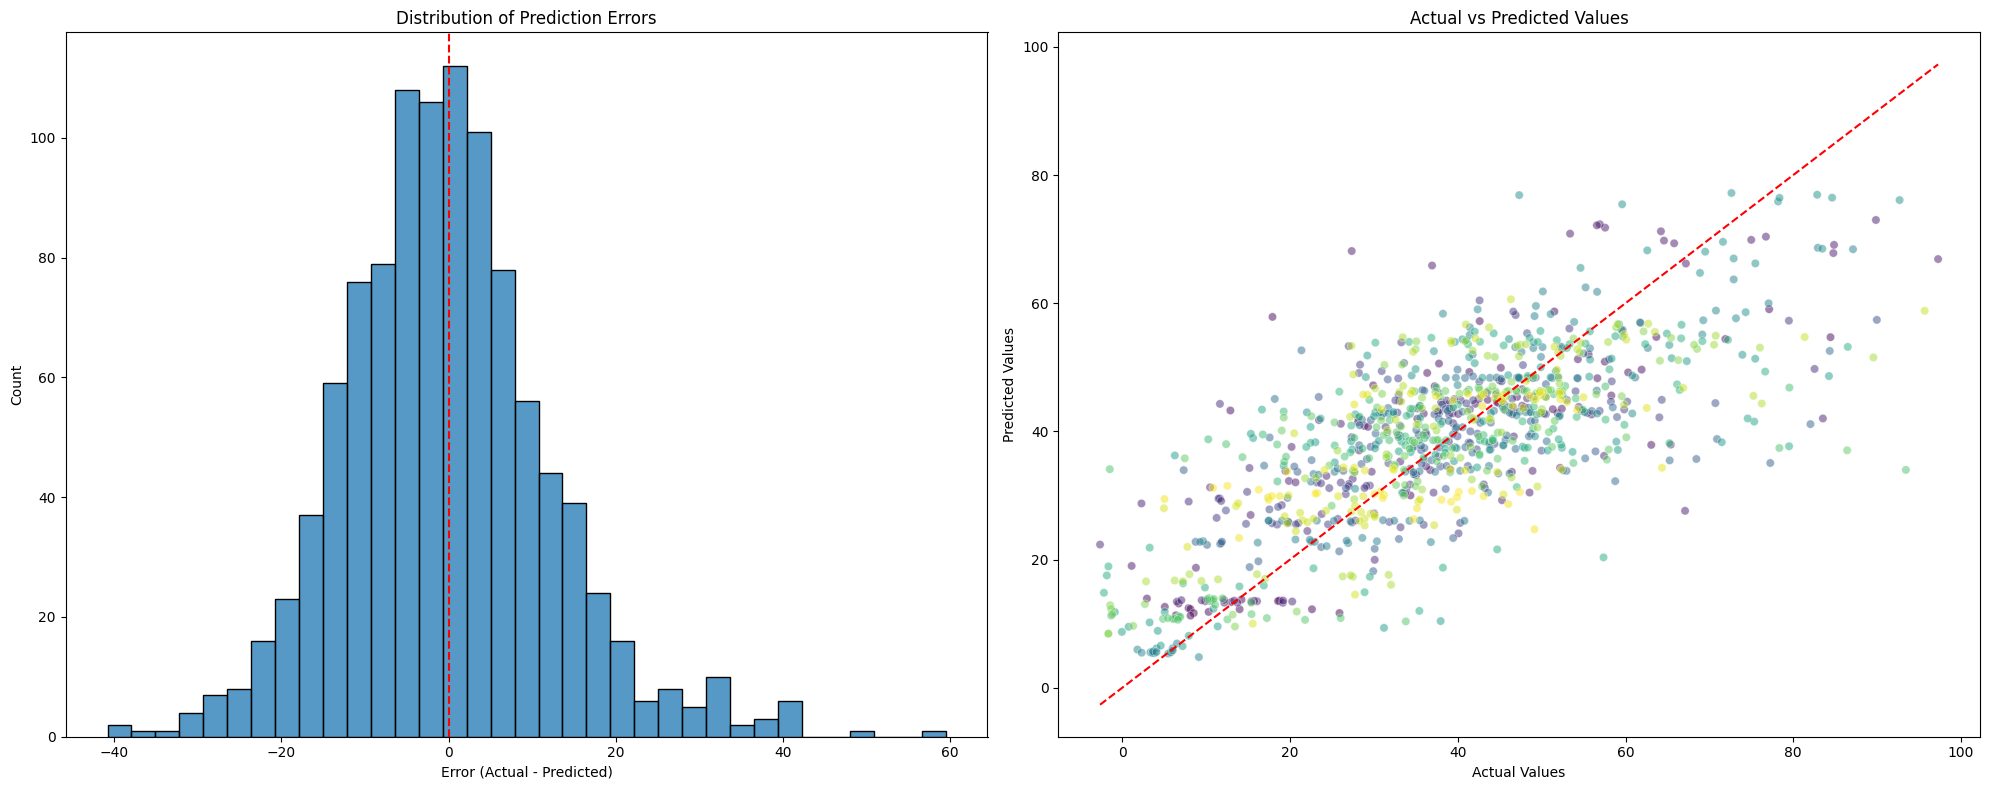

In [445]:
# Get the first feature from the MLM results
predictors = ['passive_hk_activity_appleStandTime']
target = 'target_wbw_gap_detrended'

model, predictions, test_actual, test_data_clean = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results_df = calculate_metrics(model, predictions, test_actual, test_data_clean, train_data, target=target)

plot_model_diagnostics(test_actual, predictions, test_data_clean)

# MLM

In [ ]:
# Filter subjects based on data availability
def filter_subjects_by_data_availability(data, features, min_pct=0.5):
    """
    Filter subjects who have data for all features on at least min_pct of days
    
    Args:
        data (pd.DataFrame): DataFrame containing the data
        features (list): List of feature names to check
        min_pct (float): Minimum percentage of days required (0-1)
        
    Returns:
        list: List of subject IDs meeting the criteria
    """
    valid_subjects = []
    
    for pid in data['PID'].unique():
        subject_data = data[data['PID'] == pid]
        total_days = len(subject_data)
        
        # Check each feature
        feature_completeness = []
        for feature in features:
            valid_days = subject_data[feature].notna().sum()
            pct_valid = valid_days / total_days
            feature_completeness.append(pct_valid >= min_pct)
        
        # Subject needs all features to meet threshold
        if all(feature_completeness):
            valid_subjects.append(pid)
            
    return valid_subjects

In [228]:
def fit_and_predict_mlm_multiple(train_data, test_data, n_predictors, top_features, target='target_wbw_gap_detrended', random_intercepts=True):
    """
    Fit MLM models with multiple predictors and evaluate performance.
    
    Parameters:
    -----------
    train_data, test_data : pd.DataFrame
        Training and test datasets
    n_predictors : int
        Number of predictors to use in each model (2 or 3)
    top_features : list
        Ordered list of features to consider for combinations
    target : str
        Target column name
    random_intercepts : bool
        Whether to include random intercepts in the model
    """
    # Generate all possible combinations
    feature_combinations = list(combinations(top_features, n_predictors))
    
    # Initialize results storage
    results = []
    
    # Define optimizers to try in order of preference
    optimizers = [
        ('lbfgs', {'maxiter': 2000}),
        ('nm', {'maxiter': 1000}),
        ('cg', {'maxiter': 2000}),
        ('powell', {'maxiter': 2000})
    ]
    
    for features in tqdm(feature_combinations):
        # Filter subjects based on data availability
        train_valid_subjects = filter_subjects_by_data_availability(train_data, features)
        test_valid_subjects = filter_subjects_by_data_availability(test_data, features)
        valid_subjects = list(set(train_valid_subjects) & set(test_valid_subjects))
        
        # Filter data to only include valid subjects
        train_data_clean = train_data[train_data['PID'].isin(valid_subjects)].copy()
        test_data_clean = test_data[test_data['PID'].isin(valid_subjects)].copy()
        
        # Further clean data by removing rows with NaN in features or target
        train_data_clean = train_data_clean[list(features) + [target, 'PID']].dropna()
        
        # Calculate training data statistics for normalization
        train_stats = {}
        for feature in features:
            train_stats[feature] = train_data_clean.groupby('PID')[feature].agg(['mean', 'std'])
            train_stats[feature]['std'] = train_stats[feature]['std'].replace(0, 1e-8)
            
            # Normalize training data
            for pid in train_data_clean['PID'].unique():
                mask = train_data_clean['PID'] == pid
                mean = train_stats[feature].loc[pid, 'mean']
                std = train_stats[feature].loc[pid, 'std']
                train_data_clean.loc[mask, feature] = (train_data_clean.loc[mask, feature] - mean) / std
        
        # Remove any NaN values that were introduced by normalization
        train_data_clean = train_data_clean.dropna()
        
        # Build formula string with all predictors
        predictor_formula = " + ".join(features)
        
        # Try different optimizers until one succeeds
        model = None
        converged = False
        optimizer_used = None
        
        for optimizer, settings in optimizers:
            try:
                if random_intercepts:
                    md = smf.mixedlm(
                        f"{target} ~ 1 + {predictor_formula}",
                        train_data_clean,
                        groups=train_data_clean["PID"],
                        re_formula=f"1 + {predictor_formula}"
                    )
                else:
                    md = smf.mixedlm(
                        f"{target} ~ 1 + {predictor_formula}",
                        train_data_clean,
                        groups=train_data_clean["PID"],
                        re_formula=f"0 + {predictor_formula}"
                    )
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    model = md.fit(method=optimizer, **settings)
                
                if hasattr(model, 'converged') and model.converged:
                    converged = True
                    optimizer_used = optimizer
                    break
                else:
                    model = None
                    
            except Exception:
                continue
        
        if model is None:
            continue
            
        # Prepare test data
        test_data_clean = test_data_clean[list(features) + [target, 'PID']].dropna()
        
        # Normalize test data using training statistics
        for feature in features:
            for pid in test_data_clean['PID'].unique():
                mask = test_data_clean['PID'] == pid
                if pid in train_stats[feature].index:
                    mean = train_stats[feature].loc[pid, 'mean']
                    std = train_stats[feature].loc[pid, 'std']
                    test_data_clean.loc[mask, feature] = (test_data_clean.loc[mask, feature] - mean) / std
        
        # Remove any NaN values that were introduced by normalization
        test_data_clean = test_data_clean.dropna()
        
        predictions = np.zeros(len(test_data_clean))
        random_effects = model.random_effects
        
        for pid in test_data_clean['PID'].unique():
            mask = test_data_clean['PID'] == pid
            subject_data = test_data_clean[mask]
            
            if pid in random_effects:
                re_slopes = {feat: random_effects[pid].get(feat, 0) for feat in features}
                re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
            else:
                re_slopes = {feat: 0 for feat in features}
                re_intercept = 0
            
            if random_intercepts:
                fixed_intercept = model.params.get('Intercept', 0)
                pred = fixed_intercept + re_intercept
                for feature in features:
                    pred += (model.params[feature] + re_slopes[feature]) * subject_data[feature]
                predictions[mask] = pred
            else:
                pred = np.zeros(len(subject_data))
                for feature in features:
                    pred += (model.params[feature] + re_slopes[feature]) * subject_data[feature]
                predictions[mask] = pred
        
        # Calculate metrics
        test_actual = test_data_clean[target]
        mae = np.mean(np.abs(test_actual - predictions))
        rmse = np.sqrt(np.mean((test_actual - predictions)**2))
        
        # Calculate ll, AIC and BIC for test data
        n = len(test_actual)
        k = len(model.params)
        mse = np.mean((test_actual - predictions)**2)
        ll = -n/2 * (np.log(2*np.pi) + np.log(mse) + 1)
        aic = 2*k - 2*ll
        bic = k*np.log(n) - 2*ll
        
        # Store results
        result = {
            'mae': mae,
            'rmse': rmse,
            'log_likelihood': ll,
            'n_observations': n,
            'n_valid_subjects': len(valid_subjects),
            'aic': aic,
            'bic': bic,
            'converged': converged,
            'optimizer_used': optimizer_used
        }
        
        # Add features to result
        for i, feature in enumerate(features, 1):
            result[f'feature_{i}'] = feature
            
        results.append(result)
    
    # Convert to DataFrame and sort by RMSE
    results_df = pd.DataFrame(results).sort_values('rmse')
    
    return results_df

In [238]:
# Example usage:
n_features = 17
n_predictors = 3
n_combinations = calculate_combinations(n_features, n_predictors)
print(f"Number of possible combinations: {n_combinations}")

Number of possible combinations: 680


In [244]:
features = passive_cols

In [245]:
filtered_df = correlations_df[correlations_df['feature'].isin(features)]

In [247]:
list(filtered_df['feature'][0:17])

['passive_hk_activity_distanceWalkingRunning',
 'passive_sk_device_total_screen_wakes',
 'passive_hk_activity_steps',
 'passive_hk_activity_appleStandTime',
 'passive_sk_visits_home_elapsed',
 'survey_complete',
 'passive_sk_visits_work_elapsed',
 'fe_rollingMean_5_passive_sk_device_total_screen_wakes',
 'passive_hk_activity_activeEnergyBurned',
 'fe_rollingMean_3_passive_hk_activity_distanceWalkingRunning',
 'passive_sk_device_total_unlocks',
 'fe_rollingMean_5_passive_hk_activity_steps',
 'fe_lag_1_passive_sk_telephony_speakingRate_mean',
 'fe_rollingMean_5_passive_hk_activity_distanceWalkingRunning',
 'fe_rollingMean_3_passive_hk_activity_steps',
 'passive_sk_device_total_unlock_duration',
 'fe_rollingMean_3_passive_sk_device_total_unlock_duration']

In [ ]:
# feature_1 = 'passive_hk_activity_distanceWalkingRunning'
# feature_2 = 'passive_sk_device_total_screen_wakes'
# feature_3 = 'passive_hk_activity_averageWalkingSpeed'
# feature_4 = 'fe_rollingMean_3_passive_sk_device_total_unlock_duration'

In [239]:
# Fit all model combinations

# sort by median (alt = mean)
correlations_df = correlations_df.sort_values('median_correlation', key=abs, ascending=False).reset_index(drop=True)

# Define feature sets and their labels
feature_sets = {
    'passive': passive_cols,
    'self_report': sr_cols,
    #'task': task_cols,
    #'passive_sr': passive_cols + sr_cols,
    #'all': passive_cols + sr_cols + task_cols
}

# Initialize final results dataframe
final_results3 = pd.DataFrame()

# Iterate through feature sets
for modality, features in feature_sets.items():
    print(f"\nProcessing {modality} features...")
    
    # Filter correlations for current feature set
    filtered_df = correlations_df[correlations_df['feature'].isin(features)]
    
    # Create top features list
    top_features = list(filtered_df['feature'][0:17])
    
    # Get results for 4 predictors
    results = fit_and_predict_mlm_multiple(
        train_data=train_data,
        test_data=test_data,
        n_predictors=3,
        top_features=top_features,
        target='target_wbw_gap_detrended',
        random_intercepts=True
    )
    
    # Add data modality column
    results['data_modality'] = modality
    
    # Append to final results
    final_results3 = pd.concat([final_results3, results], ignore_index=True)


Processing passive features...


100%|██████████| 680/680 [1:38:10<00:00,  8.66s/it]  



Processing self_report features...


100%|██████████| 680/680 [32:48<00:00,  2.89s/it]  


In [240]:
final_results4 = final_results.copy()

In [243]:
# Sort final results by RMSE within each modality
final_results = final_results3.sort_values(['data_modality', 'rmse'])

# Display summary of best model for each modality
print("\nBest model for each modality (filtered for n_observations >= 100):")
filtered_results = final_results[final_results['n_observations'] >= 100]
filtered_results.groupby('data_modality').first()


Best model for each modality (filtered for n_observations >= 100):


,mae,rmse,log_likelihood,n_observations,n_valid_subjects,aic,bic,converged,optimizer_used,feature_1,feature_2,feature_3
data_modality,,,,,,,,,,,,
passive,9.135252,11.922086,-2961.971678,760,76,5951.943355,6016.809813,True,lbfgs,passive_hk_activity_distanceWalkingRunning,passive_sk_device_total_screen_wakes,passive_hk_activity_appleStandTime
self_report,8.712484,11.555760,-4190.876884,1084,96,8409.753767,8479.591552,True,lbfgs,sr_DAILY_past24_mentalEffort,sr_DAILY_past24_physicalEffort,fe_rollingMean_5_sr_DAILY_past24_leisureSolo


In [242]:
# Sort final results by RMSE within each modality
final_results = final_results4.sort_values(['data_modality', 'rmse'])

# Display summary of best model for each modality
print("\nBest model for each modality (filtered for n_observations >= 100):")
filtered_results = final_results[final_results['n_observations'] >= 100]
filtered_results.groupby('data_modality').first()


Best model for each modality (filtered for n_observations >= 100):


,mae,rmse,log_likelihood,n_observations,n_valid_subjects,aic,bic,converged,optimizer_used,feature_1,feature_2,feature_3,feature_4
data_modality,,,,,,,,,,,,,
passive,9.107589,11.891199,-2960.000196,760,76,5960.000393,6052.666761,True,lbfgs,passive_hk_activity_distanceWalkingRunning,passive_sk_device_total_screen_wakes,passive_hk_activity_appleStandTime,fe_rollingMean_5_passive_sk_device_total_scree...
passive_sr,8.564691,11.302672,-2836.855557,738,71,5713.711113,5805.789990,True,lbfgs,passive_sk_device_total_screen_wakes,passive_hk_activity_appleStandTime,fe_rollingMean_3_sr_DAILY_past24_leisureSolo,sr_DAILY_past24_mentalEffort


In [183]:
# Save final results to CSV
final_results.to_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/mlms_4feature.csv', index=False)

In [236]:
top_features

['sr_DAILY_past24_leisureSolo',
 'sr_DAILY_past24_illness',
 'passive_hk_activity_distanceWalkingRunning',
 'passive_sk_device_total_screen_wakes',
 'passive_hk_activity_steps',
 'passive_hk_activity_appleStandTime',
 'passive_sk_visits_home_elapsed',
 'fe_rollingMean_3_sr_DAILY_past24_leisureSolo',
 'survey_complete',
 'sr_DAILY_past24_mentalEffort',
 'sr_DAILY_past24_physicalEffort']

In [ ]:
# feature_1 = 'passive_hk_activity_distanceWalkingRunning'
# feature_2 = 'passive_sk_device_total_screen_wakes'
# feature_3 = 'passive_hk_activity_averageWalkingSpeed'
# feature_4 = 'fe_rollingMean_3_passive_sk_device_total_unlock_duration'

In [216]:
# Get rows where feature matches the specified features
filtered_df[filtered_df['feature'].isin([
    'passive_hk_activity_distanceWalkingRunning',
    'passive_sk_device_total_screen_wakes', 
    'passive_hk_activity_averageWalkingSpeed',
    'fe_rollingMean_3_passive_sk_device_total_unlock_duration'
])]


,feature,median_correlation,std_correlation,mean_correlation,num_subjects,total_observations
2,passive_hk_activity_distanceWalkingRunning,-0.111953,0.176263,-0.131890,104,7349
3,passive_sk_device_total_screen_wakes,-0.111808,0.171320,-0.122252,103,5627
26,fe_rollingMean_3_passive_sk_device_total_unloc...,0.067891,0.170735,0.063823,103,5853
42,passive_hk_activity_averageWalkingSpeed,-0.058741,0.130979,-0.067380,100,6325


Number of subjects meeting criteria: 93
Original number of subjects: 104
Model converged using lbfgs optimizer
                                                        Mixed Linear Model Regression Results
Model:                                       MixedLM                           Dependent Variable:                           target_wbw_gap_detrended
No. Observations:                            3719                              Method:                                       REML                    
No. Groups:                                  93                                Scale:                                        179.1736                
Min. group size:                             11                                Log-Likelihood:                               -15149.7168             
Max. group size:                             61                                Converged:                                    Yes                     
Mean group size:                             

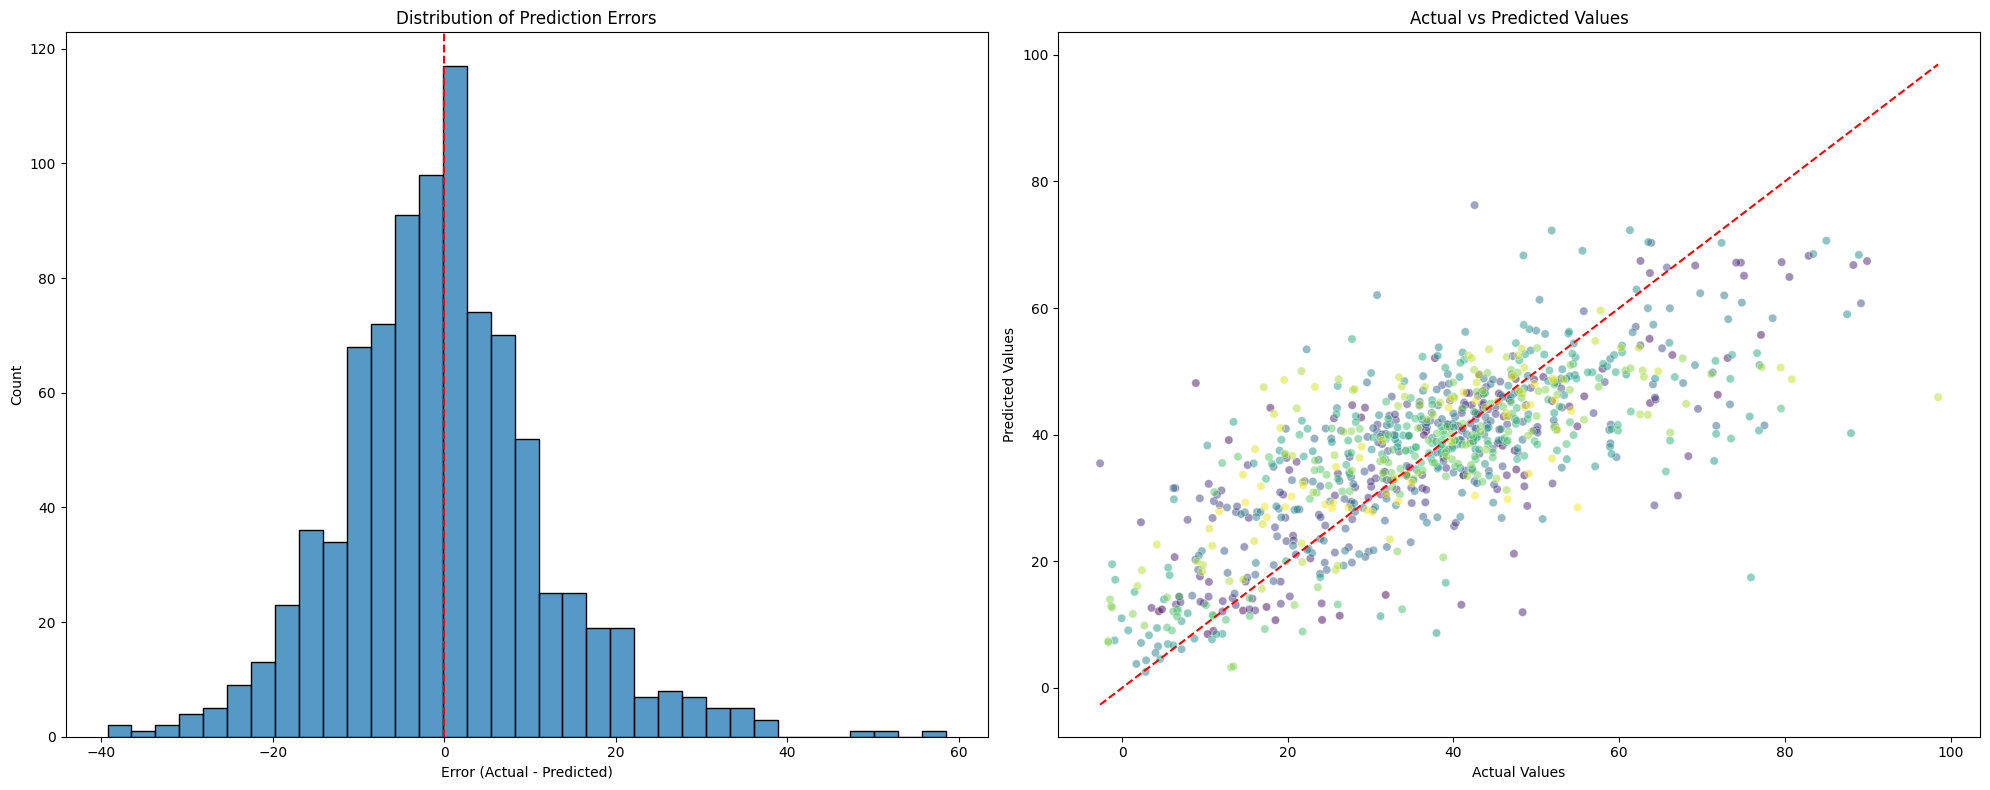

In [248]:
# Load dataframe with best 4 feature models
mlms_4feature = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/mlms_4feature.csv')

# Get the best model features
best_model_passive = mlms_4feature[(mlms_4feature['data_modality'] == 'passive') & (mlms_4feature['n_observations'] >= 100)].iloc[0]

features = [
    best_model_passive['feature_1'],
    best_model_passive['feature_2'], 
    best_model_passive['feature_3'],
    best_model_passive['feature_4']
]

features = [
    'passive_hk_activity_distanceWalkingRunning',
    'passive_sk_device_total_screen_wakes',
    'passive_hk_activity_averageWalkingSpeed',
    'fe_rollingMean_3_passive_sk_device_total_unlock_duration'
]

# Get valid subjects for both train and test sets
train_valid_subjects = filter_subjects_by_data_availability(train_data, features)
test_valid_subjects = filter_subjects_by_data_availability(test_data, features)

# Keep only subjects that meet criteria in both sets
valid_subjects = list(set(train_valid_subjects) & set(test_valid_subjects))

print(f"Number of subjects meeting criteria: {len(valid_subjects)}")
print(f"Original number of subjects: {len(train_data['PID'].unique())}")

# Filter data to only include valid subjects
train_data_filtered = train_data[train_data['PID'].isin(valid_subjects)].copy()
test_data_filtered = test_data[test_data['PID'].isin(valid_subjects)].copy()

# Normalization happening in fit function
    ### EXPANDING WINDOW NORMALIZATION?

# Fit and predict with improved convergence handling
try:
    model, predictions, test_actual, test_data_clean = fit_and_predict_mlm(
        train_data_filtered, 
        test_data_filtered, 
        predictors=features,
        target='target_wbw_gap_detrended',
        random_intercepts=True
    )
    
    # Calculate metrics
    results_df = calculate_metrics(
        model, predictions, test_actual, test_data_clean, 
        train_data_filtered, target='target_wbw_gap_detrended'
    )
    
    # Plot diagnostics
    plot_model_diagnostics(test_actual, predictions, test_data_clean)
    
except RuntimeError as e:
    print(f"Failed to fit model: {str(e)}")

In [174]:
# Fit MLM predicting target_wbw_gap_detrended from task_motivation_level
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set feature variable
feature = 'task_css'
#feature = 'passive_hk_activity_distanceWalkingRunning'

# Filter for subjects with at least 30 values
subject_counts = df.groupby('PID')[feature].count()
valid_subjects = subject_counts[subject_counts >= 30].index
df_filtered = df[df['PID'].isin(valid_subjects)].copy()
df_filtered = df_filtered[['PID', 'day', 'target_wbw_gap_detrended', feature]]

# Normalize only the feature variable
df_filtered[feature] = (
    df_filtered[feature] - 
    df_filtered[feature].mean()
) / df_filtered[feature].std()

df_filtered = df_filtered.dropna()

print(f"Number of subjects with ≥30 observations: {len(valid_subjects)}")
print(f"Original number of observations: {len(df)}")
print(f"Filtered number of observations: {len(df_filtered)}")

# Fit mixed linear model with modified parameters
mlm_motivation = smf.mixedlm(
    f"target_wbw_gap_detrended ~ {feature}", 
    data=df_filtered,
    groups="PID",
    re_formula=f"~{feature}"
    )

# Fit with modified optimizer settings
mlm_motivation_fit = mlm_motivation.fit(
    method='lbfgs',  # Try different optimizer
    maxiter=1000,    # Increase max iterations
)

print("\nMixed Linear Model Results:")
print(mlm_motivation_fit.summary())

Number of subjects with ≥30 observations: 104
Original number of observations: 8008
Filtered number of observations: 7229

Mixed Linear Model Results:
                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_wbw_gap_detrended
No. Observations: 7229    Method:             REML                    
No. Groups:       104     Scale:              176.3371                
Min. group size:  39      Log-Likelihood:     -29174.2254             
Max. group size:  77      Converged:          Yes                     
Mean group size:  69.5                                                
-----------------------------------------------------------------------
                        Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept               38.460     1.276  30.147  0.000  35.960  40.961
task_css                -0.343     0.172  -1.994  0.046  -0.680  -0.006
PID Var  

In [245]:
# Filter features from mlm_gap_df where abs_t_value > 1 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

Selected 65 features with |t| > 1 (excluding css features):


## Create CV folds

In [ ]:
# Create CV folds
cv_folds = expanding_window_cv_nested(train_data)

In [ ]:
# Start with full df (cleaned, detrended, no outliers)
# Create targets from original df

# Select feature set (e.g. passive, sr, task, all)
# Split into training and test data
# Subselect x features based on feature set in training data
# Create aggregated features
# Create CV folds
# Split training and test data into features and target (remove any extra target cols)

# Train model
# Test model
# Calculate metrics
# Plot metrics
# Plot feature importance

## Feature Engineering: Aggregated Features

In [432]:
# Create alt features list without agg_ features except for t_current
alt_features = [f for f in features if not ('agg_' in f) or 't_current' in f]
print(f"\nSelected {len(alt_features)} features (excluding agg_ features except t_current):")


Selected 52 features (excluding agg_ features except t_current):


## Split Data

# XGBoost

## Overfit

In [154]:
# Import XGBoost
import xgboost as xgb

In [155]:
# Create and train XGBoost model with parameters that will cause extreme overfitting
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,        # Increased number of trees
    learning_rate=0.3,        # Increased learning rate
    max_depth=15,            # Much deeper trees
    min_child_weight=1,      # Allow very specific splits
    subsample=1.0,           # Use all samples for each tree
    colsample_bytree=1.0,    # Use all features for each tree
    reg_alpha=0,             # No L1 regularization
    reg_lambda=0,            # No L2 regularization
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions on both train and test sets
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

XGBoost Results:
Training RMSE: 0.001
Training MAE: 0.000
Test RMSE: 17.131
Test MAE: 13.225


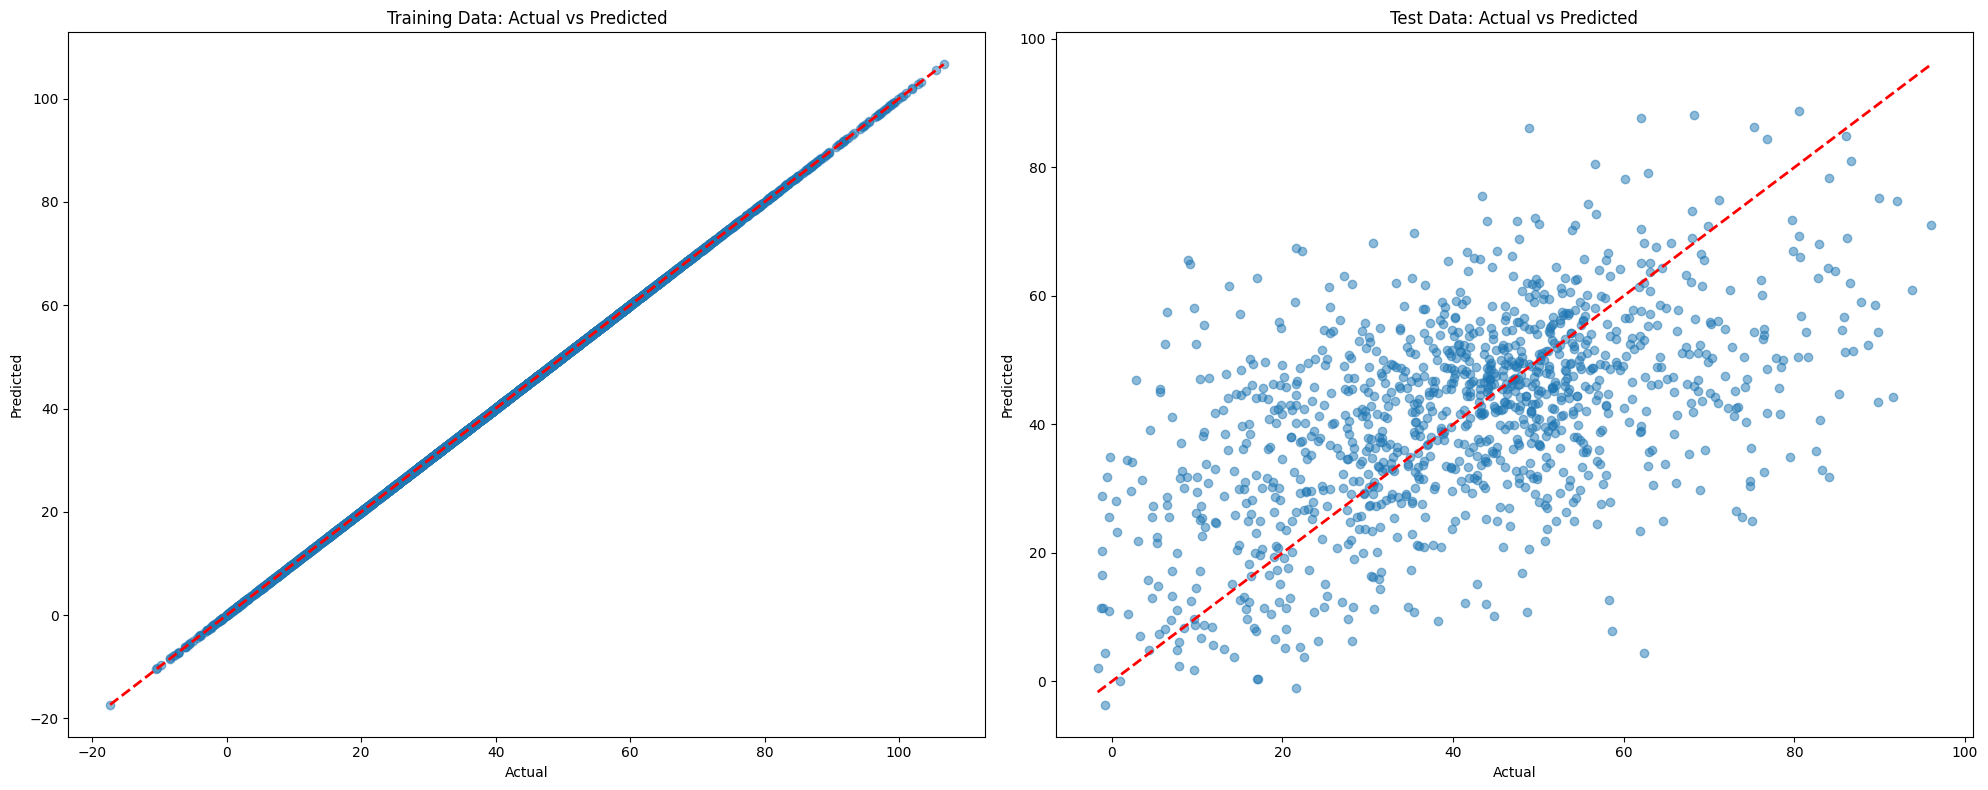

In [156]:
# Calculate metrics for training data
train_rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
train_mae = np.mean(np.abs(y_train - y_pred_train))

# Calculate metrics for test data
test_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
test_mae = np.mean(np.abs(y_test - y_pred_test))

print("XGBoost Results:")
print(f"Training RMSE: {train_rmse:.3f}")
print(f"Training MAE: {train_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}") 
print(f"Test MAE: {test_mae:.3f}")

# Plot actual vs predicted for both train and test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training data plot
ax1.scatter(y_train, y_pred_train, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Training Data: Actual vs Predicted')

# Test data plot
ax2.scatter(y_test, y_pred_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Data: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [131]:
# give the model the normalized passive data and the raw mean and sd for each subject for ALL training data

# how well does this do versus something that just has the mean of the gap

# what if you ONLY knew about their passive data...can we predict their mean??

# how much data about someones mean do we need in order to predict their gap?
## i.e. one day of data re: their gap, what about 1 week, all training data?

#----#

# Look at an individual model using XGBoost - use hyperparameters from group?
# Combine individual and group (experiment with combination level)

## Fitted

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

### Iteration Sets

In [ ]:
# Define feature sets and their labels
feature_sets = {
    'passive': passive_cols,
    'self_report': sr_cols,
    'task': task_cols,
    'passive_sr': passive_cols + sr_cols,
    'all': passive_cols + sr_cols + task_cols
}

# Define targets and labels
target_set = {
    'wbw_gap': 'target_wbw_gap_detrended',
    'overall_gap_sr': 'sr_DAILY_past24_gap',
    'affect': 'sr_affect_net_avg'
}

In [317]:
target = 'target_wbw_gap_detrended'
features = passive_cols + id_cols

### Data Prep

In [372]:
# Train test split
train_data, test_data = create_train_test_split(df, target=target)

In [380]:
def check_feature_missingness(data, features, pid_col='PID', threshold=0.5):
    """
    Check feature missingness within each subject's data.
    Returns features that have sufficient non-missing data for >= 50% of subjects.
    """
    # Get unique subjects
    subjects = data[pid_col].unique()
    
    # Track features that meet threshold for each subject
    subject_feature_validity = {subject: [] for subject in subjects}
    
    # For each subject
    for subject in subjects:
        subject_data = data[data[pid_col] == subject]
        
        # Calculate missingness for each feature
        feature_missingness = subject_data[features].isnull().mean()
        
        # Get features meeting threshold
        valid_features = feature_missingness[feature_missingness <= (1-threshold)].index.tolist()
        subject_feature_validity[subject] = valid_features
    
    # Count how many subjects each feature is valid for
    feature_subject_counts = {}
    for feature in features:
        count = sum(1 for subject in subjects if feature in subject_feature_validity[subject])
        feature_subject_counts[feature] = count
    
    # Get features valid for >= 50% of subjects
    valid_features = [f for f, count in feature_subject_counts.items() 
                     if count >= len(subjects) * 0.5]
    
    # Get removed features
    removed_features = list(set(features) - set(valid_features))
    
    removed_count = len(features) - len(valid_features)
    print(f"\nRemoved {removed_count} features due to missingness:")
    for f in removed_features:
        print(f"- {f}")
    print(f"\nRetained {len(valid_features)} features")
    
    return valid_features

# Check missingness separately for train and test
train_valid_features = check_feature_missingness(train_data, task_cols)
test_valid_features = check_feature_missingness(test_data, task_cols)

# Keep only features that meet criteria in both train and test
final_features = list(set(train_valid_features) & set(test_valid_features))

print(f"\nFinal feature count after checking both train and test: {len(final_features)}")
# passive_cols = final_features



Removed 3 features due to missingness:
- fe_lag_3_task_nback_bias
- fe_lag_2_task_nback_bias
- fe_lag_1_task_nback_bias

Retained 584 features

Removed 4 features due to missingness:
- task_nback_bias
- fe_lag_3_task_nback_bias
- fe_lag_2_task_nback_bias
- fe_lag_1_task_nback_bias

Retained 583 features

Final feature count after checking both train and test: 583


In [378]:
# Get base features (without feature engineering)
base_features = [f for f in final_features if not f.startswith('fe_')]
print("Base features without feature engineering:")
print(base_features)

Base features without feature engineering:
['passive_hk_hr_resting', 'watch_wearing', 'passive_hk_activity_averageWalkingSpeed', 'passive_hk_hr_averageWalking', 'passive_hk_sleep_inBed', 'passive_hk_activity_appleStandTime', 'task_start_time', 'passive_hk_activity_steps', 'tasks_complete', 'task_duration', 'task_end_time', 'passive_hk_activity_distanceWalkingRunning', 'passive_hk_activity_activeEnergyBurned', 'passive_hk_hr_variability', 'survey_complete']


In [299]:
def handle_missing_data(df, target):
    """
    Handle missing data in time series features using a multi-step approach.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing features and target
    target : str
        Name of target column to check for NAs
        
    Returns
    -------
    pd.DataFrame
        Clean dataframe with handled missing values and no NA targets
    """
    # Create copy of original dataframe
    df_full = df.copy()
    
    # Get list of feature columns (excluding target columns)
    feature_cols = [col for col in df_full.columns if not col.startswith('target')]
    
    # 1. Forward fill within each subject first (most recent valid observation)
    for pid in df_full.PID.unique():
        mask = df_full['PID'] == pid
        df_full.loc[mask, feature_cols] = df_full.loc[mask, feature_cols].ffill()
    
    # 2. Backward fill within subjects for any remaining NaNs at start of series
    for pid in df_full.PID.unique():
        mask = df_full['PID'] == pid 
        df_full.loc[mask, feature_cols] = df_full.loc[mask, feature_cols].bfill()
    
    # 3. For any features that still have NaNs, impute with rolling median
    cols_with_nans = [col for col in feature_cols if df_full[col].isna().any()]
    
    for col in cols_with_nans:
        # Calculate rolling median for each subject
        for pid in df_full.PID.unique():
            mask = df_full['PID'] == pid
            df_full.loc[mask, col] = df_full.loc[mask, col].fillna(
                df_full.loc[mask, col].rolling(window=7, min_periods=1, center=True).median()
            )
    
    # 4. Fill any remaining NaNs with 0 (only for feature columns)
    df_full[feature_cols] = df_full[feature_cols].fillna(0)
    
    return df_full

In [ ]:
# Imputation
df_full = handle_missing_data(df, target=target)

In [307]:
# Drop target NAs
df_full = df_full.dropna(subset=[target])

In [308]:
# Train test split
train_data, test_data = create_train_test_split(df_full, target=target)

In [309]:
# CV folds
cv_folds = expanding_window_cv_nested(train_data)

In [344]:
X_train.shape

(5857, 680)

In [389]:
# Drop rows with missing target values
train_data = train_data.dropna(subset=['target_wbw_gap_detrended'])
test_data = test_data.dropna(subset=['target_wbw_gap_detrended'])

In [390]:
# X/y split

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

MAE: 9.495
RMSE: 12.992
R2: 0.485


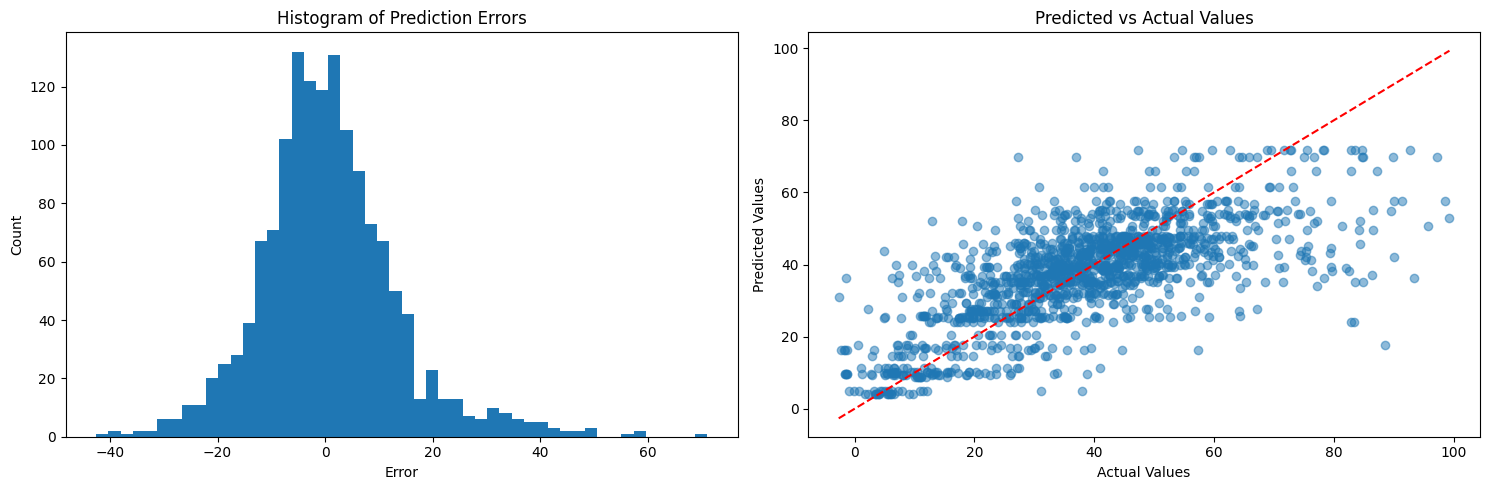

In [ ]:
# Get median target value per subject from training data
train_medians = train_data.groupby('PID')['target_wbw_gap_detrended'].median()

# Map these medians to test data subjects
y_pred = test_data['PID'].map(train_medians)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Plot histogram of errors
errors = y_test - y_pred
ax1.hist(errors, bins=50)
ax1.set_title('Histogram of Prediction Errors')
ax1.set_xlabel('Error')
ax1.set_ylabel('Count')

# Plot predicted vs actual values
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_title('Predicted vs Actual Values')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [346]:
# add mean of target for each pid to training and test data
train_data['fe_median_target'] = train_data.groupby('PID')['target_wbw_gap_detrended'].transform('median')
test_data['fe_median_target'] = train_data.groupby('PID')['target_wbw_gap_detrended'].transform('median')

In [381]:
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

####################################
# Custom Transformer for Within-Subject Normalization
####################################
class WithinSubjectTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that:
      • For each subject (PID), normalizes the specified feature columns using that subject’s statistics.
      • For features that do not start with "fe_", adds two new columns:
          "agg_{feature}_median" and "agg_{feature}_std", computed from the training (or fitting) set.
    
    This transformer is meant to be fitted on the training data and then applied to transform
    both training and test data (using training-group statistics).
    """
    def __init__(self, features):
        self.features = features
        # List of features for which to add aggregate stats (skip already engineered features)
        self.non_fe_features = [f for f in self.features if not f.startswith('fe_')]
        self.norm_params = {}   # Will be: {PID: {feature: {'mean': ..., 'std': ...}, ...}, ...}
        self.agg_params = {}    # {PID: {feature: {'median': ..., 'std': ...}, ...}, ...}
    
    def fit(self, X, y=None):
        # Assume X is a DataFrame that includes a "PID" column.
        for pid, group in X.groupby("PID"):
            self.norm_params[pid] = {}
            for f in self.features:
                mean_val = group[f].mean()
                std_val = group[f].std() if group[f].std() > 0 else 1.0
                self.norm_params[pid][f] = {'mean': mean_val, 'std': std_val}
            self.agg_params[pid] = {}
            for f in self.non_fe_features:
                # compute aggregate (median and std) _from the training data_
                median_val = group[f].median()
                std_val = group[f].std() if group[f].std() > 0 else 1.0
                self.agg_params[pid][f] = {'median': median_val, 'std': std_val}
        return self

    def transform(self, X, y=None):
        # Create a copy so we do not alter the original DataFrame.
        X_transformed = X.copy()
        
        # Define functions that use the stored dictionary for this row based on its PID.
        def _transform_row(row):
            pid = row["PID"]
            if pid in self.norm_params:
                for f in self.features:
                    params = self.norm_params[pid].get(f, {'mean': 0, 'std': 1})
                    row[f] = (row[f] - params["mean"]) / params["std"]
                for f in self.non_fe_features:
                    agg = self.agg_params[pid].get(f, {'median': 0, 'std': 1})
                    row[f"agg_{f}_median"] = agg["median"]
                    row[f"agg_{f}_std"] = agg["std"]
            else:
                # If a new subject appears in test data that wasn’t in training, you might choose to skip or default.
                for f in self.features:
                    row[f] = np.nan
                for f in self.non_fe_features:
                    row[f"agg_{f}_median"] = np.nan
                    row[f"agg_{f}_std"] = np.nan
            return row
        
        X_transformed = X_transformed.apply(_transform_row, axis=1)
        return X_transformed

####################################
# Time Series Hold-out Split (Within each PID)
####################################
def create_time_series_holdout(df, train_frac=0.8, time_col="day"):
    """
    For each subject in df, sort by the time_col and
    then return the indices corresponding to the first train_frac of days and the remaining.
    Returns: (train_indices, val_indices)
    """
    train_idx = []
    val_idx = []
    for pid, group in df.groupby("PID"):
        group_sorted = group.sort_values(time_col)
        n = len(group_sorted)
        split_point = int(np.floor(n * train_frac))
        train_idx.extend(group_sorted.iloc[:split_point].index.tolist())
        val_idx.extend(group_sorted.iloc[split_point:].index.tolist())
    return train_idx, val_idx

####################################
# Objective function for optuna hyperparameter tuning
####################################
def objective(trial, df, features, target_col, time_col="day"):
    """
    The objective function uses a single hold-out split across subjects.
    For each subject, it uses the earlier 80% of their days for training and
    the later 20% for validation. All preprocessing (normalization and aggregation)
    is done within PID.
    """
    # Create a CV split (one fold only)
    train_idx, val_idx = create_time_series_holdout(df, train_frac=0.8, time_col=time_col)
    train_cv = df.loc[train_idx].copy()
    val_cv = df.loc[val_idx].copy()
    
    # Important: fit the transformer on the CV training fold only
    transformer = WithinSubjectTransformer(features)
    transformer.fit(train_cv)
    train_cv_transformed = transformer.transform(train_cv)
    val_cv_transformed = transformer.transform(val_cv)
    
    # Define the model features: original (normalized) features + aggregated features
    model_features = features + [f"agg_{f}_median" for f in transformer.non_fe_features] + \
                     [f"agg_{f}_std" for f in transformer.non_fe_features]
    
    X_train = train_cv_transformed[model_features]
    y_train = train_cv_transformed[target_col]
    X_val = val_cv_transformed[model_features]
    y_val = val_cv_transformed[target_col]
    
    # Define hyperparameter search space.
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0, log=True),
        'seed': 42,
        'early_stopping_rounds': 20,
    }
    # Train the XGBoost regressor.
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

####################################
# Pipeline: Tuning, Final Training & Evaluation
####################################
def run_pipeline(df_train, df_test, features, target_col="target_wbw_gap_detrended", time_col="day", n_trials=50):
    """
    Runs a complete pipeline:
      1. Hyperparameter tuning on df_train (using time-series hold-out CV within each subject)
      2. Preprocess the full training and test sets using within-subject transformation.
      3. Train final model on all of df_train.
      4. Evaluate performance on df_test.
      5. Plot error distributions and actual vs predicted plots.
    """
    print("Starting hyperparameter tuning using Optuna ...")
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, df_train, features, target_col, time_col=time_col), 
                   n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    best_params.update({
        'objective': 'reg:squarederror',
        'seed': 42
    })
    print("\nBest hyperparameters found:", best_params)
    print(f"Best CV RMSE: {study.best_value:.4f}")
    
    # Preprocess the full training data
    transformer = WithinSubjectTransformer(features)
    transformer.fit(df_train)
    df_train_trans = transformer.transform(df_train)
    df_test_trans = transformer.transform(df_test)  # use training stats for test set
    
    model_features = features + [f"agg_{f}_median" for f in transformer.non_fe_features] + \
                     [f"agg_{f}_std" for f in transformer.non_fe_features]
    
    X_train = df_train_trans[model_features]
    y_train = df_train_trans[target_col]
    X_test = df_test_trans[model_features]
    y_test = df_test_trans[target_col]
    
    # Pass early_stopping_rounds in the constructor:
    final_model = xgb.XGBRegressor(**best_params, early_stopping_rounds=20)
    final_model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Get predictions on test set.
    preds_test = final_model.predict(X_test)
    
    # Calculate evaluation metrics.
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
    mae_test = mean_absolute_error(y_test, preds_test)
    r2 = r2_score(y_test, preds_test)
    
    print("\nFinal Test Set Performance:")
    print(f"RMSE: {rmse_test:.4f}")
    print(f"MAE: {mae_test:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Plot the distribution of errors.
    plt.figure(figsize=(12, 6))
    sns.histplot(y_test - preds_test, kde=True, bins=30)
    plt.axvline(0, color="red", linestyle="--")
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.show()
    
    # Plot Actual vs Predicted.
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=y_test, y=preds_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.title("Actual vs Predicted Values")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()
    
    return final_model, transformer

[I 2025-02-14 08:16:48,657] A new study created in memory with name: no-name-9b9f9ffb-aab2-44d8-b7c1-ebdd506ca157


Starting hyperparameter tuning using Optuna ...


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:18:08,934] Trial 0 finished with value: 14.44878860630284 and parameters: {'n_estimators': 471, 'max_depth': 2, 'learning_rate': 0.016765864832838772, 'min_child_weight': 2, 'subsample': 0.7924007833372178, 'colsample_bytree': 0.9132246981796028, 'reg_alpha': 0.6510619483963622, 'reg_lambda': 0.3375751535520112}. Best is trial 0 with value: 14.44878860630284.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:19:30,155] Trial 1 finished with value: 13.578674410654134 and parameters: {'n_estimators': 449, 'max_depth': 2, 'learning_rate': 0.05163244034007983, 'min_child_weight': 3, 'subsample': 0.7741047702301591, 'colsample_bytree': 0.9231520358902847, 'reg_alpha': 0.5660109190618354, 'reg_lambda': 0.23203805498901756}. Best is trial 1 with value: 13.578674410654134.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:20:53,126] Trial 2 finished with value: 13.310650151441713 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.03795829983081063, 'min_child_weight': 2, 'subsample': 0.8880395613832621, 'colsample_bytree': 0.9655748398292354, 'reg_alpha': 0.16280724262509957, 'reg_lambda': 0.9965337846565765}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:22:14,089] Trial 3 finished with value: 13.937374009802983 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.05552064385619765, 'min_child_weight': 2, 'subsample': 0.7510231832180021, 'colsample_bytree': 0.8877421792168818, 'reg_alpha': 0.8141611215969755, 'reg_lambda': 0.21170019487807623}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:23:32,681] Trial 4 finished with value: 13.384547797888336 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.035468158681678935, 'min_child_weight': 3, 'subsample': 0.9402393353894367, 'colsample_bytree': 0.9424832580924429, 'reg_alpha': 0.18793272109596948, 'reg_lambda': 0.2856247739945467}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:24:52,267] Trial 5 finished with value: 13.414890829686627 and parameters: {'n_estimators': 144, 'max_depth': 6, 'learning_rate': 0.09667252287528404, 'min_child_weight': 5, 'subsample': 0.9943064690857251, 'colsample_bytree': 0.8710317002816186, 'reg_alpha': 0.10267983581217698, 'reg_lambda': 0.3246277245548408}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:26:13,181] Trial 6 finished with value: 13.45352532875608 and parameters: {'n_estimators': 185, 'max_depth': 5, 'learning_rate': 0.03808486512123915, 'min_child_weight': 1, 'subsample': 0.9972159314985309, 'colsample_bytree': 0.7622235538156129, 'reg_alpha': 0.11130164750033641, 'reg_lambda': 0.11766787560803836}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:27:33,700] Trial 7 finished with value: 13.492673251671274 and parameters: {'n_estimators': 141, 'max_depth': 6, 'learning_rate': 0.04182320960460744, 'min_child_weight': 1, 'subsample': 0.7009300973559889, 'colsample_bytree': 0.9964187488757295, 'reg_alpha': 0.6603324848676245, 'reg_lambda': 0.2961430177986236}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:28:53,896] Trial 8 finished with value: 13.557152555610529 and parameters: {'n_estimators': 115, 'max_depth': 6, 'learning_rate': 0.030201144347894844, 'min_child_weight': 1, 'subsample': 0.8197871021824148, 'colsample_bytree': 0.9021873259605057, 'reg_alpha': 0.3228012751912267, 'reg_lambda': 0.5010990366959127}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:30:13,972] Trial 9 finished with value: 13.450921447720505 and parameters: {'n_estimators': 277, 'max_depth': 4, 'learning_rate': 0.04749665322886543, 'min_child_weight': 1, 'subsample': 0.9999829793930713, 'colsample_bytree': 0.8304205616618517, 'reg_alpha': 0.15613773441973716, 'reg_lambda': 0.28511268832262604}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:31:32,792] Trial 10 finished with value: 14.16278028211747 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.011321466507638206, 'min_child_weight': 5, 'subsample': 0.8806701088551856, 'colsample_bytree': 0.9997994754681816, 'reg_alpha': 0.27571882017285354, 'reg_lambda': 0.9693091843704637}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:32:53,982] Trial 11 finished with value: 13.419474861985659 and parameters: {'n_estimators': 218, 'max_depth': 5, 'learning_rate': 0.024491819806010236, 'min_child_weight': 3, 'subsample': 0.9031620138279072, 'colsample_bytree': 0.9656261961790136, 'reg_alpha': 0.20731325097192238, 'reg_lambda': 0.8773611401640764}. Best is trial 2 with value: 13.310650151441713.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:34:17,010] Trial 12 finished with value: 13.24937239406903 and parameters: {'n_estimators': 375, 'max_depth': 5, 'learning_rate': 0.02244933501739323, 'min_child_weight': 4, 'subsample': 0.9301147543775125, 'colsample_bytree': 0.8059399328827357, 'reg_alpha': 0.17646749550718202, 'reg_lambda': 0.5247104840901521}. Best is trial 12 with value: 13.24937239406903.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:35:37,401] Trial 13 finished with value: 13.276966679363667 and parameters: {'n_estimators': 369, 'max_depth': 5, 'learning_rate': 0.020375488364567835, 'min_child_weight': 4, 'subsample': 0.9370413935441513, 'colsample_bytree': 0.8165550185290879, 'reg_alpha': 0.3093133464748137, 'reg_lambda': 0.6172426929097756}. Best is trial 12 with value: 13.24937239406903.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:36:58,060] Trial 14 finished with value: 13.45956393664205 and parameters: {'n_estimators': 387, 'max_depth': 4, 'learning_rate': 0.01937561274236334, 'min_child_weight': 4, 'subsample': 0.9480249435854831, 'colsample_bytree': 0.8094220218923749, 'reg_alpha': 0.44376045500929445, 'reg_lambda': 0.6021463426574076}. Best is trial 12 with value: 13.24937239406903.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:38:17,055] Trial 15 finished with value: 14.131876293661103 and parameters: {'n_estimators': 378, 'max_depth': 3, 'learning_rate': 0.014282820762811553, 'min_child_weight': 4, 'subsample': 0.933542808504783, 'colsample_bytree': 0.7040110750027324, 'reg_alpha': 0.29756466509038976, 'reg_lambda': 0.5365024124809671}. Best is trial 12 with value: 13.24937239406903.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:39:38,681] Trial 16 finished with value: 13.41133059334692 and parameters: {'n_estimators': 353, 'max_depth': 5, 'learning_rate': 0.023236542626983617, 'min_child_weight': 4, 'subsample': 0.851981866969769, 'colsample_bytree': 0.7789808874719459, 'reg_alpha': 0.4182404676648006, 'reg_lambda': 0.6544394980137042}. Best is trial 12 with value: 13.24937239406903.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:40:59,872] Trial 17 finished with value: 14.565488308029895 and parameters: {'n_estimators': 334, 'max_depth': 3, 'learning_rate': 0.011742648069902144, 'min_child_weight': 4, 'subsample': 0.9613732899527744, 'colsample_bytree': 0.7317831642571135, 'reg_alpha': 0.2337327005093533, 'reg_lambda': 0.4267527462413654}. Best is trial 12 with value: 13.24937239406903.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:42:22,139] Trial 18 finished with value: 13.27174608603788 and parameters: {'n_estimators': 420, 'max_depth': 6, 'learning_rate': 0.022715691946440447, 'min_child_weight': 5, 'subsample': 0.9085155802032758, 'colsample_bytree': 0.8468024900374069, 'reg_alpha': 0.3575181313067076, 'reg_lambda': 0.7341852069321503}. Best is trial 12 with value: 13.24937239406903.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:43:44,003] Trial 19 finished with value: 13.227158170950624 and parameters: {'n_estimators': 421, 'max_depth': 6, 'learning_rate': 0.027336546693770194, 'min_child_weight': 5, 'subsample': 0.8518809364089932, 'colsample_bytree': 0.8527405321195825, 'reg_alpha': 0.4023674053966954, 'reg_lambda': 0.7602483807923702}. Best is trial 19 with value: 13.227158170950624.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:45:05,754] Trial 20 finished with value: 13.318517013963406 and parameters: {'n_estimators': 433, 'max_depth': 6, 'learning_rate': 0.07018935618782737, 'min_child_weight': 5, 'subsample': 0.8345919147184601, 'colsample_bytree': 0.7967260992821417, 'reg_alpha': 0.994295227618626, 'reg_lambda': 0.42254053552357845}. Best is trial 19 with value: 13.227158170950624.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:46:26,748] Trial 21 finished with value: 13.202956449692635 and parameters: {'n_estimators': 415, 'max_depth': 6, 'learning_rate': 0.027817407124890395, 'min_child_weight': 5, 'subsample': 0.8616638540305627, 'colsample_bytree': 0.8578103882508507, 'reg_alpha': 0.41580708772241215, 'reg_lambda': 0.763967706713622}. Best is trial 21 with value: 13.202956449692635.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:47:49,573] Trial 22 finished with value: 13.250447079687838 and parameters: {'n_estimators': 494, 'max_depth': 6, 'learning_rate': 0.027801519662689546, 'min_child_weight': 5, 'subsample': 0.860326793262889, 'colsample_bytree': 0.8635100900239452, 'reg_alpha': 0.5136441506460924, 'reg_lambda': 0.7988445518908291}. Best is trial 21 with value: 13.202956449692635.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:49:13,941] Trial 23 finished with value: 13.195774151538226 and parameters: {'n_estimators': 314, 'max_depth': 6, 'learning_rate': 0.029079748157768585, 'min_child_weight': 5, 'subsample': 0.8082677368440947, 'colsample_bytree': 0.843976849175798, 'reg_alpha': 0.3903404800972868, 'reg_lambda': 0.757379326572052}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:50:28,313] Trial 24 finished with value: 13.300738254729332 and parameters: {'n_estimators': 322, 'max_depth': 6, 'learning_rate': 0.030247372950479943, 'min_child_weight': 5, 'subsample': 0.8107834779242437, 'colsample_bytree': 0.8452451900759771, 'reg_alpha': 0.40278008839740415, 'reg_lambda': 0.7456926392186589}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:51:45,439] Trial 25 finished with value: 13.274689518187548 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.016676044301028106, 'min_child_weight': 5, 'subsample': 0.753039234133691, 'colsample_bytree': 0.8808286867765818, 'reg_alpha': 0.48612486642812974, 'reg_lambda': 0.11604950197426721}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:52:59,997] Trial 26 finished with value: 13.2017433225179 and parameters: {'n_estimators': 297, 'max_depth': 6, 'learning_rate': 0.028504383628953984, 'min_child_weight': 5, 'subsample': 0.8593144174854371, 'colsample_bytree': 0.836127305167515, 'reg_alpha': 0.2491800444989552, 'reg_lambda': 0.4086575507178764}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:54:13,117] Trial 27 finished with value: 13.390043799505062 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.03324874702958087, 'min_child_weight': 4, 'subsample': 0.8729772249171404, 'colsample_bytree': 0.7730858664332045, 'reg_alpha': 0.2545223220221014, 'reg_lambda': 0.14616935983612414}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:55:26,502] Trial 28 finished with value: 13.279379726868955 and parameters: {'n_estimators': 249, 'max_depth': 6, 'learning_rate': 0.04236208092099365, 'min_child_weight': 5, 'subsample': 0.8316502265916772, 'colsample_bytree': 0.8265247071313284, 'reg_alpha': 0.3485511603540631, 'reg_lambda': 0.4377550131049078}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:56:39,202] Trial 29 finished with value: 14.978440143851806 and parameters: {'n_estimators': 308, 'max_depth': 2, 'learning_rate': 0.017784654138508754, 'min_child_weight': 5, 'subsample': 0.7993439197338026, 'colsample_bytree': 0.9046135627233814, 'reg_alpha': 0.639600268275293, 'reg_lambda': 0.3751280939294638}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:57:53,729] Trial 30 finished with value: 13.56657030125727 and parameters: {'n_estimators': 231, 'max_depth': 6, 'learning_rate': 0.014486754825740234, 'min_child_weight': 3, 'subsample': 0.7906240625607931, 'colsample_bytree': 0.753543047291722, 'reg_alpha': 0.13488622686621443, 'reg_lambda': 0.22847754928907069}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 08:59:07,570] Trial 31 finished with value: 13.322590173146716 and parameters: {'n_estimators': 460, 'max_depth': 6, 'learning_rate': 0.026691458514498664, 'min_child_weight': 5, 'subsample': 0.8430646150831927, 'colsample_bytree': 0.8592255430659166, 'reg_alpha': 0.3834249549328828, 'reg_lambda': 0.6750509156723581}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:00:21,937] Trial 32 finished with value: 13.304531613613497 and parameters: {'n_estimators': 402, 'max_depth': 6, 'learning_rate': 0.026436745074817178, 'min_child_weight': 5, 'subsample': 0.8618914748939274, 'colsample_bytree': 0.8385271774875203, 'reg_alpha': 0.5604832667506338, 'reg_lambda': 0.8805911773677417}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:01:36,623] Trial 33 finished with value: 13.336817783833839 and parameters: {'n_estimators': 496, 'max_depth': 5, 'learning_rate': 0.03234876068022042, 'min_child_weight': 4, 'subsample': 0.7749337051337598, 'colsample_bytree': 0.889053197255233, 'reg_alpha': 0.23277983001599334, 'reg_lambda': 0.814268963348895}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:02:50,036] Trial 34 finished with value: 13.313914017249003 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.05086949975175402, 'min_child_weight': 5, 'subsample': 0.9024069427635028, 'colsample_bytree': 0.9282948974508131, 'reg_alpha': 0.4484156543292219, 'reg_lambda': 0.5855328421392487}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:04:03,097] Trial 35 finished with value: 13.405913764750656 and parameters: {'n_estimators': 345, 'max_depth': 6, 'learning_rate': 0.05916614613418437, 'min_child_weight': 5, 'subsample': 0.8196317804681479, 'colsample_bytree': 0.7912440615729003, 'reg_alpha': 0.27413356268649214, 'reg_lambda': 0.1715038831695934}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:05:16,352] Trial 36 finished with value: 13.247415035126613 and parameters: {'n_estimators': 445, 'max_depth': 5, 'learning_rate': 0.03902169011288726, 'min_child_weight': 2, 'subsample': 0.888823962325661, 'colsample_bytree': 0.8577673436548513, 'reg_alpha': 0.3444286309197411, 'reg_lambda': 0.6978290581483431}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:06:30,464] Trial 37 finished with value: 13.362837744526463 and parameters: {'n_estimators': 471, 'max_depth': 6, 'learning_rate': 0.03540002955458567, 'min_child_weight': 4, 'subsample': 0.8672888660454, 'colsample_bytree': 0.8767727968920416, 'reg_alpha': 0.7046533589409433, 'reg_lambda': 0.9491694861495491}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:07:42,758] Trial 38 finished with value: 14.333399309664836 and parameters: {'n_estimators': 295, 'max_depth': 2, 'learning_rate': 0.029123278963905815, 'min_child_weight': 3, 'subsample': 0.7850346966406317, 'colsample_bytree': 0.8239441021433285, 'reg_alpha': 0.5303228032029172, 'reg_lambda': 0.4579840197369771}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:08:57,212] Trial 39 finished with value: 13.296784060866711 and parameters: {'n_estimators': 359, 'max_depth': 5, 'learning_rate': 0.020409902403220354, 'min_child_weight': 5, 'subsample': 0.7484931617138274, 'colsample_bytree': 0.9232483300541711, 'reg_alpha': 0.20091086397315913, 'reg_lambda': 0.3521145878711208}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:10:10,945] Trial 40 finished with value: 13.342333338915356 and parameters: {'n_estimators': 394, 'max_depth': 4, 'learning_rate': 0.025886869144628566, 'min_child_weight': 5, 'subsample': 0.8436554652785748, 'colsample_bytree': 0.8917950440723338, 'reg_alpha': 0.38338084905925307, 'reg_lambda': 0.25889799569319977}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:11:24,599] Trial 41 finished with value: 13.268929790395596 and parameters: {'n_estimators': 437, 'max_depth': 5, 'learning_rate': 0.04260595672153558, 'min_child_weight': 2, 'subsample': 0.8950163700297764, 'colsample_bytree': 0.85576712041492, 'reg_alpha': 0.3293099832994036, 'reg_lambda': 0.6915394628852987}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:12:38,722] Trial 42 finished with value: 13.371438968485254 and parameters: {'n_estimators': 448, 'max_depth': 6, 'learning_rate': 0.03526109237707171, 'min_child_weight': 2, 'subsample': 0.880522092866741, 'colsample_bytree': 0.8699146858481865, 'reg_alpha': 0.4681774544727477, 'reg_lambda': 0.8272540696997541}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:13:52,516] Trial 43 finished with value: 13.289908977940708 and parameters: {'n_estimators': 421, 'max_depth': 5, 'learning_rate': 0.038769241208533624, 'min_child_weight': 2, 'subsample': 0.8261001533342225, 'colsample_bytree': 0.8371699559850521, 'reg_alpha': 0.2865860529147581, 'reg_lambda': 0.5400047650327885}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:15:07,083] Trial 44 finished with value: 13.384898190510539 and parameters: {'n_estimators': 326, 'max_depth': 6, 'learning_rate': 0.031308248638940085, 'min_child_weight': 3, 'subsample': 0.888972348193562, 'colsample_bytree': 0.8530541265540734, 'reg_alpha': 0.3593007610327183, 'reg_lambda': 0.9731925781103093}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:16:20,294] Trial 45 finished with value: 13.363215462288123 and parameters: {'n_estimators': 462, 'max_depth': 5, 'learning_rate': 0.06154499764825001, 'min_child_weight': 1, 'subsample': 0.9186893920443261, 'colsample_bytree': 0.8718702253182589, 'reg_alpha': 0.23748558002053952, 'reg_lambda': 0.7308672652212677}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:17:33,463] Trial 46 finished with value: 13.349179853540534 and parameters: {'n_estimators': 480, 'max_depth': 6, 'learning_rate': 0.03883727662932875, 'min_child_weight': 2, 'subsample': 0.8072970039589648, 'colsample_bytree': 0.8999573933108062, 'reg_alpha': 0.6053231367140198, 'reg_lambda': 0.48730187125057395}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:18:46,297] Trial 47 finished with value: 13.324155677542235 and parameters: {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.046786875635959284, 'min_child_weight': 3, 'subsample': 0.8576596918589029, 'colsample_bytree': 0.8217481345392531, 'reg_alpha': 0.3229029359790515, 'reg_lambda': 0.6143677659177604}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:19:59,390] Trial 48 finished with value: 13.27660906052364 and parameters: {'n_estimators': 444, 'max_depth': 6, 'learning_rate': 0.07986349870051647, 'min_child_weight': 4, 'subsample': 0.8774012565275101, 'colsample_bytree': 0.8119736342539896, 'reg_alpha': 0.4265807888487651, 'reg_lambda': 0.8875618442935247}. Best is trial 23 with value: 13.195774151538226.


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-02-14 09:21:12,890] Trial 49 finished with value: 13.419660438518246 and parameters: {'n_estimators': 216, 'max_depth': 5, 'learning_rate': 0.024376471595782486, 'min_child_weight': 5, 'subsample': 0.8441396886543724, 'colsample_bytree': 0.8378328016171165, 'reg_alpha': 0.26008082794873255, 'reg_lambda': 0.5512807120091755}. Best is trial 23 with value: 13.195774151538226.

Best hyperparameters found: {'n_estimators': 314, 'max_depth': 6, 'learning_rate': 0.029079748157768585, 'min_child_weight': 5, 'subsample': 0.8082677368440947, 'colsample_bytree': 0.843976849175798, 'reg_alpha': 0.3903404800972868, 'reg_lambda': 0.757379326572052, 'objective': 'reg:squarederror', 'seed': 42}
Best CV RMSE: 13.1958

Final Test Set Performance:
RMSE: 12.4995
MAE: 9.3253
R2 Score: 0.5221


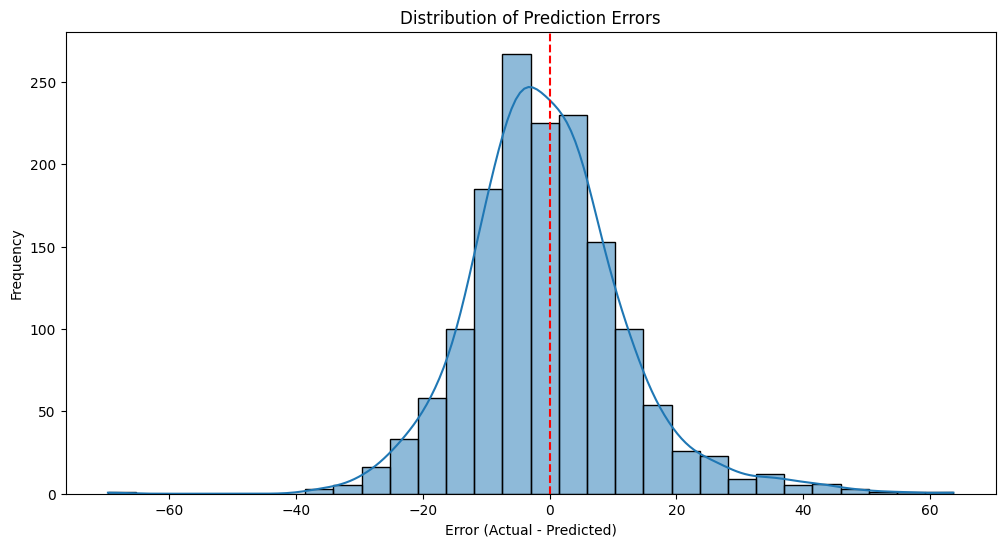

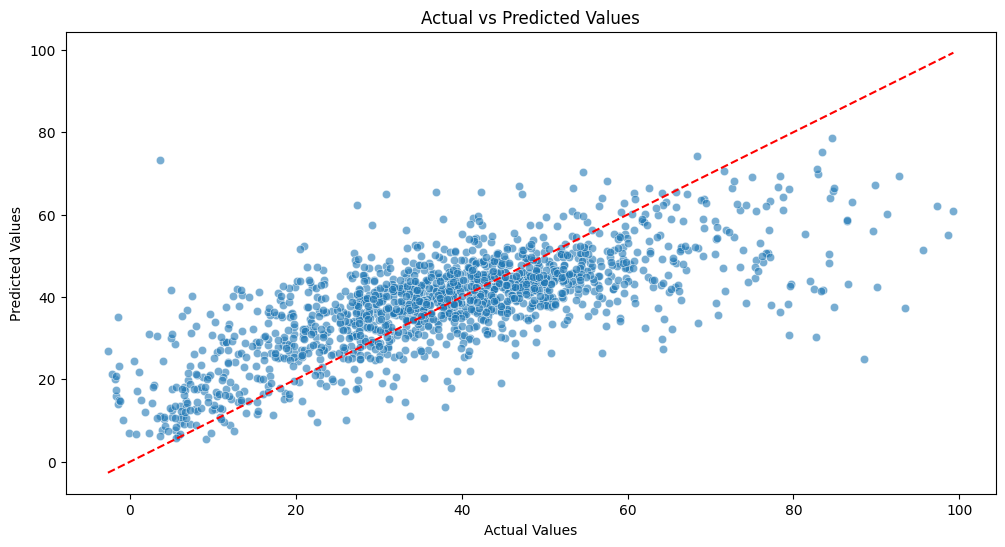

In [356]:
####################################
# Main execution (example)
####################################
if __name__ == "__main__":
    # Example usage:
    # Assume you have already split your entire data into df_train and df_test.
    
    # Define your features (all feature columns; you might use domain knowledge to subselect)
    # Here we assume all columns that start with 'feature_' or 'fe_' (you may modify as needed).
    feature_cols = sr_cols
    
    # Run the full training and evaluation pipeline.
    final_model, transformer = run_pipeline(train_data, test_data, feature_cols, target_col="target_wbw_gap_detrended", time_col="day", n_trials=50)
    
    # Further suggestions:
    #   - You might add external feature selection (or use regularization settings that favor sparse models)
    #     since there are many more features than observations.
    #   - Consider trying different CV strategies (e.g. rolling windows across time) if you suspect trends in time.
    #   - If available, consider using domain knowledge to transform features or incorporate lag features.

In [ ]:
if __name__ == "__main__":
    # Example usage:
    # Assume you have already split your entire data into df_train and df_test.
    
    # Define your features (all feature columns; you might use domain knowledge to subselect)
    # Here we assume all columns that start with 'feature_' or 'fe_' (you may modify as needed).
    feature_cols = passive_cols
    
    # Run the full training and evaluation pipeline.
    final_model, transformer = run_pipeline(train_data, test_data, feature_cols, target_col="target_wbw_gap_detrended", time_col="day", n_trials=50)
    

In [ ]:
# Get feature importance from the final model
feature_importance = pd.DataFrame(
    data=list(zip(feature_cols, final_model.feature_importances_)),
    columns=['feature', 'importance']
)

# Sort by importance and show top 20
print("\nTop 20 Most Important Features:")
feature_importance.sort_values('importance', ascending=False).head(20)



Top 20 Most Important Features:


,feature,importance
4,passive_hk_activity_steps,0.002474
645,fe_rollingSD_7_passive_sk_device_total_usage_g...,0.002022
77,passive_sk_device_total_usage_sports,0.001967
341,fe_rollingMean_3_passive_hk_activity_restingEn...,0.001785
417,fe_rollingMean_5_passive_sk_visits_work_distance,0.001686
242,fe_lag_1_passive_sk_keyboard_sentiment_combine...,0.001666
16,passive_sk_device_total_screen_wakes,0.001624
360,fe_rollingMean_5_passive_hk_sleep_asleep,0.001535
636,fe_rollingSD_7_passive_sk_keyboard_sentiment_c...,0.001522
2,passive_hk_activity_distanceWalkingRunning,0.001481


In [ ]:
# Get feature importance from the final model
feature_importance = pd.DataFrame(
    data=list(zip(feature_cols, final_model.feature_importances_)),
    columns=['feature', 'importance']
)

# Sort by importance and show top 20
print("\nTop 20 Most Important Features:")
feature_importance.sort_values('importance', ascending=False).head(20)



Top 20 Most Important Features:


,feature,importance
4,passive_hk_activity_steps,0.002474
645,fe_rollingSD_7_passive_sk_device_total_usage_g...,0.002022
77,passive_sk_device_total_usage_sports,0.001967
341,fe_rollingMean_3_passive_hk_activity_restingEn...,0.001785
417,fe_rollingMean_5_passive_sk_visits_work_distance,0.001686
242,fe_lag_1_passive_sk_keyboard_sentiment_combine...,0.001666
16,passive_sk_device_total_screen_wakes,0.001624
360,fe_rollingMean_5_passive_hk_sleep_asleep,0.001535
636,fe_rollingSD_7_passive_sk_keyboard_sentiment_c...,0.001522
2,passive_hk_activity_distanceWalkingRunning,0.001481


In [ ]:
# Save the trained model and transformer
import joblib

# Save the model
model_filename = 'xgboost_model.joblib'
joblib.dump(final_model, model_filename)

# Save the transformer
transformer_filename = 'feature_transformer.joblib' 
joblib.dump(transformer, transformer_filename)

print(f"Model saved to {model_filename}")
print(f"Transformer saved to {transformer_filename}")


In [ ]:
# Best hyperparameters found: {'n_estimators': 433, 'max_depth': 4, 'learning_rate': 0.014799051329748689, 'min_child_weight': 2, 'subsample': 0.7678940640423547, 'colsample_bytree': 0.9099165536449384, 'reg_alpha': 0.2877602977530148, 'reg_lambda': 0.3130167673661955, 'objective': 'reg:squarederror', 'seed': 42}

In [ ]:
# check position of top 4 mlm features from previous better model

# iterate through feature sets and targets

# add step where subset of features can be selected

# add step where different models can be used



### Continuous

In [342]:
# Run hyperparameter optimization with improved settings
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

try:
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, cv_folds, raw_features=features), 
        n_trials=50,
        show_progress_bar=True,
        catch=(Exception,)
    )
except Exception as e:
    print(f"Optimization error: {str(e)}")

# Get best parameters and add fixed parameters
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 50
})

print("\nBest parameters found:", best_params)
print(f"Best score: {study.best_value:.4f}")

[I 2025-02-13 10:31:02,913] A new study created in memory with name: no-name-7d7b4b13-0783-4d69-83e8-6ac985e616f7


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-13 10:31:27,802] Trial 0 finished with value: 15.38120785693754 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.05395030966670229, 'min_child_weight': 3, 'subsample': 0.7468055921327309, 'colsample_bytree': 0.7467983561008608, 'reg_alpha': 0.1143098387631322, 'reg_lambda': 0.7348118405270447}. Best is trial 0 with value: 15.38120785693754.
[I 2025-02-13 10:32:01,632] Trial 1 finished with value: 15.652194351945571 and parameters: {'n_estimators': 341, 'max_depth': 5, 'learning_rate': 0.010485387725194618, 'min_child_weight': 5, 'subsample': 0.9497327922401265, 'colsample_bytree': 0.7637017332034828, 'reg_alpha': 0.1519934830130981, 'reg_lambda': 0.15254729458052607}. Best is trial 0 with value: 15.38120785693754.
[I 2025-02-13 10:32:17,061] Trial 2 finished with value: 15.492796998816596 and parameters: {'n_estimators': 222, 'max_depth': 4, 'learning_rate': 0.027036160666620016, 'min_child_weight': 2, 'subsample': 0.8835558684167139, 'colsample_bytre


Final Model Results:
train_rmse: 10.065
test_rmse: 14.273
train_mae: 7.824
test_mae: 10.893
train_r2: 0.718
test_r2: 0.377


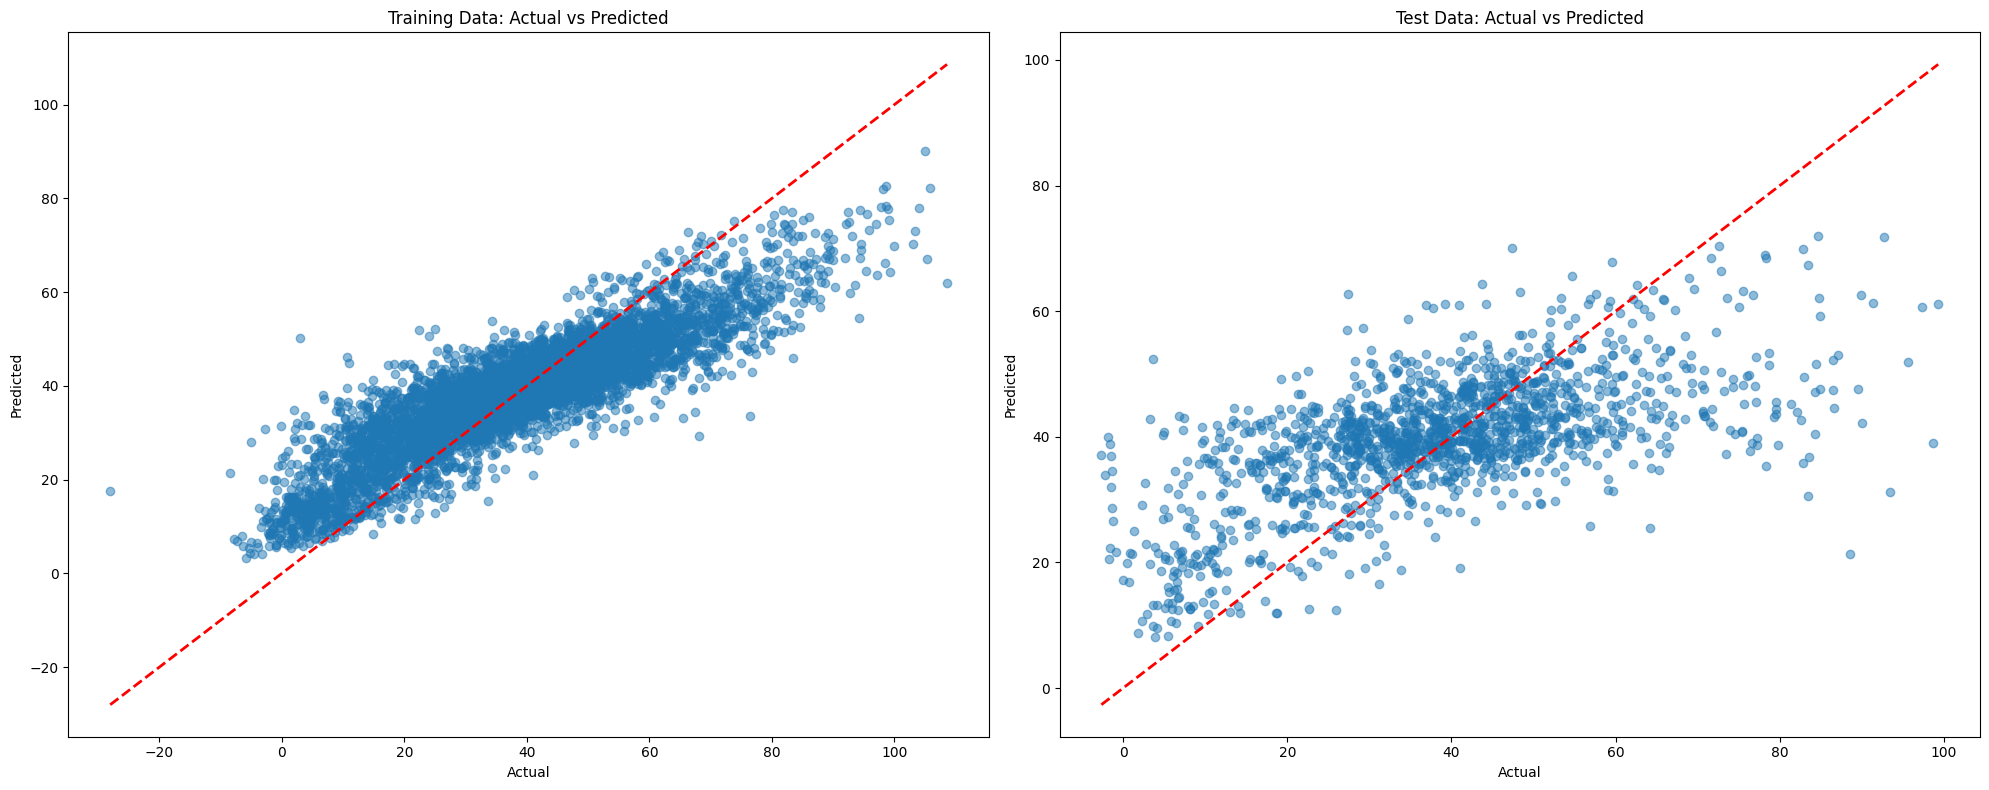

<Figure size 1800x600 with 0 Axes>

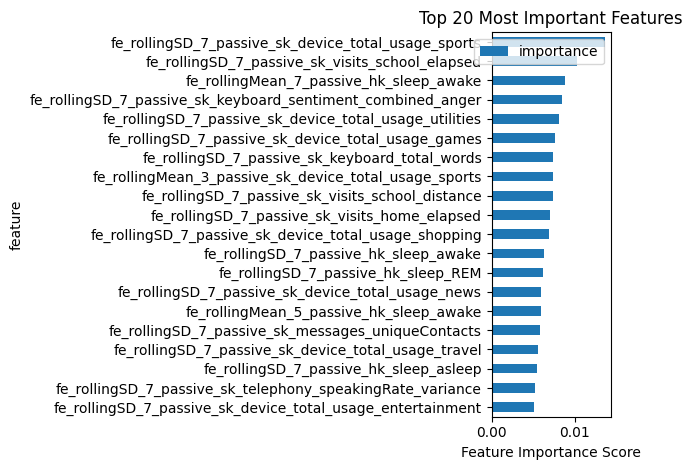

In [343]:
# # Train final model with best parameters
# try:
# # Create aggregated features for final model
# X_train_agg, X_test_agg, features_agg = create_aggregated_features(
#     train_data=X_train,
#     test_data=X_test,
#     features=features
# )

X_train_agg = X_train
X_test_agg = X_test

# Drop non-numeric columns (like 'PID')
numeric_cols = X_train_agg.select_dtypes(include=['int64', 'float64']).columns
X_train_agg = X_train_agg[numeric_cols]
X_test_agg = X_test_agg[numeric_cols]

# Train final model on all training data
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train_agg,
    y_train,
    eval_set=[(X_test_agg, y_test)],
    verbose=False
)

# Make predictions
y_pred_train = final_model.predict(X_train_agg)
y_pred_test = final_model.predict(X_test_agg)

# Calculate metrics
metrics = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'train_mae': mean_absolute_error(y_train, y_pred_train),
    'test_mae': mean_absolute_error(y_test, y_pred_test),
    'train_r2': r2_score(y_train, y_pred_train),
    'test_r2': r2_score(y_test, y_pred_test)
}

print("\nFinal Model Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")
        
# except Exception as e:
#     print(f"Error in final model training: {str(e)}")

# Plot actual vs predicted for both train and test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training data plot
ax1.scatter(y_train, y_pred_train, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Training Data: Actual vs Predicted')

# Test data plot
ax2.scatter(y_test, y_pred_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Data: Actual vs Predicted')

plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(18, 6))

# Get feature importance from final model
importance = final_model.feature_importances_  
feature_names = X_train_agg.columns  # Use column names from training data

# Create DataFrame with matching lengths
importance_df = pd.DataFrame({
    'feature': feature_names,  # Use actual feature names from training data
    'importance': importance
})

# Sort by importance and plot top 20
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df.tail(20).plot(x='feature', y='importance', kind='barh')

plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

In [336]:
importance_df.tail(30)

,feature,importance
834,agg_passive_sk_device_total_usage_utilities_std,0.007001
612,fe_rollingSD_7_passive_sk_visits_unknown_elapsed,0.007404
844,agg_task_start_time_std,0.007417
685,agg_passive_hk_activity_restingEnergyBurned_me...,0.007486
684,agg_passive_hk_activity_distanceWalkingRunning...,0.007503
780,agg_passive_sk_keyboard_sentiment_combined_dea...,0.007556
776,agg_passive_sk_keyboard_sentiment_combined_anx...,0.007832
764,agg_passive_sk_calls_incoming_std,0.007896
772,agg_passive_sk_keyboard_sentiment_combined_abs...,0.007949
593,fe_rollingSD_7_passive_hk_sleep_REM,0.008240


### Categorical: Median

#### Create Target

In [324]:
# Create binary target based on subject's median
train_data_clean['target_above_median'] = (train_data_clean['t_current'] > 
                                          train_data_clean['agg_t_current_median']).astype(int)
test_data_clean['target_above_median'] = (test_data_clean['t_current'] > 
                                         test_data_clean['agg_t_current_median']).astype(int)

# Update target variables
X_train = train_data_clean[features]
y_train = train_data_clean['target_above_median']
X_test = test_data_clean[features]
y_test = test_data_clean['target_above_median']

In [325]:
from sklearn.metrics import (roc_auc_score, accuracy_score, 
                           classification_report, roc_curve, log_loss)


[I 2025-01-13 14:49:17,699] A new study created in memory with name: no-name-d1d1fa71-aad4-4f91-b932-35c383ac730d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-13 14:49:18,379] Trial 0 finished with value: -0.5592984497852853 and parameters: {'n_estimators': 437, 'max_depth': 2, 'learning_rate': 0.022987370848188155, 'min_child_weight': 8, 'gamma': 2.662258965312172, 'subsample': 0.8418689038074607, 'colsample_bytree': 0.6974444682744698, 'reg_alpha': 21.3572434023715, 'reg_lambda': 13.835350976608375}. Best is trial 0 with value: -0.5592984497852853.
[I 2025-01-13 14:49:19,238] Trial 1 finished with value: -0.5705413562895005 and parameters: {'n_estimators': 348, 'max_depth': 6, 'learning_rate': 0.022720555770140736, 'min_child_weight': 8, 'gamma': 1.622743614868419, 'subsample': 0.5590316662668453, 'colsample_bytree': 0.7194070997136458, 'reg_alpha': 27.201831895939325, 'reg_lambda': 11.56064389223553}. Best is trial 1 with value: -0.5705413562895005.
[I 2025-01-13 14:49:20,370] Trial 2 finished with value: -0.5591461179969518 and parameters: {'n_estimators': 337, 'max_depth': 5, 'learning_rate': 0.013643956094538686, 'min_child_

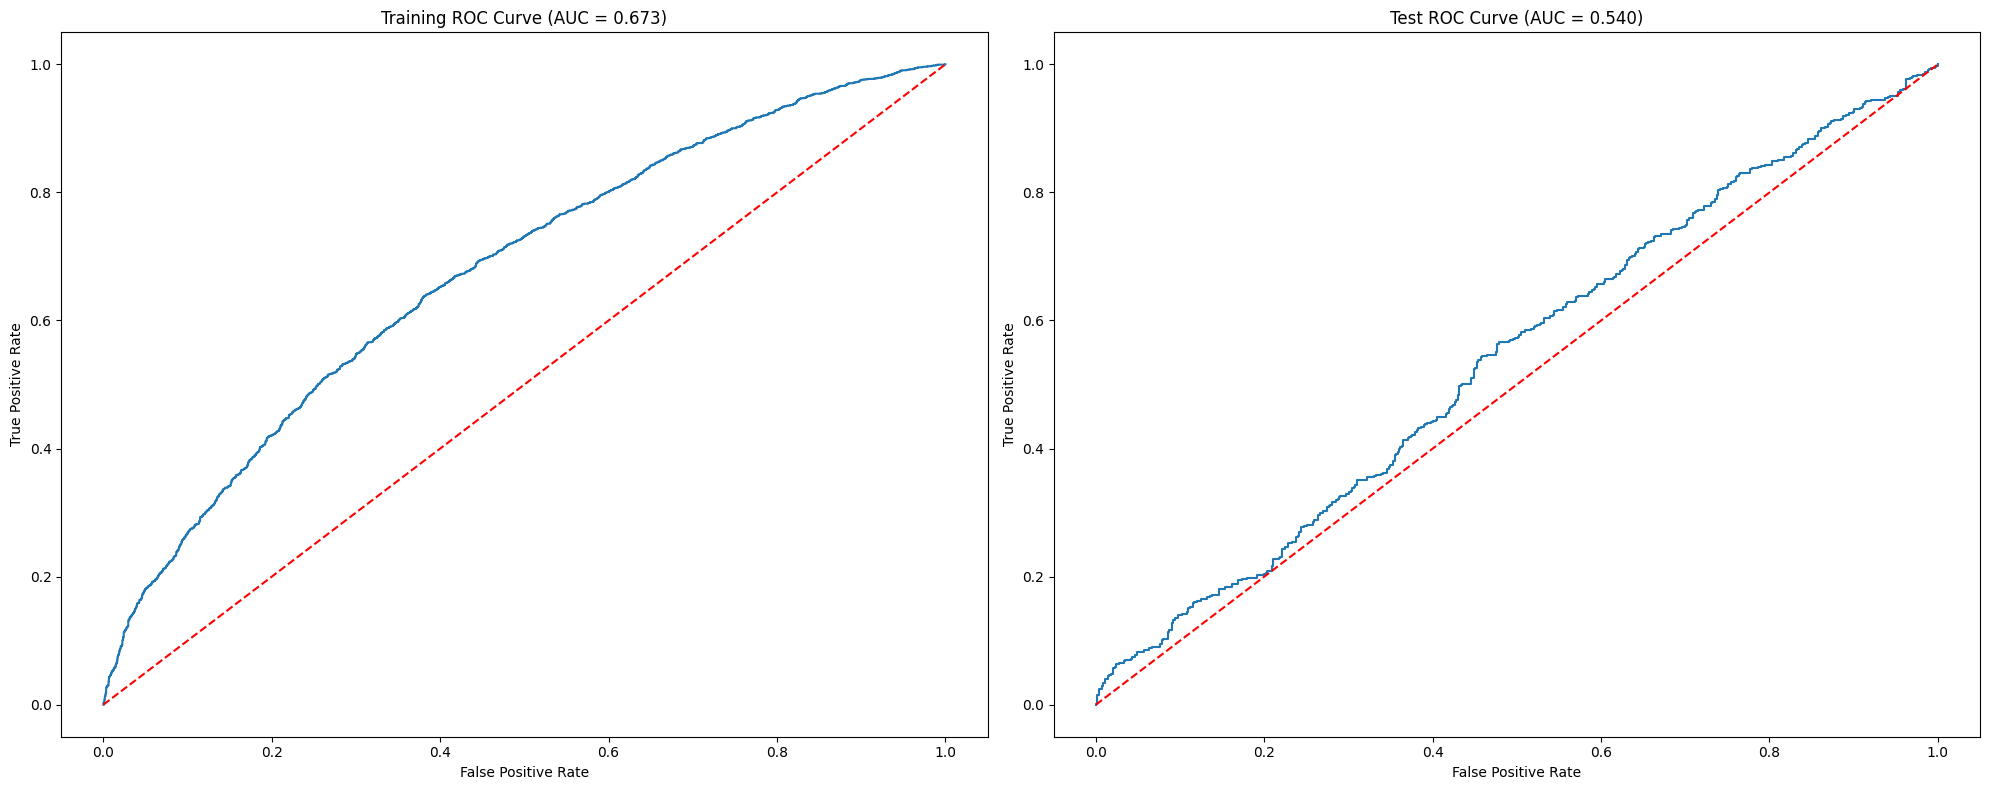

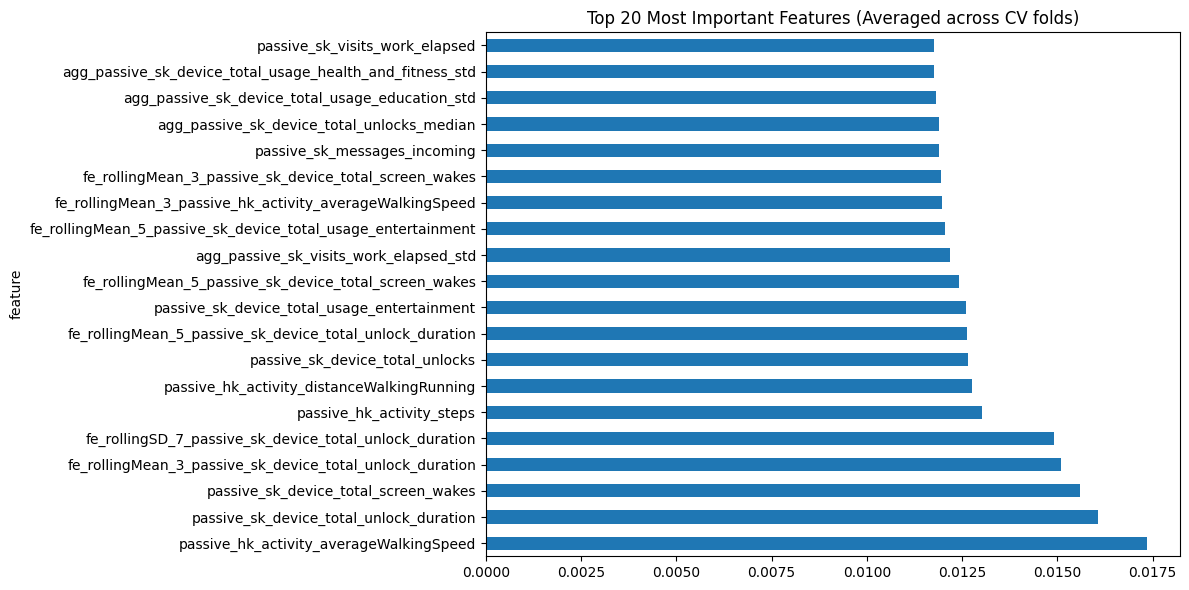

In [320]:
def objective(trial, X, y, cv_folds):
    params = {
        'objective': 'binary:logistic',
        # Reduce model complexity
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True), 
        
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20), 
        'gamma': trial.suggest_float('gamma', 0.5, 3.0),  # Increased gamma range
        
        # More aggressive subsampling
        'subsample': trial.suggest_float('subsample', 0.5, .9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, .9), 
        
        # Stronger L1/L2 regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 10, 100, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 10, 100, log=True),
        
        'random_state': 42,
        'eval_metric': ['auc', 'error'],
        
        'early_stopping_rounds': 30
    }
    
    # Add k-fold cross validation scores
    k_fold_scores = []
    
    for train_idx, val_idx in cv_folds:
        model = xgb.XGBClassifier(**params)
        
        model.fit(
            X.iloc[train_idx], 
            y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False
        )
        
        val_preds = model.predict_proba(X.iloc[val_idx])[:, 1]
        auc_score = roc_auc_score(y.iloc[val_idx], val_preds)
        k_fold_scores.append(auc_score)
    return -np.mean(k_fold_scores)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, X_train, y_train, cv_folds), 
    n_trials=50,
    show_progress_bar=True
)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'random_state': 42,
    'early_stopping_rounds': 30
})

print("\nBest parameters found:", best_params)

# Train final model with best parameters using cross-validation
cv_scores = []
cv_models = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
    fold_model = xgb.XGBClassifier(**best_params)
    fold_model.fit(
        X_train.iloc[train_idx], 
        y_train.iloc[train_idx],
        eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
        verbose=False
    )
    cv_models.append(fold_model)
    
    # Calculate fold score
    val_preds = fold_model.predict_proba(X_train.iloc[val_idx])[:, 1]
    fold_score = roc_auc_score(y_train.iloc[val_idx], val_preds)
    cv_scores.append(fold_score)

# Make predictions
y_pred_train_proba = np.mean([model.predict_proba(X_train)[:, 1] for model in cv_models], axis=0)
y_pred_test_proba = np.mean([model.predict_proba(X_test)[:, 1] for model in cv_models], axis=0)

y_pred_train = (y_pred_train_proba > 0.5).astype(int)
y_pred_test = (y_pred_test_proba > 0.5).astype(int)

# Print metrics
print("\nCross-validation ROC-AUC scores:", cv_scores)
print(f"Mean CV ROC-AUC: {-np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
print("\nTraining Set Metrics:")
print(classification_report(y_train, y_pred_train))
print("\nTest Set Metrics:")
print(classification_report(y_test, y_pred_test))

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training ROC
fpr, tpr, _ = roc_curve(y_train, y_pred_train_proba)
train_auc = roc_auc_score(y_train, y_pred_train_proba)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'Training ROC Curve (AUC = {train_auc:.3f})')

# Test ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
test_auc = roc_auc_score(y_test, y_pred_test_proba)
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Test ROC Curve (AUC = {test_auc:.3f})')

plt.tight_layout()
plt.show()

# Plot feature importance
importance_dfs = []
for model in cv_models:
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    })
    importance_dfs.append(importance_df)

avg_importance = pd.concat(importance_dfs).groupby('feature')['importance'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_importance.head(20).plot(kind='barh')
plt.title('Top 20 Most Important Features (Averaged across CV folds)')
plt.tight_layout()
plt.show()

#### Individual Models

100%|██████████| 104/104 [00:06<00:00, 16.73it/s]



Individual Models Aggregated Results:

Training Set Metrics:
              precision    recall  f1-score   support

           0       0.75      0.49      0.59      2438
           1       0.61      0.84      0.71      2376

    accuracy                           0.66      4814
   macro avg       0.68      0.66      0.65      4814
weighted avg       0.68      0.66      0.65      4814


Test Set Metrics:
              precision    recall  f1-score   support

           0       0.53      0.34      0.41       575
           1       0.50      0.68      0.58       555

    accuracy                           0.51      1130
   macro avg       0.51      0.51      0.50      1130
weighted avg       0.51      0.51      0.49      1130



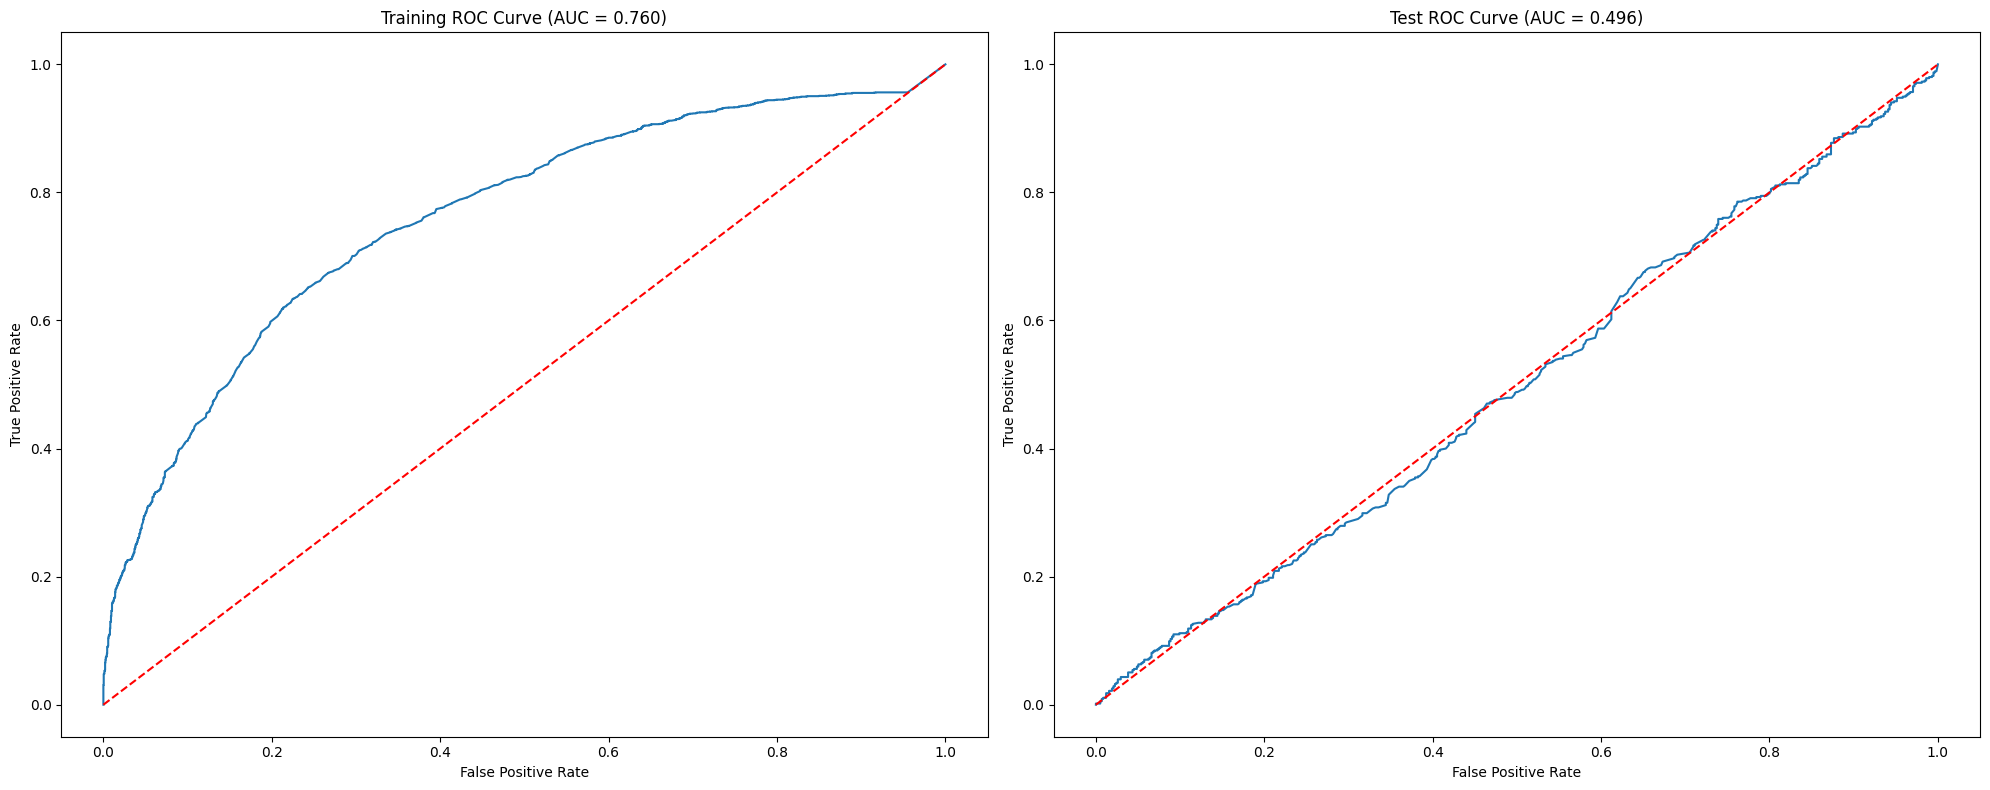

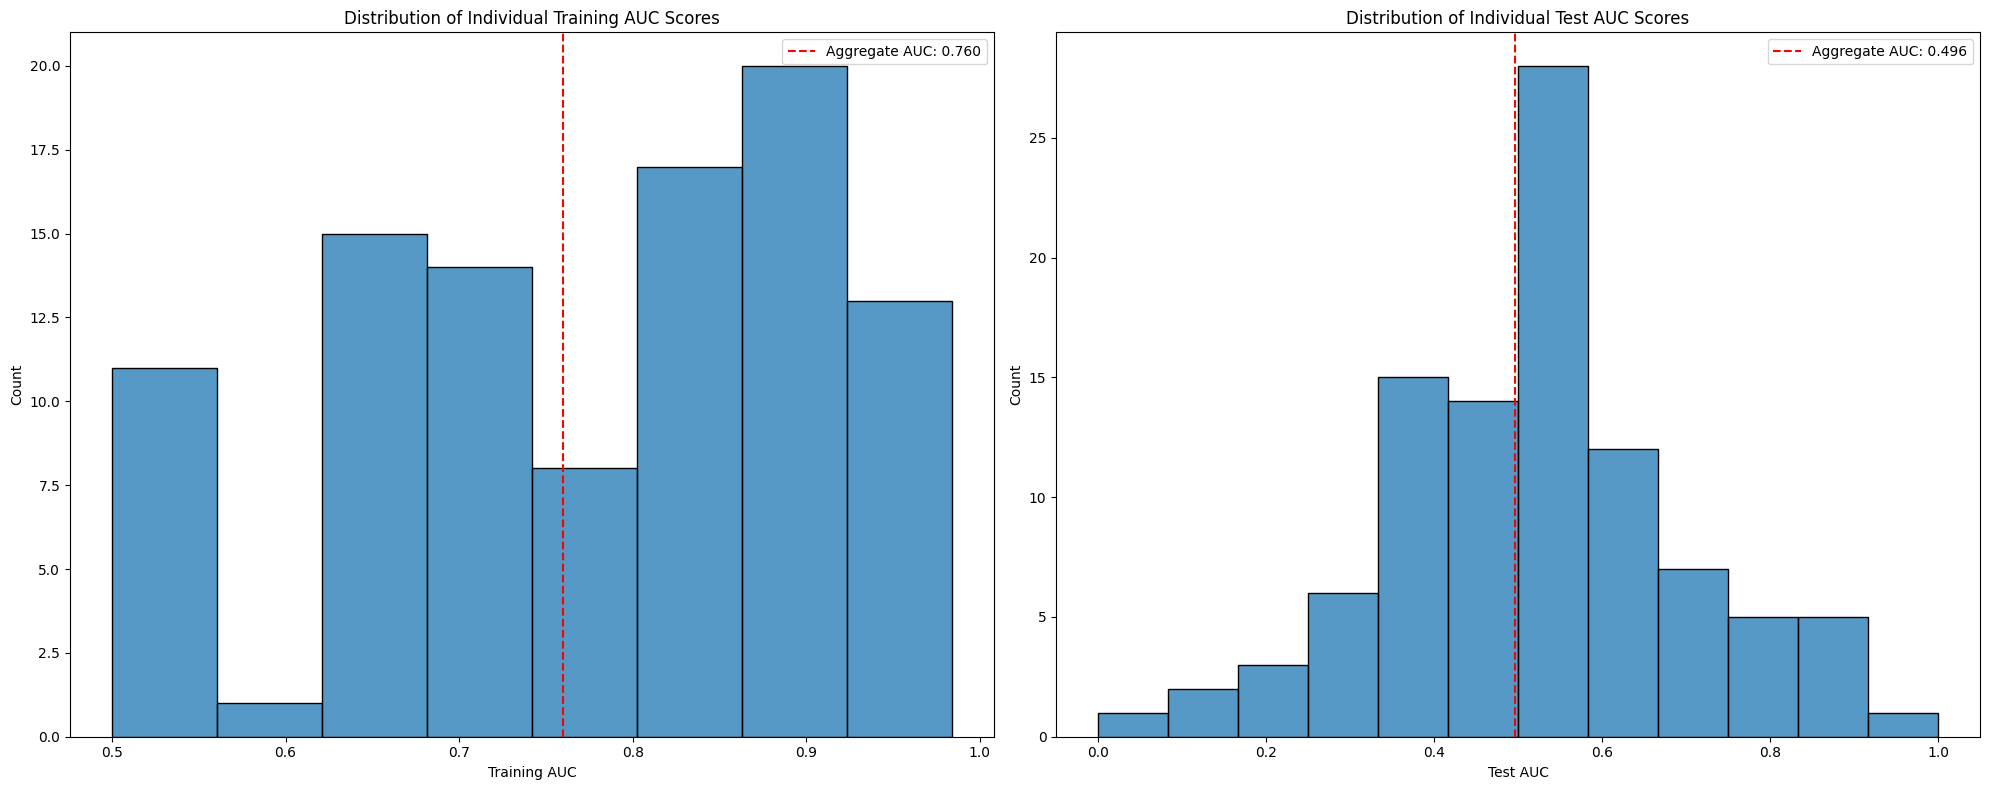


Individual Model Performance Summary:

Training AUC:
count    99.000000
mean      0.771183
std       0.139299
min       0.500000
25%       0.679516
50%       0.802721
75%       0.880108
max       0.983871
Name: train_auc, dtype: float64

Test AUC:
count    99.000000
mean      0.510562
std       0.180441
min       0.000000
25%       0.404545
50%       0.500000
75%       0.612698
max       1.000000
Name: test_auc, dtype: float64


In [354]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold

def train_individual_models(X_train, y_train, X_test, y_test, train_data_clean, test_data_clean, best_params):
    """
    Train individual XGBoost models for each subject with improvements
    """
    model_params = best_params.copy()
    if 'early_stopping_rounds' in model_params:
        del model_params['early_stopping_rounds']
    
    # Initialize arrays
    train_probs = np.zeros(len(y_train))
    test_probs = np.zeros(len(y_test))
    subject_metrics = []
    
    # Add validation split for each subject
    for pid in tqdm(train_data_clean['PID'].unique()):
        train_mask = train_data_clean['PID'] == pid
        test_mask = test_data_clean['PID'] == pid
        
        if not any(test_mask):
            continue
            
        X_train_subj = X_train[train_mask]
        y_train_subj = y_train[train_mask]
        X_test_subj = X_test[test_mask]
        y_test_subj = y_test[test_mask]
        
        # Create validation split for early stopping
        split_idx = int(len(X_train_subj) * 0.8)
        X_train_split = X_train_subj[:split_idx]
        y_train_split = y_train_subj[:split_idx]
        X_val_split = X_train_subj[split_idx:]
        y_val_split = y_train_subj[split_idx:]
        
        # Skip if insufficient data or no variation in target
        if (len(y_train_split) < 20 or 
            len(y_val_split) < 5 or
            len(np.unique(y_train_split)) < 2 or 
            len(np.unique(y_test_subj)) < 2):
            continue
        
        # Calculate class weights with smoothing
        class_counts = np.bincount(y_train_split.astype(int))
        total = len(y_train_split)
        # Add smoothing factor to prevent extreme weights
        smoothing = 1
        class_weights = total / ((class_counts + smoothing) * len(class_counts))
        
        # Create early stopping callback
        early_stopping = xgb.callback.EarlyStopping(
            rounds=20,
            metric_name='logloss',
            save_best=True,
            maximize=False
        )
        
        # Update model parameters for this subject
        subject_params = {
            'objective': 'binary:logistic',
            'max_depth': 4,
            'min_child_weight': 3,
            'learning_rate': 0.01,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': class_weights[1] / class_weights[0],
            'random_state': 42,
            'n_estimators': 1000,
            'enable_categorical': False,
            'callbacks': [early_stopping]
        }
        
        # Train model
        model = xgb.XGBClassifier(**subject_params)
        
        try:
            # Fit model
            model.fit(
                X_train_split, y_train_split,
                eval_set=[(X_val_split, y_val_split)],
                verbose=False
            )
            
            # Make predictions
            train_probs[train_mask] = model.predict_proba(X_train_subj)[:, 1]
            test_probs[test_mask] = model.predict_proba(X_test_subj)[:, 1]
            
            # Calculate metrics
            train_auc = roc_auc_score(y_train_subj, train_probs[train_mask])
            test_auc = roc_auc_score(y_test_subj, test_probs[test_mask])
            
            subject_metrics.append({
                'PID': pid,
                'train_samples': len(y_train_subj),
                'test_samples': len(y_test_subj),
                'train_auc': train_auc,
                'test_auc': test_auc,
                'train_class_dist': np.bincount(y_train_subj.astype(int)),
                'test_class_dist': np.bincount(y_test_subj.astype(int))
            })
            
        except Exception as e:
            print(f"Warning: Error training model for subject {pid}: {str(e)}")
            continue
    
    # Find optimal threshold using cross-validation with multiple metrics
    cv_thresholds = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(train_probs):
        # Test multiple threshold values
        thresholds = np.linspace(0.2, 0.8, 60)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (train_probs[val_idx] > threshold).astype(int)
            f1 = f1_score(y_train[val_idx], y_pred)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
        cv_thresholds.append(best_threshold)
    
    optimal_threshold = np.median(cv_thresholds)
    
    # Convert probabilities to predictions using optimal threshold
    train_preds = (train_probs > optimal_threshold).astype(int)
    test_preds = (test_probs > optimal_threshold).astype(int)
    
    return {
        'train_preds': train_preds,
        'test_preds': test_preds,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'optimal_threshold': optimal_threshold,
        'subject_metrics': pd.DataFrame(subject_metrics)
    }

# Run individual models
results = train_individual_models(
    X_train, y_train, X_test, y_test, 
    train_data_clean, test_data_clean, 
    best_params
)

# Print metrics
print("\nIndividual Models Aggregated Results:")
print("\nTraining Set Metrics:")
print(classification_report(y_train, results['train_preds']))
print("\nTest Set Metrics:")
print(classification_report(y_test, results['test_preds']))

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training ROC
fpr, tpr, _ = roc_curve(y_train, results['train_probs'])
train_auc = roc_auc_score(y_train, results['train_probs'])
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'Training ROC Curve (AUC = {train_auc:.3f})')

# Test ROC
fpr, tpr, _ = roc_curve(y_test, results['test_probs'])
test_auc = roc_auc_score(y_test, results['test_probs'])
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Test ROC Curve (AUC = {test_auc:.3f})')

plt.tight_layout()
plt.show()

# Plot distribution of individual subject metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training AUC distribution
sns.histplot(data=results['subject_metrics'], x='train_auc', ax=ax1)
ax1.axvline(train_auc, color='r', linestyle='--', label=f'Aggregate AUC: {train_auc:.3f}')
ax1.set_title('Distribution of Individual Training AUC Scores')
ax1.set_xlabel('Training AUC')
ax1.legend()

# Test AUC distribution
sns.histplot(data=results['subject_metrics'], x='test_auc', ax=ax2)
ax2.axvline(test_auc, color='r', linestyle='--', label=f'Aggregate AUC: {test_auc:.3f}')
ax2.set_title('Distribution of Individual Test AUC Scores')
ax2.set_xlabel('Test AUC')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics of individual model performance
print("\nIndividual Model Performance Summary:")
print("\nTraining AUC:")
print(results['subject_metrics']['train_auc'].describe())
print("\nTest AUC:")
print(results['subject_metrics']['test_auc'].describe())

In [371]:
# Create binary target based on subject's median
train_data_clean['target_above_median'] = (train_data_clean['t_current'] > 
                                          train_data_clean['agg_t_current_median']).astype(int)
test_data_clean['target_above_median'] = (test_data_clean['t_current'] > 
                                         test_data_clean['agg_t_current_median']).astype(int)

# Update target variables
X_train = train_data_clean[features]
y_train = train_data_clean['target_above_median']
X_test = test_data_clean[features]
y_test = test_data_clean['target_above_median']

100%|██████████| 104/104 [00:05<00:00, 17.69it/s]



Summary Statistics:

Mean metrics across subjects:
train_auc              0.905033
test_auc               0.510957
train_class_balance    0.493760
test_class_balance     0.488603
dtype: float64

Standard deviation of metrics across subjects:
train_auc              0.044957
test_auc               0.204594
train_class_balance    0.005710
test_class_balance     0.162220
dtype: float64


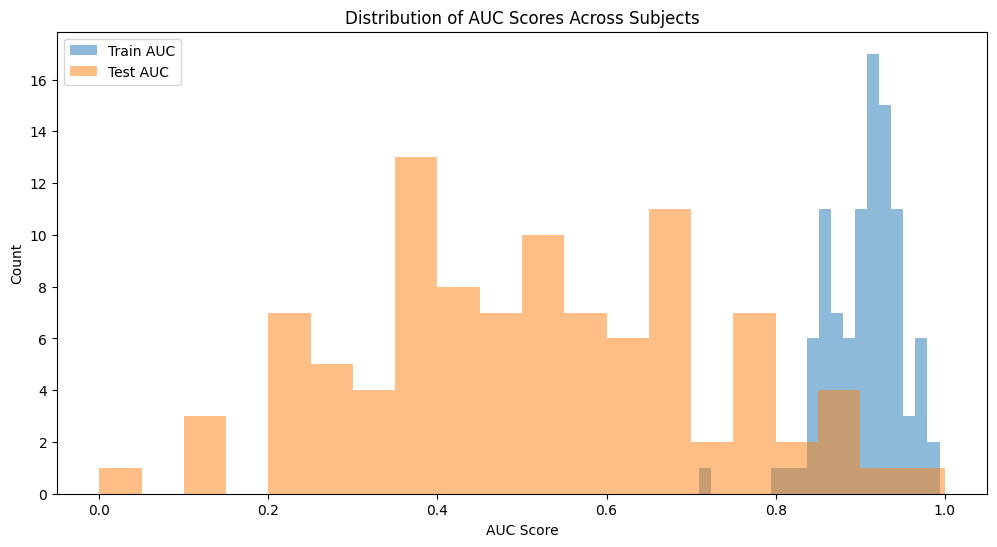

In [382]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance without plotting"""
    # Get predictions
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    
    # Get confusion matrices
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_cm = confusion_matrix(y_train, train_preds)
    test_cm = confusion_matrix(y_test, test_preds)
    
    return {
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_tn': train_cm[0,0],
        'train_fp': train_cm[0,1],
        'train_fn': train_cm[1,0],
        'train_tp': train_cm[1,1],
        'test_tn': test_cm[0,0],
        'test_fp': test_cm[0,1],
        'test_fn': test_cm[1,0],
        'test_tp': test_cm[1,1]
    }

# Initialize results dataframe
results = []

# Iterate through all PIDs
for pid in tqdm(train_data_clean['PID'].unique()):
    try:
        # Filter data for current PID
        train_pid_mask = train_data_clean['PID'] == pid
        test_pid_mask = test_data_clean['PID'] == pid
        
        # Create binary target based on subject's median
        train_data_clean.loc[train_pid_mask, 'target_above_median'] = (
            train_data_clean.loc[train_pid_mask, 't_current'] > 
            train_data_clean.loc[train_pid_mask, 'agg_t_current_median']
        ).astype(int)
        
        test_data_clean.loc[test_pid_mask, 'target_above_median'] = (
            test_data_clean.loc[test_pid_mask, 't_current'] > 
            test_data_clean.loc[test_pid_mask, 'agg_t_current_median']
        ).astype(int)
        
        # Get features and targets
        X_train = train_data_clean.loc[train_pid_mask, features].copy()
        X_test = test_data_clean.loc[test_pid_mask, features].copy()
        y_train = train_data_clean.loc[train_pid_mask, 'target_above_median']
        y_test = test_data_clean.loc[test_pid_mask, 'target_above_median']
        
        # Skip if insufficient data
        if len(y_train) < 20 or len(y_test) < 5:
            continue
            
        # Skip if no variation in target
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
            continue
        
        # Handle missing values
        X_train = X_train.ffill()
        X_test = X_test.ffill()
        
        # Drop features with NaN values
        features_with_nans = X_train.columns[X_train.isna().any()].tolist()
        X_train = X_train.drop(columns=features_with_nans)
        X_test = X_test.drop(columns=features_with_nans)
        
        # Train XGBoost
        xgb_model = xgb.XGBClassifier(
            random_state=42,
            max_depth=3,
            min_child_weight=3,
            learning_rate=0.01,
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1,
            reg_lambda=1
        )
        xgb_model.fit(X_train, y_train)
        
        # Evaluate model
        metrics = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
        
        # Add PID and data counts to metrics
        metrics.update({
            'PID': pid,
            'train_samples': len(y_train),
            'test_samples': len(y_test),
            'train_class_balance': y_train.mean(),
            'test_class_balance': y_test.mean()
        })
        
        results.append(metrics)
        
    except Exception as e:
        print(f"Error processing PID {pid}: {str(e)}")
        continue

# Convert results to dataframe
results_df = pd.DataFrame(results)

# Calculate summary statistics
print("\nSummary Statistics:")
print("\nMean metrics across subjects:")
print(results_df[[
    'train_auc', 'test_auc', 
    'train_class_balance', 'test_class_balance'
]].mean())

print("\nStandard deviation of metrics across subjects:")
print(results_df[[
    'train_auc', 'test_auc', 
    'train_class_balance', 'test_class_balance'
]].std())

# Plot distribution of AUC scores
plt.figure(figsize=(12, 6))
plt.hist(results_df['train_auc'], alpha=0.5, label='Train AUC', bins=20)
plt.hist(results_df['test_auc'], alpha=0.5, label='Test AUC', bins=20)
plt.xlabel('AUC Score')
plt.ylabel('Count')
plt.title('Distribution of AUC Scores Across Subjects')
plt.legend()
plt.show()

# Save results
results_df.to_csv('individual_model_results.csv', index=False)

### Categorical: Increase

#### Create Target

In [397]:
def create_increase_target(df: pd.DataFrame) -> pd.Series:
    """Create target indicating 0.5 SD increase from previous day."""
    targets = pd.Series(index=df.index, dtype=float)
    
    for pid in df['PID'].unique():
        pid_mask = df['PID'] == pid
        pid_data = df[pid_mask].sort_values('day')
        
        # Get subject's SD from their data
        subject_sd = df.loc[pid_mask, 't_current'].std()
        threshold = 0.5 * subject_sd
        
        # Calculate day-over-day change
        pid_data['prev_t_current'] = pid_data['t_current'].shift(1)
        pid_data['prev_day'] = pid_data['day'].shift(1)
        
        # Only mark as increase if we have consecutive days
        increase_mask = (
            (pid_data['t_current'] - pid_data['prev_t_current'] >= threshold) & 
            (pid_data['day'] - pid_data['prev_day'] == 1)
        )
        
        targets.loc[pid_data.index] = increase_mask.astype(float)
    
    return targets

# Create targets for train and test
train_data_clean['target_increase'] = create_increase_target(train_data_clean)
test_data_clean['target_increase'] = create_increase_target(test_data_clean)

# Remove rows where we couldn't calculate the target
train_data_clean = train_data_clean.dropna(subset=['target_increase'])
test_data_clean = test_data_clean.dropna(subset=['target_increase'])

# Update target variables
X_train = train_data_clean[features]
y_train = train_data_clean['target_increase']
X_test = test_data_clean[features]
y_test = test_data_clean['target_increase']

In [400]:
from sklearn.metrics import f1_score, precision_score, recall_score

[I 2025-01-15 13:33:22,551] A new study created in memory with name: no-name-798ae13c-4b3d-490d-a2a8-4ec0b1831fed


Training set class distribution:
target_increase
0.0    0.686539
1.0    0.313461
Name: proportion, dtype: float64

Test set class distribution:
target_increase
0.0    0.717699
1.0    0.282301
Name: proportion, dtype: float64


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-15 13:33:22,938] Trial 0 finished with value: -0.5117182926170785 and parameters: {'n_estimators': 373, 'max_depth': 2, 'learning_rate': 0.05177946463608521, 'min_child_weight': 6, 'subsample': 0.844753662563206, 'colsample_bytree': 0.7075051613539621, 'reg_alpha': 4.484186914298781, 'reg_lambda': 4.569039813152211, 'scale_pos_weight': 7.842699345862026}. Best is trial 0 with value: -0.5117182926170785.
[I 2025-01-15 13:33:25,525] Trial 1 finished with value: -0.5338118518257791 and parameters: {'n_estimators': 206, 'max_depth': 4, 'learning_rate': 0.09847490285243486, 'min_child_weight': 5, 'subsample': 0.7040592693849158, 'colsample_bytree': 0.9974042722702772, 'reg_alpha': 3.178030262027384, 'reg_lambda': 5.075878954009981, 'scale_pos_weight': 9.332502722624046}. Best is trial 1 with value: -0.5338118518257791.
[I 2025-01-15 13:33:29,597] Trial 2 finished with value: -0.550355522731862 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.03068406609822

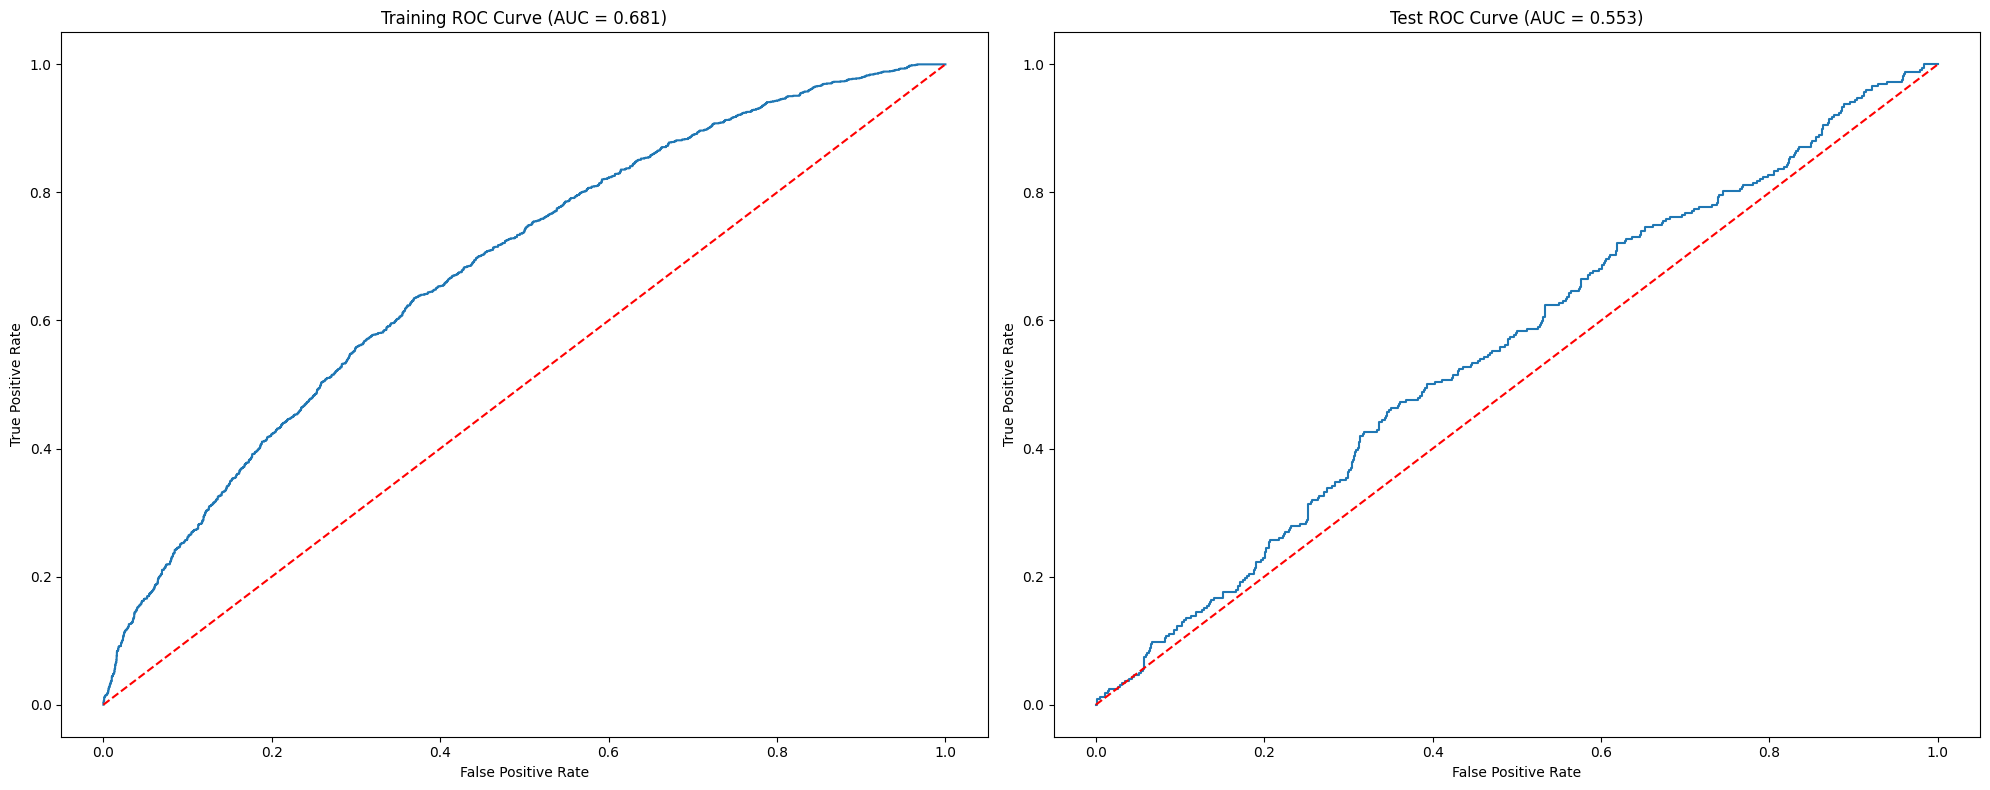

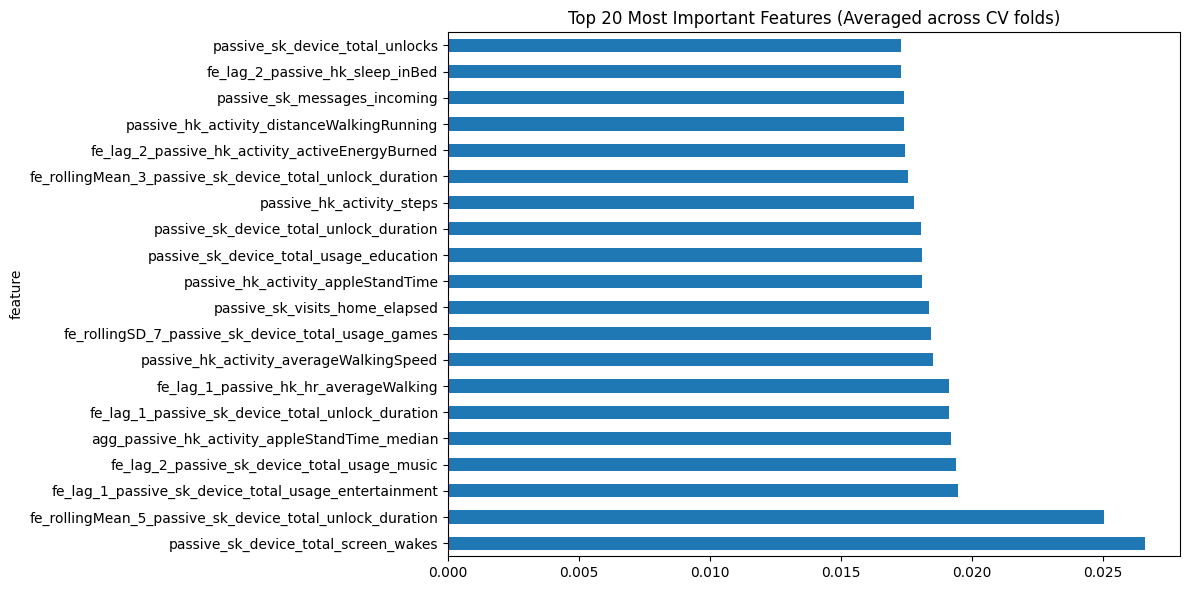

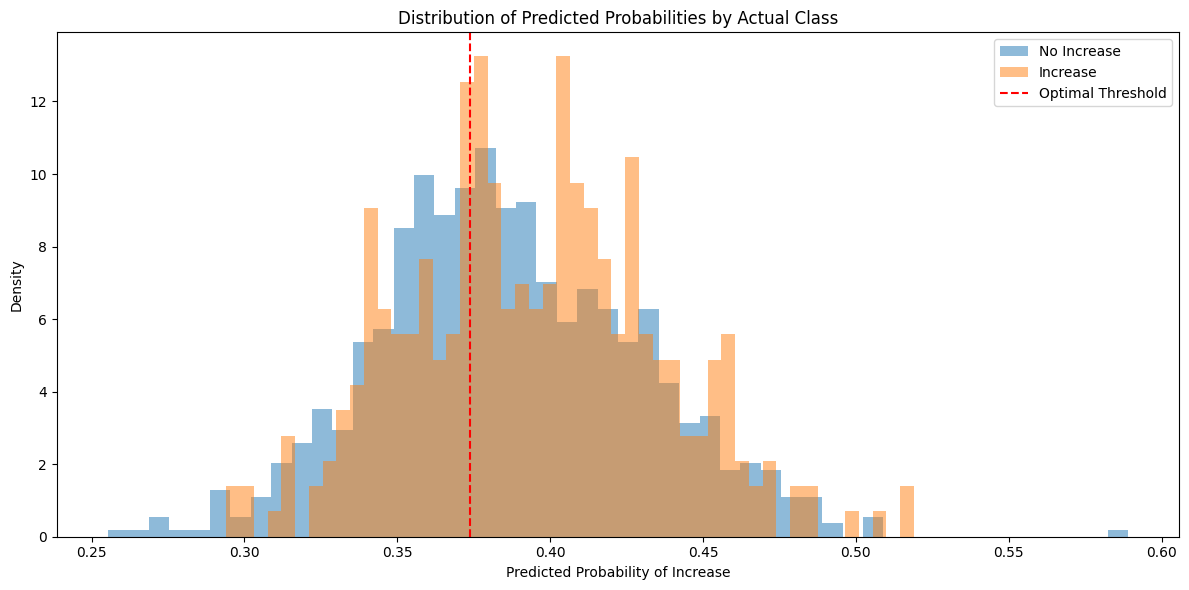

In [405]:
# Print class distribution
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

def objective(trial, X, y, cv_folds):
    params = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 20.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 20.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),  # Added for class imbalance
        'random_state': 42,
        'early_stopping_rounds': 30
    }
    
    fold_scores = []
    
    for train_idx, val_idx in cv_folds:
        model = xgb.XGBClassifier(**params)
        model.fit(
            X.iloc[train_idx], 
            y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False
        )
        
        val_preds = model.predict_proba(X.iloc[val_idx])[:, 1]
        fold_score = roc_auc_score(y.iloc[val_idx], val_preds)
        fold_scores.append(fold_score)
    
    return -np.mean(fold_scores)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, X_train, y_train, cv_folds), 
    n_trials=50,
    show_progress_bar=True
)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'random_state': 42,
    'early_stopping_rounds': 30
})

print("\nBest parameters found:", best_params)

# Train final model with best parameters using cross-validation
cv_scores = []
cv_models = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
    fold_model = xgb.XGBClassifier(**best_params)
    fold_model.fit(
        X_train.iloc[train_idx], 
        y_train.iloc[train_idx],
        eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
        verbose=False
    )
    cv_models.append(fold_model)
    
    # Calculate fold score
    val_preds = fold_model.predict_proba(X_train.iloc[val_idx])[:, 1]
    fold_score = roc_auc_score(y_train.iloc[val_idx], val_preds)
    cv_scores.append(fold_score)

# Make predictions
y_pred_train_proba = np.mean([model.predict_proba(X_train)[:, 1] for model in cv_models], axis=0)
y_pred_test_proba = np.mean([model.predict_proba(X_test)[:, 1] for model in cv_models], axis=0)

# Find optimal threshold using training data
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for threshold in thresholds:
    y_pred = (y_pred_train_proba > threshold).astype(int)
    f1 = f1_score(y_train, y_pred)
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Apply optimal threshold
y_pred_train = (y_pred_train_proba > optimal_threshold).astype(int)
y_pred_test = (y_pred_test_proba > optimal_threshold).astype(int)

# Print metrics
print("\nCross-validation ROC-AUC scores:", cv_scores)
print(f"Mean CV ROC-AUC: {-np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
print("\nTraining Set Metrics:")
print(classification_report(y_train, y_pred_train))
print("\nTest Set Metrics:")
print(classification_report(y_test, y_pred_test))

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training ROC
fpr, tpr, _ = roc_curve(y_train, y_pred_train_proba)
train_auc = roc_auc_score(y_train, y_pred_train_proba)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'Training ROC Curve (AUC = {train_auc:.3f})')

# Test ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
test_auc = roc_auc_score(y_test, y_pred_test_proba)
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Test ROC Curve (AUC = {test_auc:.3f})')

plt.tight_layout()
plt.show()

# Plot feature importance
importance_dfs = []
for model in cv_models:
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    })
    importance_dfs.append(importance_df)

avg_importance = pd.concat(importance_dfs).groupby('feature')['importance'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_importance.head(20).plot(kind='barh')
plt.title('Top 20 Most Important Features (Averaged across CV folds)')
plt.tight_layout()
plt.show()

# Additional visualization: Distribution of probabilities
plt.figure(figsize=(12, 6))
plt.hist(y_pred_test_proba[y_test == 0], bins=50, alpha=0.5, label='No Increase', density=True)
plt.hist(y_pred_test_proba[y_test == 1], bins=50, alpha=0.5, label='Increase', density=True)
plt.axvline(optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Predicted Probability of Increase')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by Actual Class')
plt.legend()
plt.tight_layout()
plt.show()


Model Performance vs Random Baseline:
Model AUC: 0.553
Random AUC: 0.495


Running permutation test: 100%|██████████| 10000/10000 [00:08<00:00, 1169.43it/s]



Permutation Test Results:
p-value: 0.0021


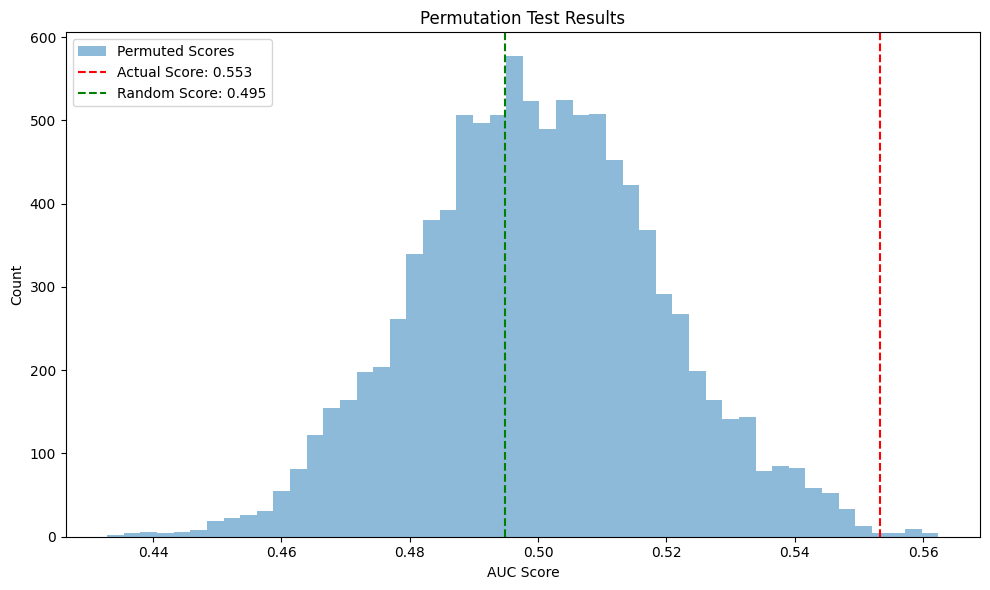

In [406]:
## SIGNIFICANCE TESTING

from scipy import stats
from sklearn.metrics import balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from statsmodels.stats.contingency_tables import mcnemar 

# 1. Compare against stratified random classifier
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])

print("\nModel Performance vs Random Baseline:")
print(f"Model AUC: {test_auc:.3f}")
print(f"Random AUC: {dummy_auc:.3f}")

# 2. Permutation test
n_permutations = 10000
permutation_scores = []

for _ in tqdm(range(n_permutations), desc="Running permutation test"):
    # Shuffle the labels
    y_shuffled = y_test.sample(frac=1, random_state=np.random.randint(0, 10000)).reset_index(drop=True)
    # Calculate AUC with shuffled labels
    perm_auc = roc_auc_score(y_shuffled, y_pred_test_proba)
    permutation_scores.append(perm_auc)

# Calculate p-value
p_value = np.mean(np.array(permutation_scores) >= test_auc)
print(f"\nPermutation Test Results:")
print(f"p-value: {p_value:.4f}")

# # 3. McNemar's test for comparing predictions against majority class
# majority_pred = np.ones(len(y_test)) * stats.mode(y_train)[0]

# table = mcnemar(
#     y_test == y_test.mode()[0],  # Majority class predictions
#     y_test == y_pred_test,       # Model predictions
#     exact=True,
#     correction=True
# )
# print("\nMcNemar's Test Results:")
# print(f"Statistic: {table.statistic:.4f}")
# print(f"p-value: {table.pvalue:.4f}")

# Visualize permutation test results
plt.figure(figsize=(10, 6))
plt.hist(permutation_scores, bins=50, alpha=0.5, label='Permuted Scores')
plt.axvline(test_auc, color='r', linestyle='--', label=f'Actual Score: {test_auc:.3f}')
plt.axvline(dummy_auc, color='g', linestyle='--', label=f'Random Score: {dummy_auc:.3f}')
plt.xlabel('AUC Score')
plt.ylabel('Count')
plt.title('Permutation Test Results')
plt.legend()
plt.tight_layout()
plt.show()

# GPBoost

From [this article](https://towardsdatascience.com/tree-boosted-mixed-effects-models-4df610b624cb)

In [111]:
import gpboost as gpb

## Clean Data

In [126]:
# remove subject `c8b323ca-be8b-4374-ab2c-b4788e4a0e3d` who has NO watch data
train_data = train_data[train_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']
test_data = test_data[test_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']

In [127]:
# Drop rows with missing values in t_current
train_data_clean = train_data.dropna(subset=['t_current'])
test_data_clean = test_data.dropna(subset=['t_current'])

## Select Features

In [128]:
# Filter features from mlm_gap_df where abs_t_value > 2 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

Selected 65 features with |t| > 2 (excluding css features):


## Model

Setting up GPBoost model...

Estimated random effects model: 
Covariance parameters (random effects):
              Param.
Error_term  259.6759
Group_1     136.7175


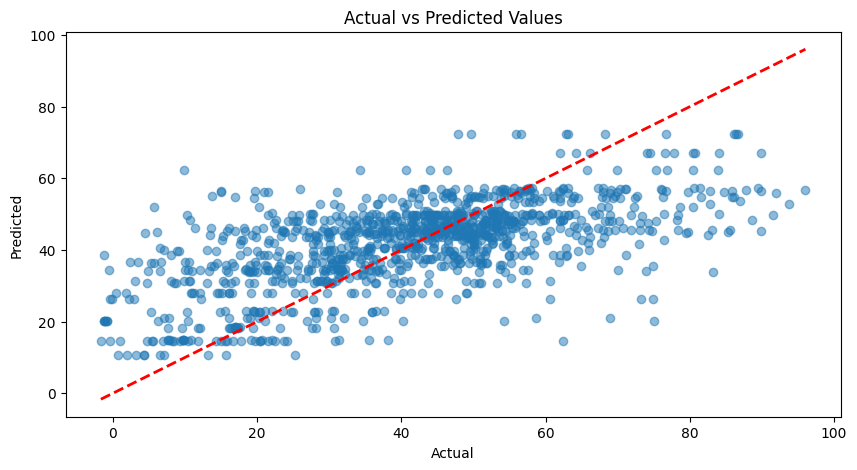


Feature importances: [100, 100, 0, 0, 191, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 100]


[I 2025-01-08 15:39:57,343] A new study created in memory with name: no-name-627f6b59-1cb6-4d6b-9a5e-eb260e5b527b



Optimizing parameters...


[I 2025-01-08 15:40:04,965] Trial 0 finished with value: 267.08013174525905 and parameters: {'learning_rate': 0.013351494520010323, 'min_data_in_leaf': 23, 'max_depth': 2, 'num_leaves': 7, 'lambda_l2': 7.337794540855652, 'max_bin': 76}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:40:23,862] Trial 1 finished with value: 267.5260388685757 and parameters: {'learning_rate': 0.003182077285755199, 'min_data_in_leaf': 3, 'max_depth': 4, 'num_leaves': 24, 'lambda_l2': 20.95972572016474, 'max_bin': 264}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:40:33,057] Trial 2 finished with value: 267.5616701089681 and parameters: {'learning_rate': 0.0035629562476919238, 'min_data_in_leaf': 53, 'max_depth': 2, 'num_leaves': 47, 'lambda_l2': 20.865240118356347, 'max_bin': 202}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:42:08,676] Trial 3 finished with value: 267.5578486460375 and parameters: {'learning_rate': 0.0023927654893085163, 'min_data_


Best parameters: {'learning_rate': 0.4502961910373316, 'min_data_in_leaf': 7, 'max_depth': 8, 'num_leaves': 191, 'lambda_l2': 1.3045301643060254, 'max_bin': 205}
Best iteration: 660
Best score: [256.7886727161154]
[GPBoost] [Info] Total Bins 12516
[GPBoost] [Info] Number of data points in the train set: 4814, number of used features: 65
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=41.458249
[GPBoost] [Info] Start training from score 41.458249

Final Model Performance:
Test RMSE: 14.9961
Test MAE: 11.6083


In [129]:
print('Setting up GPBoost model...')

# Prepare data
X_train = train_data_clean[features].values
y_train = train_data_clean['t_current'].values
X_test = test_data_clean[features].values 
y_test = test_data_clean['t_current'].values

# Create PID to numeric index mapping for group data
pid_to_idx = {pid: idx for idx, pid in enumerate(train_data_clean['PID'].unique())}
group_train = train_data_clean['PID'].map(pid_to_idx).values
group_test = test_data_clean['PID'].map(pid_to_idx).values

#--------------------Training----------------
# Define GPModel with random effects grouped by PID
gp_model = gpb.GPModel(group_data=group_train, likelihood="gaussian")

# Train initial model with default parameters
params = {
    'objective': 'regression_l2',
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_data_in_leaf': 5,
    'verbose': 0
}

# Create dataset
train_data = gpb.Dataset(X_train, y_train)

# Train model
bst = gpb.train(params=params,
                train_set=train_data,
                gp_model=gp_model,
                num_boost_round=100)

print("\nEstimated random effects model: ")
gp_model.summary()

#--------------------Prediction----------------
# Make predictions
pred = bst.predict(data=X_test, 
                  group_data_pred=group_test,
                  pred_latent=True)  # Get both fixed and random effects

# Calculate and plot actual vs predicted
plt.figure(figsize=(10, 5))
y_pred = pred['fixed_effect'] + pred['random_effect_mean']
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Print feature importances
print('\nFeature importances:', list(bst.feature_importance()))

#--------------------Parameter Tuning----------------
# Define search space based on GPBoost documentation
search_space = {
    'learning_rate': [0.001, 0.5],
    #'min_data_in_leaf': [1, 100],
    'min_child_weight': [1, 100],
    'max_depth': [2, 8],
    'num_leaves': [2, 256],
    'lambda_l2': [0, 50],
    'max_bin': [63, 512]
}

# Define metric
metric = "mse" # Can also use metric = "test_neg_log_likelihood". For more options, see https://github.com/fabsig/GPBoost/blob/master/docs/Parameters.rst#metric-parameters

gp_model = gpb.GPModel(group_data=group_train, likelihood="gaussian")

# Create validation split using last 20% of data for each PID
train_tune_idx = []
valid_tune_idx = []

# Create folds
folds = expanding_window_cv_nested(train_data_clean)

# Run parameter optimization
print('\nOptimizing parameters...')
opt_params = gpb.tune_pars_TPE_algorithm_optuna(
    X=X_train,
    y=y_train,
    search_space=search_space,
    folds=folds,
    gp_model=gp_model,
    metric=metric,
    tpe_seed=1,
    max_num_boost_round=1000,
    n_trials=100,
    early_stopping_rounds=20
)

print("\nBest parameters:", str(opt_params['best_params']))
print("Best iteration:", str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))

# Train final model with best parameters
final_params = opt_params['best_params']
final_params.update({'n_estimators': opt_params['best_iter']})
final_model = gpb.train(params=final_params,
                       train_set=train_data,
                       gp_model=gp_model)

# Make final predictions
final_pred = final_model.predict(data=X_test, 
                               group_data_pred=group_test,
                               pred_latent=True)
y_pred = final_pred['fixed_effect'] + final_pred['random_effect_mean']

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"\nFinal Model Performance:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

In [ ]:
print("\nBest parameters:", str(opt_params['best_params']))
print("Best iteration:", str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))

# Train final model with best parameters
final_params = opt_params['best_params']
final_model = gpb.train(params=final_params,
                       train_set=train_data,
                       gp_model=gp_model)

# Make final predictions
final_pred = final_model.predict(data=X_test, 
                               group_data_pred=group_test,
                               pred_latent=True)
y_pred = final_pred['fixed_effect'] + final_pred['random_effect_mean']

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"\nFinal Model Performance:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Best parameters: {'learning_rate': 0.40786420567450793, 'min_data_in_leaf': 56, 'max_depth': 7, 'num_leaves': 73, 'lambda_l2': 0.011713989534268138, 'max_bin': 440, 'n_estimators': 1000}
Best iteration: 1000
Best score: [256.50969852823147]
[GPBoost] [Info] Total Bins 28171
[GPBoost] [Info] Number of data points in the train set: 4871, number of used features: 68
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=41.620864
[GPBoost] [Info] Start training from score 41.620864


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/gpboost/engine.py:188: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



Final Model Performance:
Test RMSE: 15.0011
Test MAE: 11.5999


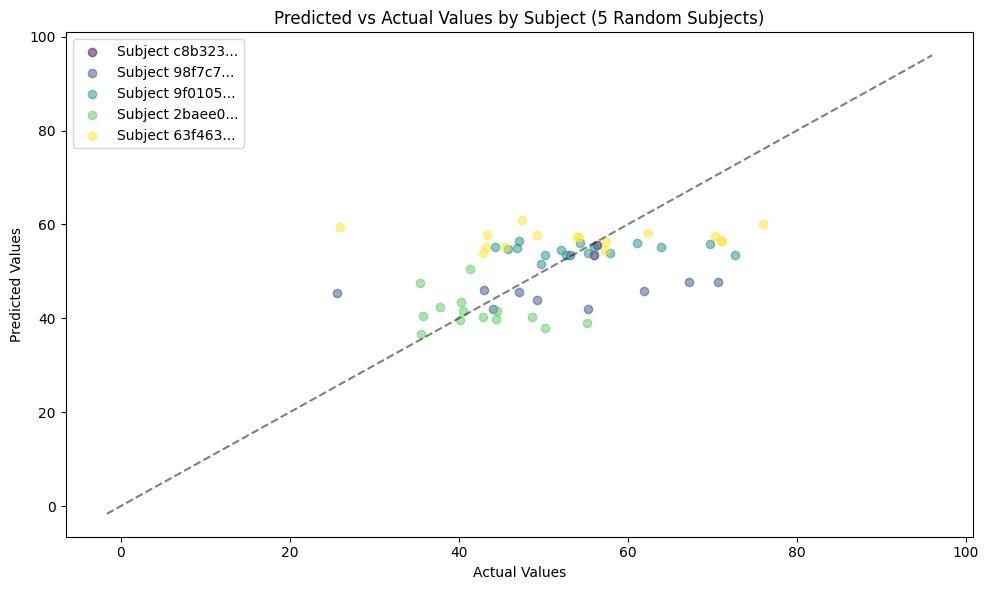

In [ ]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))

# Get unique PIDs and randomly select 5
unique_pids = test_data_clean['PID'].unique()
selected_pids = np.random.choice(unique_pids, size=5, replace=False)

# Create color map for selected PIDs
pid_colors = plt.cm.viridis(np.linspace(0, 1, 5))
pid_color_map = dict(zip(selected_pids, pid_colors))

# Plot points colored by PID for selected PIDs only
for pid in selected_pids:
    mask = test_data_clean['PID'] == pid
    plt.scatter(test_data_clean['t_current'][mask], y_pred[mask], 
               color=pid_color_map[pid], 
               alpha=0.5,
               label=f'Subject {pid[:6]}...')

# Add perfect prediction line
min_val = min(test_data_clean['t_current'].min(), y_pred.min())
max_val = max(test_data_clean['t_current'].max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values by Subject (5 Random Subjects)')
plt.legend()

plt.tight_layout()
plt.show()


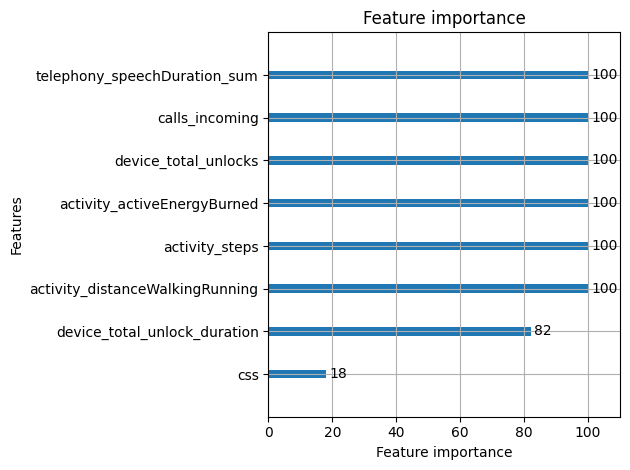

In [ ]:
# Get feature names 
feature_names = features

# Create feature importance plot with actual column names
ax = gpb.plot_importance(bst)

# Get current y-tick labels (which are like "Column_X")
current_labels = ax.get_yticklabels()

# Map the Column_X numbers to actual feature names
new_labels = []
for label in current_labels:
    # Extract the number from "Column_X"
    column_num = int(label.get_text().split('_')[1])
    # Get corresponding feature name
    new_labels.append(feature_names[column_num])

# Set new labels
new_labels = [label.split('passive_', 1)[1][3:] if 'passive_' in label else label for label in new_labels]
ax.set_yticklabels(new_labels)

plt.tight_layout()
plt.show()